# Import Required Libraries
Import the necessary libraries, including TensorFlow and Keras.

In [ ]:
import json
import os
from os import listdir
from google.colab import drive
import tensorflow as tf
from tensorflow import keras # for building and training deep learning models
import numpy as np # for numerical operations on arrays and matrices
import matplotlib.pyplot as plt # for plotting and visualizing data
import matplotlib.image as img # for loading and displaying images
import shutil # for high-level file operations
from os.path import join
import seaborn as sns
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge
from keras.applications.efficientnet import EfficientNetB0

from keras.applications import resnet, vgg16, vgg19, xception, inception_v3, inception_resnet_v2, mobilenet, densenet, nasnet, efficientnet, mobilenet_v2


from keras.layers import Conv2D, Reshape, Embedding, Concatenate, Dense, LayerNormalization, BatchNormalization, Dropout, Input, Layer, Flatten
from keras import layers

from keras.models import Model, load_model
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import Accuracy, AUC, Recall, Precision, CategoricalAccuracy
from pandas import DataFrame, concat
from keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import colorcet as cc

In [ ]:
root_dir = "data"
if not os.path.exists(root_dir):
      os.makedirs(root_dir)

In [ ]:
brain_tumor_dir = join(root_dir, 'brain_tumor')
brain_tumor_train_path = join(brain_tumor_dir, 'train')
brain_tumor_test_path = join(brain_tumor_dir, 'test')
brain_tumor_classes = ['yes', 'no']

def make_brain_tumor_folders():
  if not os.path.exists(brain_tumor_dir):
    os.makedirs(brain_tumor_dir)
    os.makedirs(brain_tumor_train_path)
    os.makedirs(brain_tumor_test_path)

make_brain_tumor_folders()

In [ ]:
!pip install kaggle --quiet
drive.mount('/content/drive', force_remount=True)
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Colab Notebooks/"

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip -q brain-mri-images-for-brain-tumor-detection.zip -d data/brain_tumor

In [ ]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset
!unzip -q augmented-alzheimer-mri-dataset.zip -d data/alzheimer

100% 378M/380M [00:25<00:00, 11.3MB/s]
100% 380M/380M [00:25<00:00, 15.4MB/s]


In [ ]:
!kaggle datasets download -d afridirahman/brain-stroke-ct-image-dataset
!unzip -q brain-stroke-ct-image-dataset.zip -d data/stroke

 99% 60.0M/60.4M [00:04<00:00, 20.0MB/s]
100% 60.4M/60.4M [00:04<00:00, 14.6MB/s]


In [ ]:
drive.flush_and_unmount()

# Load and Preprocess the Data
Load the image data and preprocess it by resizing, normalizing, and augmenting the images.

In [ ]:
# Define the path to the image data directory
def split_train_test_data(images_dir: str, classes, test_ratio: float=0.1):
  for i in classes:
      train_dir = join(images_dir, 'train', i)
      test_dir = join(images_dir, 'test', i)
      if not os.path.exists(train_dir):
          os.makedirs(train_dir)
      if not os.path.exists(test_dir):
          os.makedirs(test_dir)
      source = join(images_dir, i)

      allFileNames = os.listdir(source)

      np.random.shuffle(allFileNames)

      test_ratio = test_ratio

      train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - test_ratio))])

      train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
      test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

      for name in train_FileNames:
          shutil.copy(name, train_dir)

      for name in test_FileNames:
          shutil.copy(name, test_dir)

In [ ]:
split_train_test_data(images_dir=brain_tumor_dir, classes=brain_tumor_classes)

NameError: ignored

In [ ]:
PALETTE = sns.color_palette("Dark2")

def plot_dataset_balance(train_path: str, test_path:str, classes: list[str]):
  train_samples = {}
  test_samples = {}

  for class_name in classes:
    train_samples[class_name] = len(os.listdir(os.path.join(train_path, class_name)))
    test_samples[class_name] = len(os.listdir(os.path.join(test_path, class_name)))


  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  sns.barplot(x=list(train_samples.keys()), y=list(train_samples.values()), palette=PALETTE, ax=ax[0])
  ax[0].set_title('Training Samples')
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')

  sns.barplot(x=list(test_samples.keys()), y=list(test_samples.values()), palette=PALETTE, ax=ax[1])
  ax[1].set_title('Test Samples')
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
  plt.show()

def show_example_grid(train_path: str, classes):
  num_classes = len(classes)
  num_examples = 5
  fig, ax = plt.subplots(num_classes, num_examples, figsize=(15,11))
  fig.suptitle('Image examples', fontsize=30)
  samples = []
  paths = []
  for class_name in classes:
    samples.append(os.listdir(join(train_path, class_name)))
    paths.append(join(train_path, class_name))

  for i in range(num_classes):
      for j in range(num_examples):
          image_file = np.random.choice(samples[i])
          image_path = join(paths[i], image_file)
          image = img.imread(image_path)
          ax[i, j].imshow(image)
          ax[i, j].set_title(classes[i], fontsize=20, color=PALETTE[i])
          ax[i, j].axis('off')
          ax[i, j].tick_params(axis='both', which='both', length=0)
  plt.tight_layout()

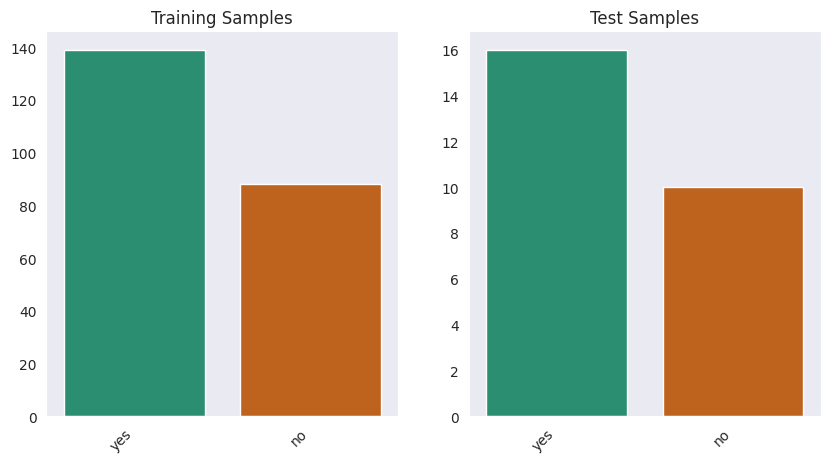

In [ ]:
plot_dataset_balance(brain_tumor_train_path, brain_tumor_test_path, brain_tumor_classes)

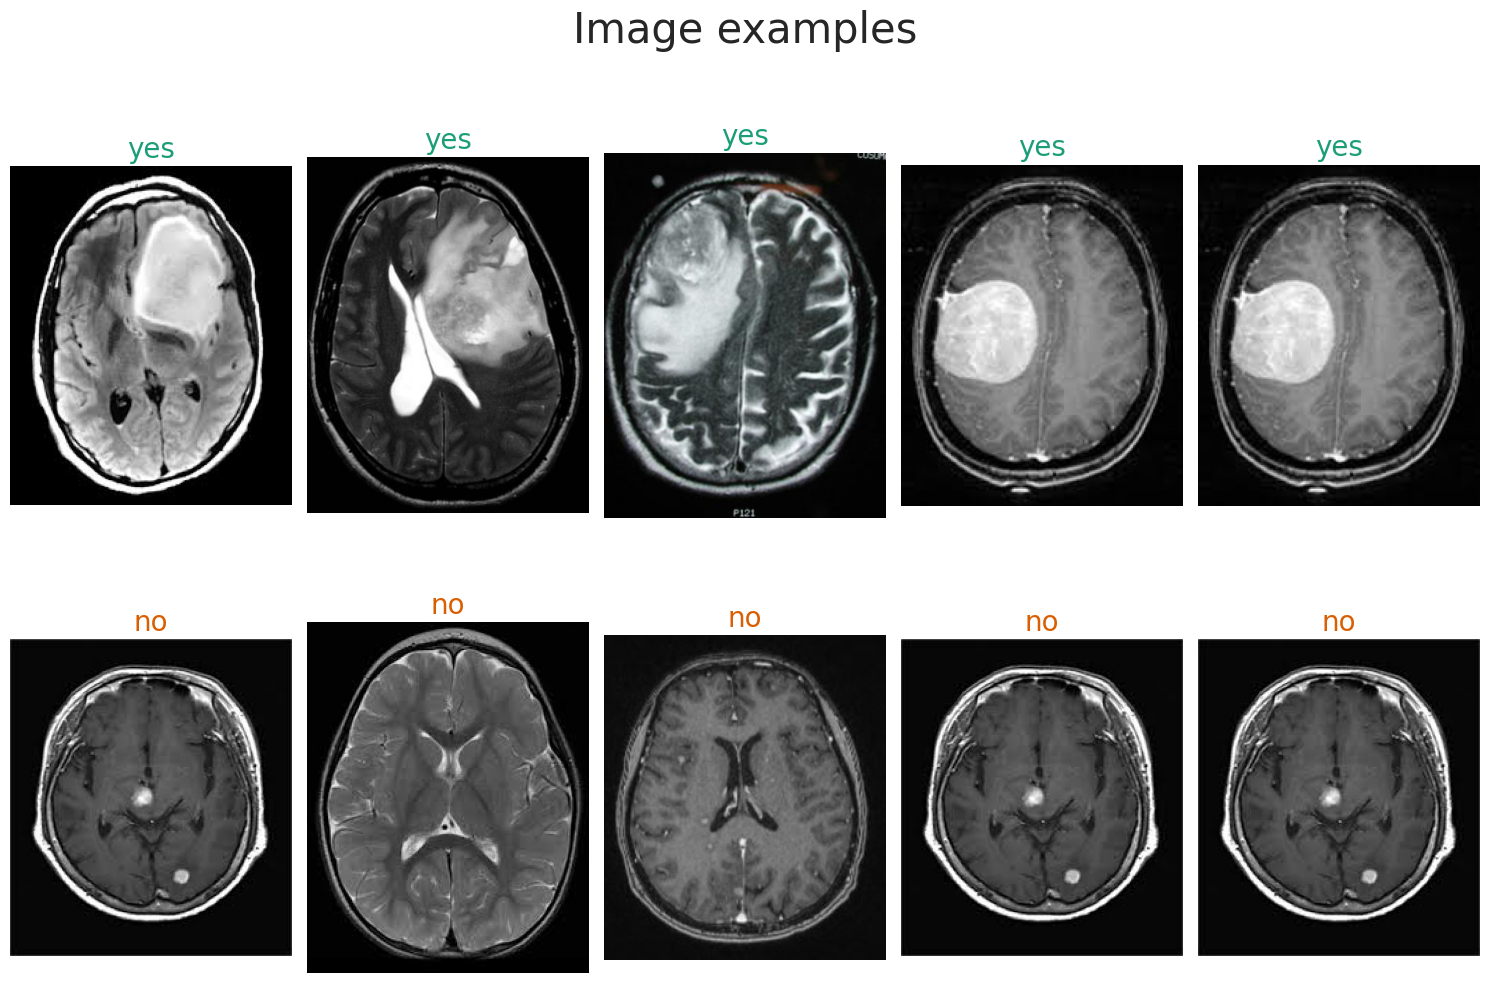

In [ ]:
show_example_grid(brain_tumor_train_path, brain_tumor_classes)

In [ ]:
# Define the image size
IMAGE_SIZE = 224

# Define the batch size
BATCH_SIZE = 32

INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

def get_generators(train_path: str, test_path: str, preprocessing_function, batch_size: int=BATCH_SIZE, image_shape=(IMAGE_SIZE, IMAGE_SIZE), class_mode: str='binary', validation_split: float=0.1, augment_training_data: bool=False):

  if augment_training_data:
    # Define the data generator for training data
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        rotation_range=20, # randomly rotate images by 20 degrees
        width_shift_range=0.2, # randomly shift images horizontally by 20%
        height_shift_range=0.2, # randomly shift images vertically by 20%
        shear_range=0.2, # randomly apply shearing transformations
        zoom_range=0.2, # randomly zoom in on images
        horizontal_flip=True, # randomly flip images horizontally
        vertical_flip=False, # randomly flip images vertically
        fill_mode='nearest', # fill any empty pixels with the nearest pixel value
        rescale=1. / 255,
        validation_split=validation_split
    )
  else:
    train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function, validation_split=validation_split)


  # Define the data generator for validation data
  test_datagen = keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=preprocessing_function
  )

  # Define the training data generator
  train_generator = train_datagen.flow_from_directory(
      train_path, # path to the training data directory
      target_size=image_shape, # resize images to (IMG_SIZE, IMG_SIZE)
      batch_size=batch_size, # set the batch size
      class_mode=class_mode, # set the class mode to binary classification
      shuffle=True,
      subset='training'
  )

  # Define the validation data generator
  val_generator = train_datagen.flow_from_directory(
      train_path, # path to the validation data directory
      target_size=image_shape, # resize images to (IMG_SIZE, IMG_SIZE)
      batch_size=batch_size, # set the batch size
      class_mode=class_mode, # set the class mode to binary classification
      shuffle=True,
      subset='validation'
  )

  test_generator = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=image_shape,
                                             batch_size=batch_size,
                                             class_mode=class_mode)

  return train_generator, val_generator, test_generator

In [ ]:
brain_tumor_train_data, brain_tumor_val_data, brain_tumor_test_data = get_generators(brain_tumor_train_path, brain_tumor_test_path, vgg16.preprocess_input, validation_split=0.25, augment_training_data=True)

Found 171 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


# Create the Model
Create a convolutional neural network (CNN) model for image classification.

In [ ]:
def get_custom_CNN():
  # Define the CNN model
  model = keras.Sequential([
      # First convolutional layer
      keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=INPUT_SHAPE),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      # Second convolutional layer
      keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      # Third convolutional layer
      keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      # Flatten the output from the convolutional layers
      keras.layers.Flatten(),
      # Add a fully connected layer with 512 hidden units and ReLU activation
      keras.layers.Dense(512, activation='relu'),
      # Add a dropout layer to prevent overfitting
      keras.layers.Dropout(0.5),
      # Add the output layer with sigmoid activation for binary classification
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile the model with binary cross-entropy loss and Adam optimizer
  return model

In [ ]:
model = get_custom_CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

# Compile the Model
Compile the CNN model with an appropriate loss function, optimizer, and metrics.

In [ ]:
metrics = {'accuracy': 'accuracy',
           'auc': AUC(name='auc'),
           'precision': Precision(name='precision'),
           'recall': Recall(name='recall')}

# Compile the CNN model with an appropriate loss function, optimizer, and metrics
def compile_model(model, loss='binary_crossentropy', optimizer='adam', num_classes: int=2):
    model.compile(loss=loss,
                  optimizer=optimizer, metrics=list(metrics.values()))
    return model

# Train the Model
Train the CNN model on the training data and validate it on the testing data.

In [ ]:
# Train the CNN model on the training data and validate it on the testing data
model = compile_model(model)

def fit_model(model, train_data, val_data, epochs: int=10):
  history = model.fit(
      train_data, # training data generator
      epochs=epochs, # number of epochs to train for
      validation_data=val_data # testing data generator
  )
  return history

NameError: ignored

In [ ]:
fit_model(model, brain_tumor_train_data, brain_tumor_val_data)

# Evaluate the Model
Evaluate the performance of the trained CNN model on the testing data.

In [ ]:
def evaluate_model(model, test_data):
  # Evaluate the performance of the trained CNN model on the testing data
  metrics_results = {}
  results = model.evaluate(test_data, batch_size=32)
  metrics_results['loss'] = results.pop(0)
  metrics_results.update({metric: result for metric, result in zip(metrics.keys(), results)})

  # Print the test loss and accuracy
  print('Test loss:', metrics_results['loss'])
  print('Test accuracy:', metrics_results['accuracy'])
  print('Test AUC:', metrics_results['auc'])

In [ ]:
evaluate_model(model, brain_tumor_test_data)

1/1 [==============================] - 0s 394ms/step - loss: 12.6744 - accuracy: 0.3846 - auc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00
[0.38461539149284363, 0.5, 0.0, 0.0]
Test loss: 12.674432754516602
Test accuracy: 0.38461539149284363
Test AUC: 0.5


## VGG Model

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential

model_dict = {
    ResNet50: resnet.preprocess_input,
    VGG16: vgg16.preprocess_input,
    VGG19: vgg19.preprocess_input,
    Xception: xception.preprocess_input,
    InceptionV3: inception_v3.preprocess_input,
    InceptionResNetV2: inception_resnet_v2.preprocess_input,
    MobileNet: mobilenet.preprocess_input,
    MobileNetV2: mobilenet_v2.preprocess_input,
    DenseNet121: densenet.preprocess_input,
    DenseNet169: densenet.preprocess_input,
    DenseNet201: densenet.preprocess_input,
    NASNetMobile: nasnet.preprocess_input,
    NASNetLarge: nasnet.preprocess_input,
    EfficientNetB0: efficientnet.preprocess_input
}

def get_binary_transfer_model(transfer_model, dropout_rate=0.5, loss='binary_crossentropy', optimizer='adam', image_shape=(IMAGE_SIZE, IMAGE_SIZE)):
  input_shape = (image_shape[0], image_shape[1], 3)
  base_model = transfer_model(input_shape=input_shape, weights='imagenet', include_top=False, classes=2)
  base_model.trainable = False
  inputs = keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = Dropout(dropout_rate)(x)
  outputs = Dense(1, activation = 'sigmoid')(x)
  model = Model(inputs, outputs)
  model.summary()
  model = compile_model(model, loss=loss, optimizer=optimizer)
  return model


def get_multiclass_transfer_model(transfer_model, num_classes: int, dropout_rate=0.5, loss='categorical_crossentropy', optimizer='adam', image_shape=(IMAGE_SIZE, IMAGE_SIZE)):
  input_shape = (image_shape[0], image_shape[1], 3)
  base_model = transfer_model(input_shape=input_shape, weights='imagenet', include_top=False)
  base_model.trainable = False
  inputs = keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = Dropout(dropout_rate)(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs, outputs)
  model.summary()
  model = compile_model(model, loss=loss, optimizer=optimizer, num_classes=num_classes)
  return model

In [ ]:
model = get_binary_transfer_model(VGG16)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_____________________________________________

In [ ]:
def train_model(model, train_data, val_data, epochs: int=10, filepath: str='', patience: int=10):
  if filepath:
    checkpoint = ModelCheckpoint(filepath=filepath, verbose=2, save_best_only=True)
    earlystopping = EarlyStopping(
    monitor="val_loss",
    patience=patience,
    restore_best_weights=True,
    start_from_epoch=5,
)
    callbacks = [checkpoint, earlystopping]
  else:
    callbacks = []
  start = datetime.now()

  model_history=model.fit(
                        train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        steps_per_epoch=len(train_data),
                        validation_steps=len(val_data),
                        callbacks=callbacks,
                        verbose=2)


  duration = datetime.now() - start
  print("Training completed in time: ", duration)
  return model_history

In [ ]:
model_history = train_model(model, brain_tumor_train_data, brain_tumor_val_data, filepath='brain_vgg16.h5', epochs=50)

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.11562, saving model to brain_vgg16.h5
6/6 - 31s - loss: 1.4818 - accuracy: 0.5673 - auc: 0.5365 - precision: 0.6084 - recall: 0.8286 - val_loss: 1.1156 - val_accuracy: 0.6071 - val_auc: 0.6049 - val_precision: 0.6875 - val_recall: 0.6471 - 31s/epoch - 5s/step
Epoch 2/50

Epoch 2: val_loss did not improve from 1.11562
6/6 - 9s - loss: 1.2897 - accuracy: 0.5146 - auc: 0.5168 - precision: 0.6122 - recall: 0.5714 - val_loss: 1.3620 - val_accuracy: 0.4107 - val_auc: 0.5167 - val_precision: 0.5217 - val_recall: 0.3529 - 9s/epoch - 2s/step
Epoch 3/50

Epoch 3: val_loss improved from 1.11562 to 0.98787, saving model to brain_vgg16.h5
6/6 - 4s - loss: 1.0611 - accuracy: 0.5439 - auc: 0.5541 - precision: 0.6364 - recall: 0.6000 - val_loss: 0.9879 - val_accuracy: 0.5357 - val_auc: 0.5729 - val_precision: 0.6053 - val_recall: 0.6765 - 4s/epoch - 720ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.98787 to 0.90913, saving model to brain_vgg1

In [ ]:
def get_predictions(model, test_gen, binary: bool=False):
    if binary:
      y_pred = np.where(model.predict(test_gen) >= 0.5, 1, 0)
      y_true = test_gen.labels
      return y_pred, y_true

    data, y_true = test_gen.next()
    y_pred_ = model.predict(data)
    y_pred = []
    for i in range(y_pred_.shape[0]):
      y_pred.append(np.argmax(y_pred_[i]))

    y_true = np.argmax(y_true, axis=1)

    return y_true, y_pred

def save_model_history(model_history, filename: str):
  data = DataFrame(model_history.history)
  data.to_csv(filename)

def plot_confusion_matrix(y_true, y_pred, classes):
  cm = confusion_matrix(y_true, y_pred, labels=[i for i in range(len(classes))])
  ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

  # Set labels, title, and ticks
  ax.set_xlabel('True labels')
  ax.set_ylabel('Predicted labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes, rotation=30, ha='right')
  ax.yaxis.set_ticklabels(classes, rotation=0)
  plt.show()

def melt_metrics(data):
  data.index += 1
  data.reset_index(inplace=True)
  data.rename(columns={'index': 'epochs'}, inplace=True)

  melted = data.melt(id_vars='epochs', var_name='metric', value_name='value')
  dataset_mapping = {
      'accuracy': 'training',
      'auc': 'training',
      'loss': 'training',
      'precision': 'training',
      'recall': 'training',
      'categorical_accuracy': 'training',
      'val_accuracy': 'validation',
      'val_auc': 'validation',
      'val_loss': 'validation',
      'val_categorical_accuracy': 'validation',
      'val_precision': 'validation',
      'val_recall': 'validation',
  }

  category_mapping = {
      'accuracy': 'accuracy',
      'auc': 'auc',
      'loss': 'loss',
      'val_accuracy': 'accuracy',
      'val_auc': 'auc',
      'val_loss': 'loss',
      'precision': 'precision',
      'recall': 'recall',
      'categorical_accuracy': 'categorical_accuracy',
      'val_categorical_accuracy': 'categorical_accuracy',
      'val_precision': 'precision',
      'val_recall': 'recall',
      }

  melted['dataset'] = melted['metric'].map(dataset_mapping)
  melted['category'] = melted['metric'].map(category_mapping)
  return melted

def plot_metrics_lines(model_history):
  if isinstance(model_history, DataFrame):
    data = model_history
  else:
    data = DataFrame(model_history.history)

  sns.set_style("dark")
  accuracies_columns = ['accuracy', 'auc', 'val_accuracy', 'val_auc']
  losses_columns = ['loss', 'val_loss']
  metrics_columns = ['precision', 'recall', 'val_precision', 'val_recall']
  ordered_data = melt_metrics(data[accuracies_columns + metrics_columns + losses_columns].copy())
  g = sns.FacetGrid(ordered_data, col='category', hue='dataset', col_wrap=2, aspect=1.5, height=3, palette='mako_r', sharey=False)
  g.map(sns.lineplot, 'epochs', 'value')
  g.set_titles(col_template="{col_name}")

  pal = sns.color_palette("mako_r")
  color =  pal.as_hex()[-1]
  for i, ax in enumerate(g.axes.flat):
    if i < len(g.axes.flat) - 1:
      max_val = ax.lines[1].get_ydata().max()
      ax.axhline(max_val, ls='--', color=color, alpha=0.5)
      ax.text(1.0, max_val, f"{max_val:.2f}", ha='left', va='bottom', color=color)

    else:
        min_val = ax.lines[1].get_ydata().min()
        ax.axhline(min_val, ls='--', color=color)
        ax.text(0.95, min_val, f"{min_val:.2f}", ha='left', va='bottom', color=color)

  # Add legend
  g.add_legend()

  # Adjust the spacing between subplots
  plt.tight_layout()
  plt.suptitle('Model Training Metrics')
  plt.show()


def plot_experiment_info(model_history, y_true, y_pred, classes):
  plot_metrics_lines(model_history)
  plot_confusion_matrix(y_true, y_pred, classes)

In [ ]:
def run_experiment_pipeline(transfer_model, train_path: str, test_path: str, model_name: str="", epochs: int=10, validation_split=0.25, augment_training_data=False, num_classes: int=2, optimizer='adam', image_shape=(IMAGE_SIZE, IMAGE_SIZE), plot_results: bool=True):
  train_data, val_data, test_data = get_generators(train_path, test_path, model_dict[transfer_model], validation_split=validation_split, augment_training_data=augment_training_data)
  if num_classes==2:
    model = get_binary_transfer_model(transfer_model, loss='binary_crossentropy', optimizer=optimizer, image_shape=image_shape)
  else:
    model = get_multiclass_transfer_model(transfer_model, num_classes, loss='categorical_crossentropy', optimizer=optimizer, image_shape=image_shape)

  print(transfer_model.__name__)
  model_name = f'{model_name}.h5' if model_name else ''
  model_history = train_model(model, train_data, val_data, filepath=model_name, epochs=epochs)

  if plot_results:
    plot_metrics_lines(model_history)

  return model, model_history

def run_training_pipeline(transfer_model, train_path: str, test_path: str, classes, model=None, model_name: str="", frozen_epochs: int=10, unfrozen_epochs: int=10, unfrozen_learning_rate: float=1e-5, validation_split=0.25, augment_training_data=False, optimizer='adam', image_shape=(IMAGE_SIZE, IMAGE_SIZE), plot_results: bool=True, patience: int=10):
  num_classes = len(classes)
  binary = num_classes == 2
  class_mode = 'binary' if binary else 'categorical'

  train_data, val_data, test_data = get_generators(train_path, test_path, model_dict.get(transfer_model, lambda x: x), validation_split=validation_split, augment_training_data=augment_training_data, class_mode=class_mode, image_shape=image_shape)
  if model is None:
    print(transfer_model.__name__)
    if num_classes==2:
      frozen_model = get_binary_transfer_model(transfer_model, loss='binary_crossentropy', optimizer=optimizer, image_shape=image_shape)
    else:
      frozen_model = get_multiclass_transfer_model(transfer_model, num_classes, loss='categorical_crossentropy', optimizer=optimizer, image_shape=image_shape)
  else:
    frozen_model = model

  filepath = f'{model_name}.h5' if model_name else ''
  frozen_model_history = train_model(frozen_model, train_data, val_data, filepath=filepath, epochs=frozen_epochs, patience=patience)
  evaluate_model(frozen_model, test_data)

  if plot_results:
    y_true, y_pred = get_predictions(frozen_model, test_data, binary)
    plot_experiment_info(frozen_model_history, y_true, y_pred, classes)

  frozen_model.layers[1].trainable = True
  frozen_model.summary()
  adam = optimizers.Adam(unfrozen_learning_rate)
  unfrozen_model = compile_model(frozen_model, optimizer=adam)
  filepath = f'{model_name}_unfrozen.h5'
  unfrozen_model_history = train_model(unfrozen_model, train_data, val_data, filepath=filepath, epochs=unfrozen_epochs, patience=patience)
  evaluate_model(unfrozen_model, test_data)

  if plot_results:
    y_true, y_pred = get_predictions(unfrozen_model, test_data, binary)
    plot_experiment_info(unfrozen_model_history, y_true, y_pred, classes)

  return unfrozen_model, unfrozen_model_history

def compare_models(train_path: str, test_path: str, models: list[str] = list(model_dict.keys()), epochs: int=10):
  results = DataFrame()
  trained_models = {}
  for model in models:
    trained_model, model_history = run_experiment_pipeline(model, train_path, test_path, epochs=epochs)
    result = DataFrame(model_history.history)
    result['model'] = model.__name__
    results = concat([results, result])
    trained_models[model.__name__] = trained_model

  return trained_models, results

In [ ]:
def melt_models_comparison_results(results):
  columns_order = ['accuracy', 'val_accuracy', 'auc', 'val_auc', 'precision', 'val_precision', 'recall', 'val_recall', 'loss', 'val_loss', 'model']
  data = results[columns_order].copy()
  data = data.reset_index().rename(columns={'index': 'epochs'})
  melted = data.melt(id_vars=['epochs', 'model'], var_name='metric', value_name='value')
  return melted

def plot_models_comparison(results, classification_name: str):
  melted = melt_models_comparison_results(results)
  g = sns.FacetGrid(melted, col='metric', hue='model', col_wrap=2, aspect=1.5, height=3, palette=cc.glasbey, sharey=False)
  g.map(sns.lineplot, 'epochs', 'value', linewidth=2.5)
  g.set_titles(col_template="{col_name}")

   # Add legend
  g.add_legend(bbox_to_anchor=(1.02, 1), loc='upper left')

  color = 'b'
  for i, ax in enumerate(g.axes.flat):
    if i < len(g.axes.flat) - 2:
      max_val = max([y.get_ydata().max() for y in ax.lines])
      lines_with_max = [i for i, y in enumerate(ax.lines) if y.get_ydata().max() == max_val]
      legend_labels = [ax.get_legend_handles_labels()[1][i] for i in lines_with_max]
      best_model = legend_labels[0]
      ax.axhline(max_val, ls='--', color=color, alpha=0.5)
      ax.text(0.25, max_val, f"{best_model}: {max_val:.2f}", ha='left', va='bottom', color=color)

      for i, line in enumerate(ax.lines):
        if i in lines_with_max:
          line.set_linewidth(2.5)
        else:
          line.set_linewidth(1.0)
          line.set_alpha(0.60)

    else:
        min_val = min([y.get_ydata().min() for y in ax.lines])
        lines_with_min = [i for i, y in enumerate(ax.lines) if y.get_ydata().min() == min_val]
        legend_labels = [ax.get_legend_handles_labels()[1][i] for i in lines_with_min]
        best_model = legend_labels[0]
        ax.axhline(min_val, ls='--', color=color)
        ax.text(0.25, min_val, f"{best_model}: {min_val:.2f}", ha='left', va='top', color=color)

        for i, line in enumerate(ax.lines):
          if i in lines_with_min:
            line.set_linewidth(2.5)
            line.set_alpha(1.0)
          else:
            line.set_linewidth(1.0)
            line.set_alpha(0.60)

  # Adjust the spacing between subplots
  plt.suptitle(f'Model Comparison for {classification_name}')
  plt.tight_layout()
  plt.show()

In [ ]:
plot_metrics_lines(model_history)

In [ ]:
y_true, y_pred = get_predictions(model, brain_tumor_test_data, binary=True)
plot_confusion_matrix(y_true, y_pred, brain_tumor_classes)

In [ ]:
model.layers[1].trainable = True
model.summary()

adam = optimizers.Adam(1e-5)
model = compile_model(model, adam)

In [ ]:
model_history = train_model(model, brain_tumor_train_data, brain_tumor_val_data)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.67914, saving model to mymodel.h5
7/7 - 11s - loss: 186.4411 - accuracy: 0.5243 - auc_6: 0.5293 - val_loss: 0.6791 - val_accuracy: 0.6190 - val_auc_6: 0.6779 - 11s/epoch - 2s/step
Epoch 2/10

Epoch 2: val_loss improved from 0.67914 to 0.63894, saving model to mymodel.h5
7/7 - 5s - loss: 5.4397 - accuracy: 0.5291 - auc_6: 0.4873 - val_loss: 0.6389 - val_accuracy: 0.6190 - val_auc_6: 0.7740 - 5s/epoch - 686ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from 0.63894
7/7 - 5s - loss: 0.8326 - accuracy: 0.4951 - auc_6: 0.4924 - val_loss: 0.6933 - val_accuracy: 0.3810 - val_auc_6: 0.5000 - 5s/epoch - 755ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.63894
7/7 - 4s - loss: 0.7254 - accuracy: 0.4660 - auc_6: 0.4826 - val_loss: 0.6931 - val_accuracy: 0.6190 - val_auc_6: 0.5000 - 4s/epoch - 628ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.63894
7/7 - 4s - loss: 0.6930 - accuracy: 0.6117 - auc_6: 0.5040 - val

In [ ]:
plot_metrics_lines(model_history)

In [ ]:
y_true, y_pred = get_predictions(model, brain_tumor_test_data, binary=True)
plot_confusion_matrix(y_true, y_pred, brain_tumor_classes)

Found 206 images belonging to 2 classes.
Found 21 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
VGG16
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                

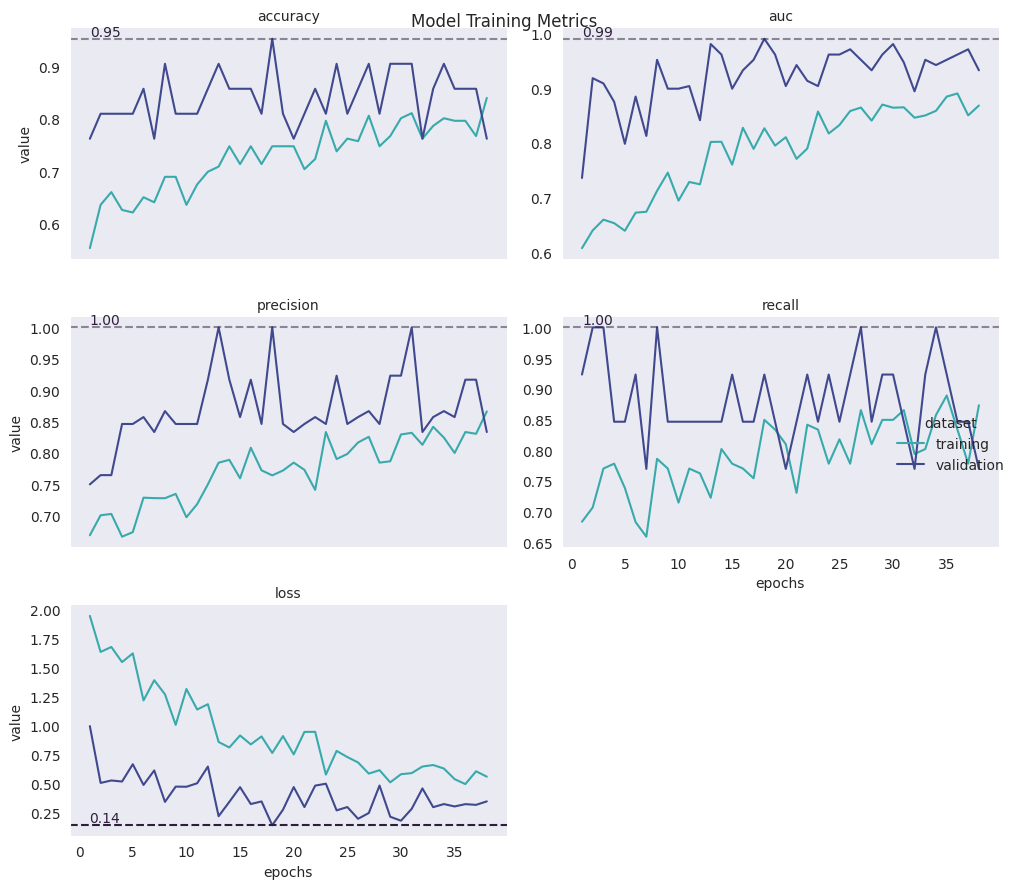

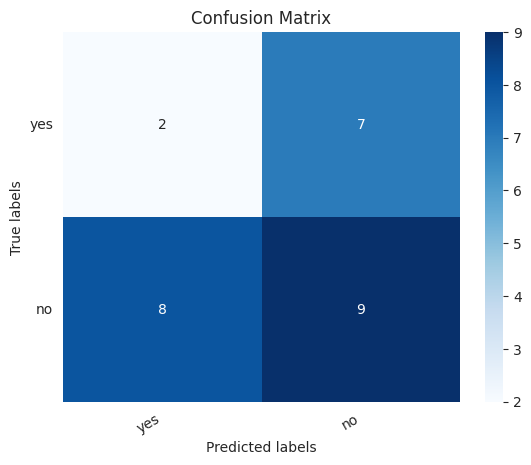

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_______________________________________________

1/1 [==============================] - 0s 265ms/step


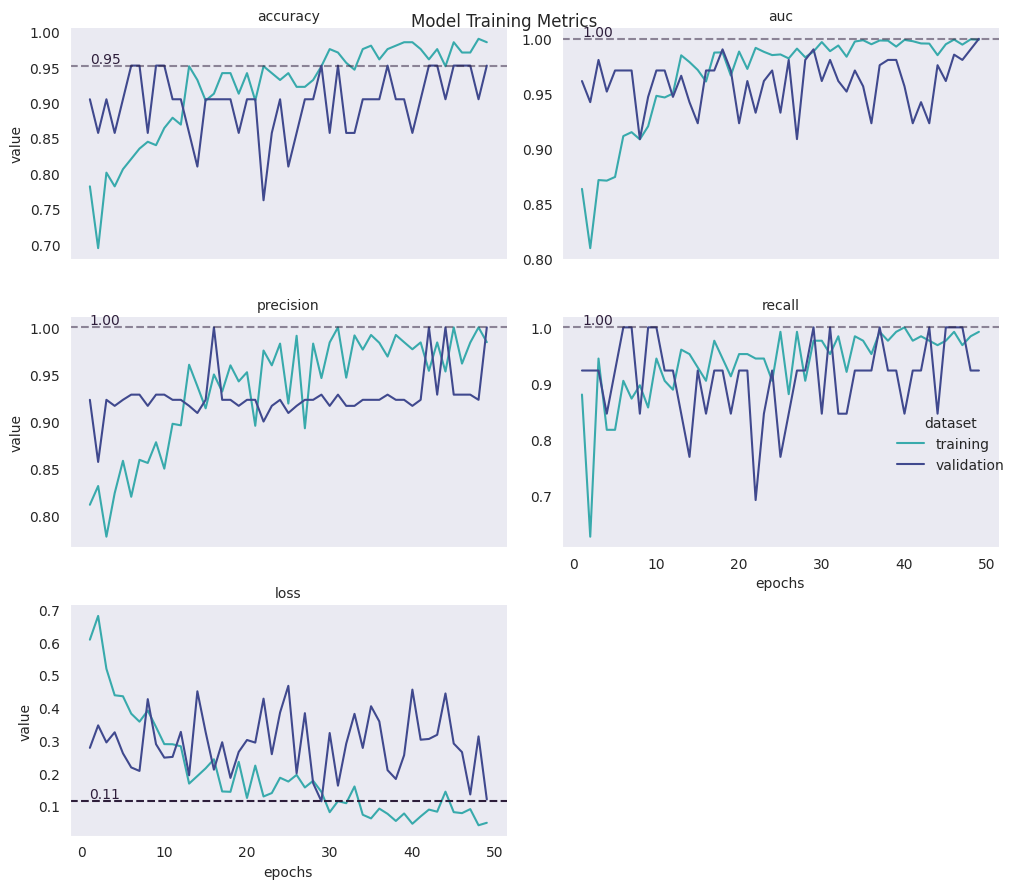

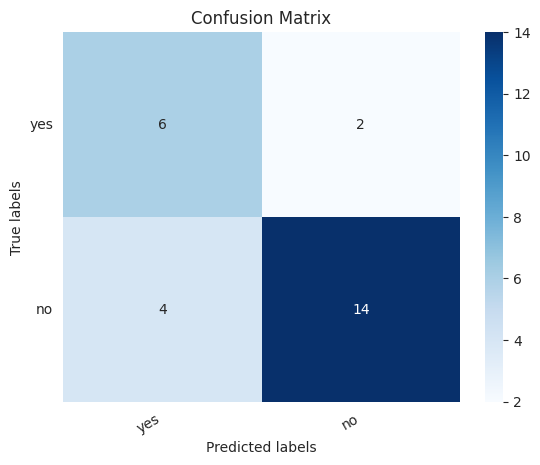

In [ ]:
trained_model, model_history = run_training_pipeline(VGG16, brain_tumor_train_path, brain_tumor_test_path, classes=brain_tumor_classes, model_name="brain_tumor_vgg16", frozen_epochs=150, unfrozen_epochs=50, validation_split=0.1, augment_training_data=True, plot_results=True)

# Alzheimer

In [ ]:
alzheimer_dir = join(root_dir, "alzheimer")
alzheimer_train_path = join(alzheimer_dir, 'AugmentedAlzheimerDataset')
alzheimer_test_path = join(alzheimer_dir, 'OriginalDataset')
alzheimer_classes = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

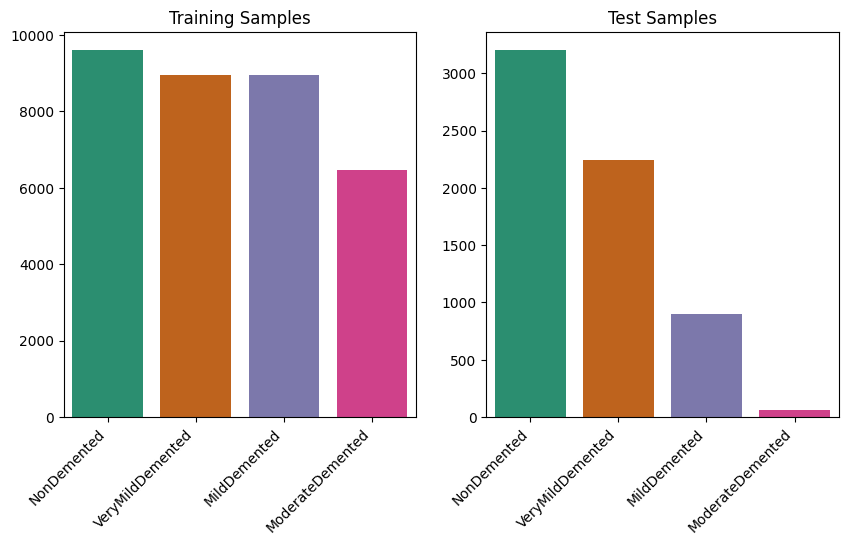

In [ ]:
plot_dataset_balance(alzheimer_train_path, alzheimer_test_path, alzheimer_classes)

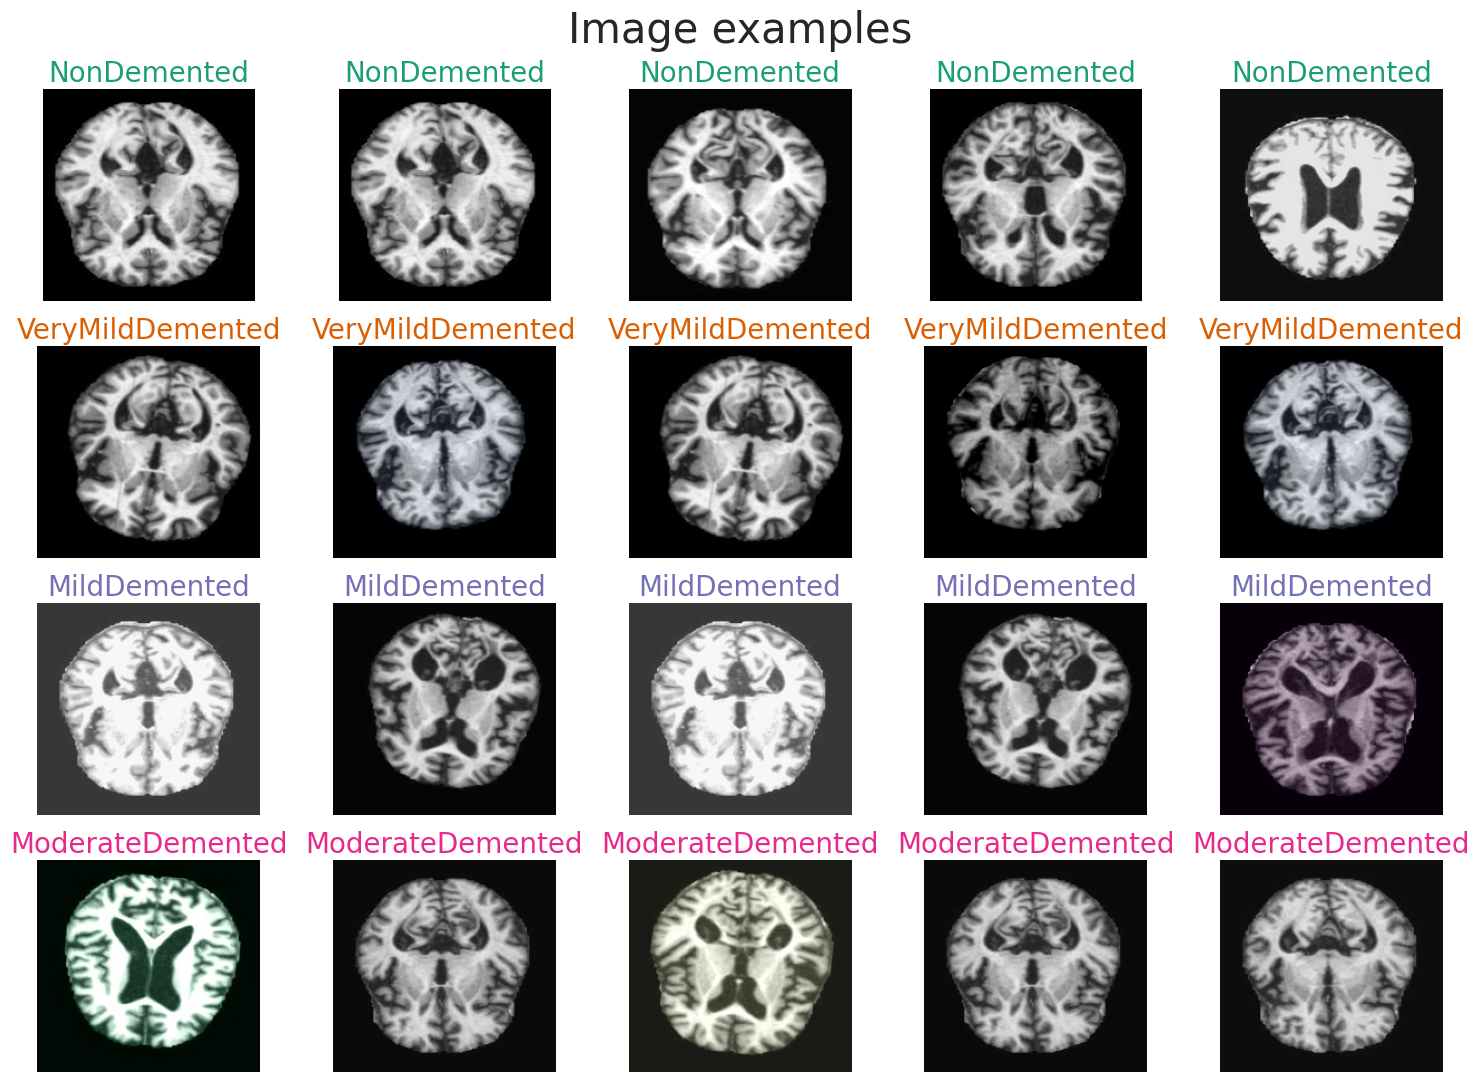

In [ ]:
show_example_grid(alzheimer_train_path, alzheimer_classes)

In [ ]:
alzheimer_train_data, alzheimer_val_data, alzheimer_test_data = get_generators(alzheimer_train_path, alzheimer_test_path, resnet.preprocess_input, class_mode='categorical', augment_training_data=False)

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [ ]:
model = get_multiclass_transfer_model(ResNet50, len(alzheimer_classes))

94765736/94765736 [==============================] - 5s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
model_history = train_model(model, alzheimer_train_data, alzheimer_val_data, epochs=10, filepath='alzheimer_resnet.h5')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.31313, saving model to alzheimer_resnet.h5
956/956 - 120s - loss: 0.8569 - accuracy: 0.7307 - auc_7: 0.8747 - val_loss: 0.3131 - val_accuracy: 0.8705 - val_auc_7: 0.9521 - 120s/epoch - 125ms/step
Epoch 2/10

Epoch 2: val_loss did not improve from 0.31313
956/956 - 110s - loss: 0.4031 - accuracy: 0.8815 - auc_7: 0.9534 - val_loss: 0.3850 - val_accuracy: 0.8970 - val_auc_7: 0.9638 - 110s/epoch - 115ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from 0.31313
956/956 - 111s - loss: 0.2781 - accuracy: 0.9267 - auc_7: 0.9741 - val_loss: 0.4662 - val_accuracy: 0.8832 - val_auc_7: 0.9501 - 111s/epoch - 116ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.31313
956/956 - 111s - loss: 0.2024 - accuracy: 0.9540 - auc_7: 0.9853 - val_loss: 0.8016 - val_accuracy: 0.8879 - val_auc_7: 0.9500 - 111s/epoch - 116ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.31313
956/956 - 120s - loss: 0.1971 - accuracy: 0.9582 - auc_7: 0.9850 - 

In [ ]:
plot_metrics_lines(model_history)

In [ ]:
y_true, y_pred = get_predictions(model, alzheimer_test_data, binary=False)
plot_confusion_matrix(y_true, y_pred, alzheimer_classes)

In [ ]:
evaluate_model(model, alzheimer_test_data)

In [ ]:
model = load_model("alzheimer_vgg16.h5")
model.layers[1].trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = optimizers.Adam(1e-5)
model = compile_model(model, loss='categorical cross-entropy', optimizer=adam)

In [ ]:
model_history = train_model(model, alzheimer_train_data, alzheimer_val_data, 30)

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 0.5511 - accuracy: 0.7350
Epoch 1: val_loss improved from inf to 0.73808, saving model to mymodel2.h5
44/44 [==============================] - 38s 757ms/step - loss: 0.5511 - accuracy: 0.7350 - val_loss: 0.7381 - val_accuracy: 0.6500
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.8021
Epoch 2: val_loss did not improve from 0.73808
44/44 [==============================] - 25s 566ms/step - loss: 0.4227 - accuracy: 0.8021 - val_loss: 0.8156 - val_accuracy: 0.6250
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.8200
Epoch 3: val_loss improved from 0.73808 to 0.61696, saving model to mymodel2.h5
44/44 [==============================] - 32s 718ms/step - loss: 0.3911 - accuracy: 0.8200 - val_loss: 0.6170 - val_accuracy: 0.7375
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8521
Epoch 4: val_loss did not

In [ ]:
plot_metrics_lines(model_history)

In [ ]:
y_true, y_pred = get_predictions(model, alzheimer_test_data, binary=False)
plot_confusion_matrix(y_true, y_pred, alzheimer_classes)

In [ ]:
IMAGE_SHAPE = (176, 208)

In [ ]:
alzheimer_train_data, alzheimer_val_data, alzheimer_test_data = get_generators(alzheimer_train_path, alzheimer_test_path, vgg19.preprocess_input, image_shape=IMAGE_SHAPE, class_mode='categorical', augment_training_data=False)

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [ ]:
model = get_multiclass_transfer_model(VGG19, len(alzheimer_classes), image_shape=IMAGE_SHAPE)

80134624/80134624 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                            

In [ ]:
model_history = train_model(model, alzheimer_train_data, alzheimer_val_data, epochs=5, filepath='alzheimer_vgg19.h5')

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.47362, saving model to alzheimer_vgg19.h5
956/956 - 140s - loss: 0.7712 - accuracy: 0.7313 - auc: 0.8759 - precision: 0.7333 - recall: 0.7302 - val_loss: 0.4736 - val_accuracy: 0.8134 - val_auc: 0.9231 - val_precision: 0.8145 - val_recall: 0.8117 - 140s/epoch - 147ms/step
Epoch 2/5

Epoch 2: val_loss did not improve from 0.47362
956/956 - 134s - loss: 0.4475 - accuracy: 0.8492 - auc: 0.9394 - precision: 0.8499 - recall: 0.8484 - val_loss: 0.5266 - val_accuracy: 0.8437 - val_auc: 0.9339 - val_precision: 0.8437 - val_recall: 0.8437 - 134s/epoch - 140ms/step
Epoch 3/5

Epoch 3: val_loss did not improve from 0.47362
956/956 - 130s - loss: 0.4494 - accuracy: 0.8672 - auc: 0.9453 - precision: 0.8678 - recall: 0.8669 - val_loss: 0.5887 - val_accuracy: 0.8340 - val_auc: 0.9246 - val_precision: 0.8340 - val_recall: 0.8337 - 130s/epoch - 136ms/step
Epoch 4/5

Epoch 4: val_loss did not improve from 0.47362
956/956 - 129s - loss: 0.4193 - accuracy: 0.8884 

In [ ]:
plot_metrics_lines(model_history)

In [ ]:
y_true, y_pred = get_predictions(model, alzheimer_test_data, binary=False)
plot_confusion_matrix(y_true, y_pred, alzheimer_classes)

In [ ]:
adam = optimizers.Adam(1e-5)
model = compile_model(model, loss='categorical cross-entropy', optimizer=adam)

In [ ]:
model_history = train_model(model, alzheimer_train_data, alzheimer_val_data, epochs=5, filepath='alzheimer_vgg19.h5')

In [ ]:
plot_metrics_lines(model_history)

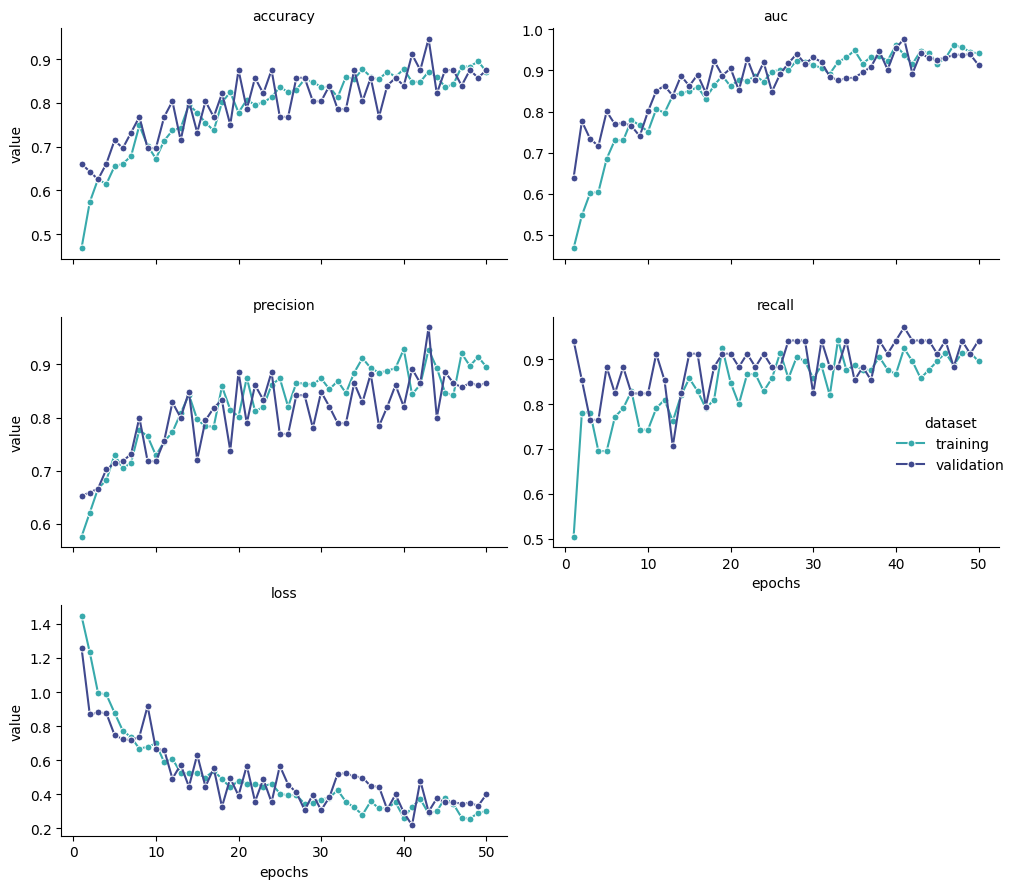

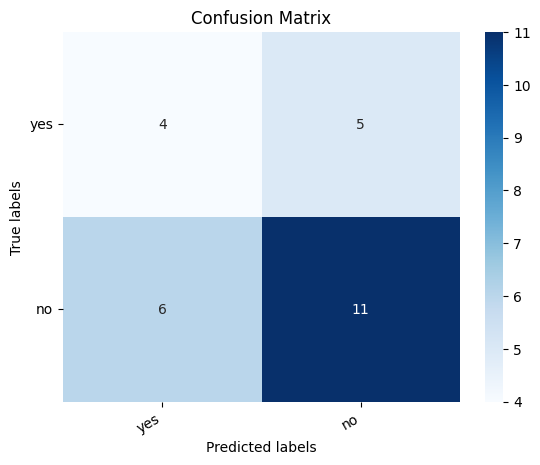

In [ ]:
plot_experiment_info(model_history, y_true, y_pred, brain_tumor_classes)

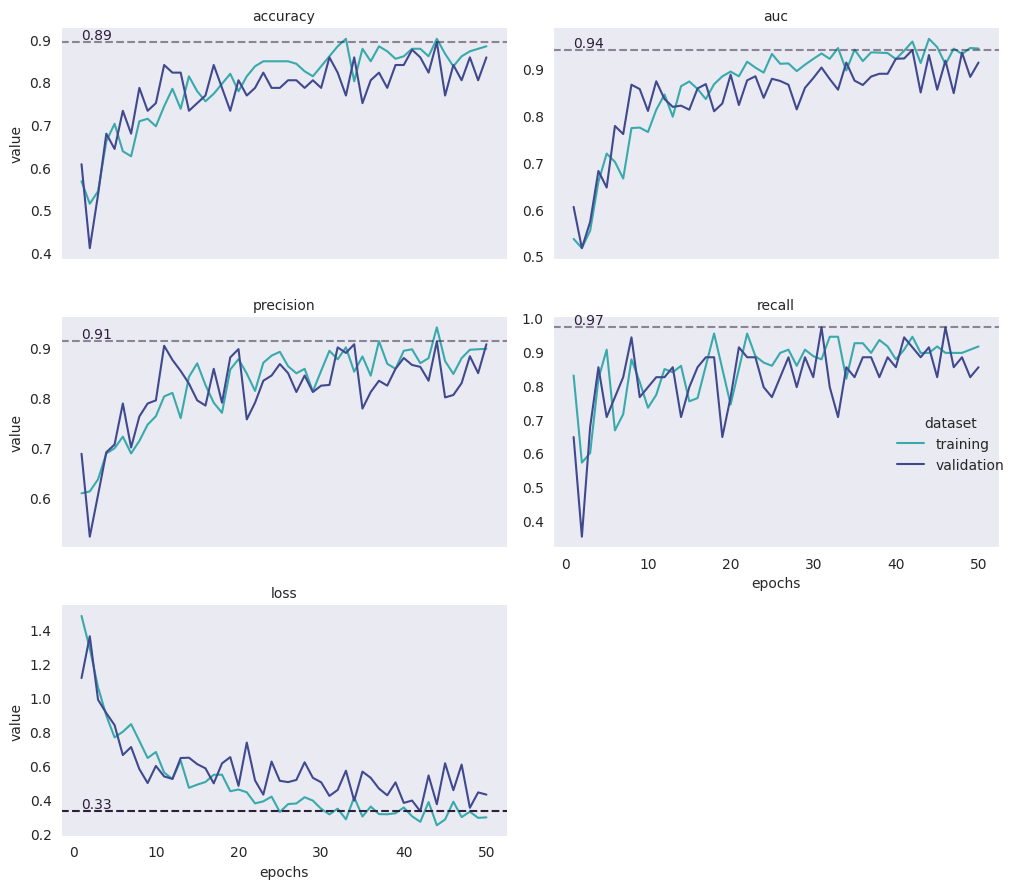

In [ ]:
plot_metrics_lines(model_history)

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
VGG19
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 5, 6, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                          

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.38786, saving model to alzheimer_vgg19.h5
956/956 - 132s - loss: 0.7855 - accuracy: 0.4476 - auc: 0.7281 - precision: 0.4977 - recall: 0.4301 - val_loss: 0.3879 - val_accuracy: 0.6595 - val_auc: 0.8829 - val_precision: 0.7502 - val_recall: 0.4994 - 132s/epoch - 138ms/step
Epoch 2/150

Epoch 2: val_loss improved from 0.38786 to 0.38004, saving model to alzheimer_vgg19.h5
956/956 - 130s - loss: 0.4510 - accuracy: 0.5411 - auc: 0.8062 - precision: 0.5976 - recall: 0.4538 - val_loss: 0.3800 - val_accuracy: 0.6716 - val_auc: 0.8934 - val_precision: 0.7596 - val_recall: 0.5132 - 130s/epoch - 136ms/step
Epoch 3/150

Epoch 3: val_loss did not improve from 0.38004
956/956 - 130s - loss: 0.4423 - accuracy: 0.5526 - auc: 0.8156 - precision: 0.6035 - recall: 0.4693 - val_loss: 0.3803 - val_accuracy: 0.6339 - val_auc: 0.8832 - val_precision: 0.7112 - val_recall: 0.5029 - 130s/epoch - 136ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.38004 to 0.37069

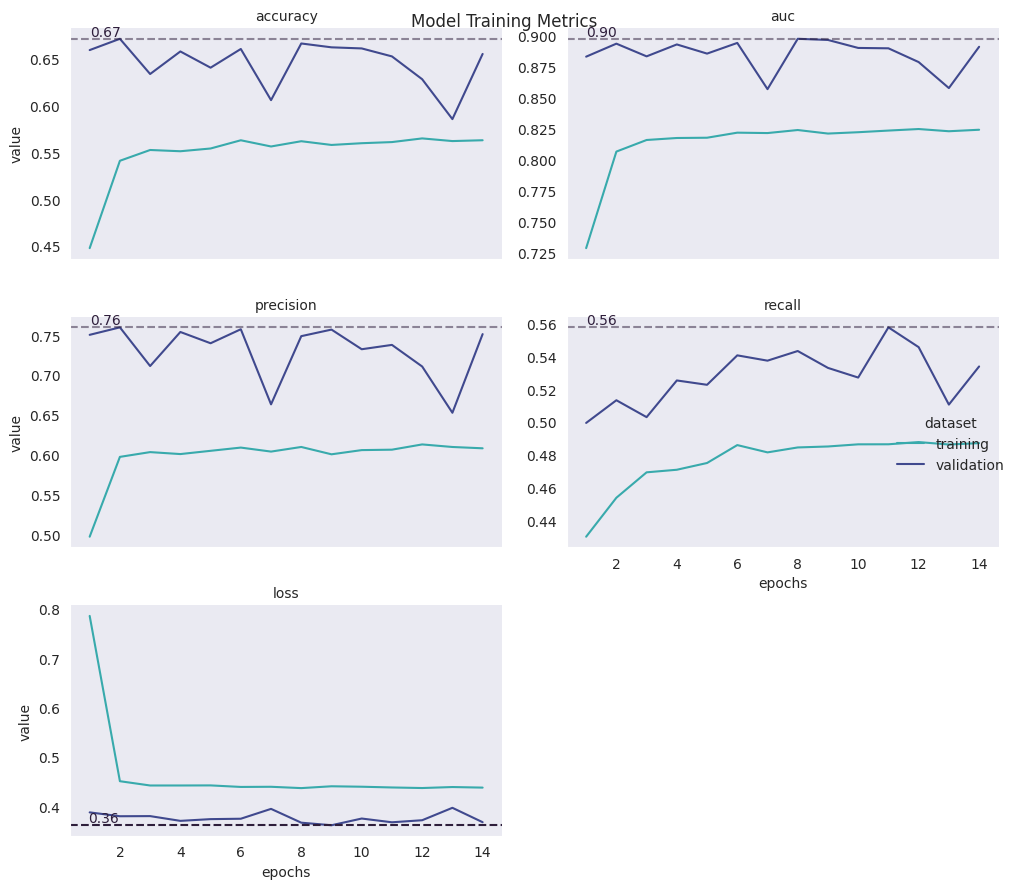

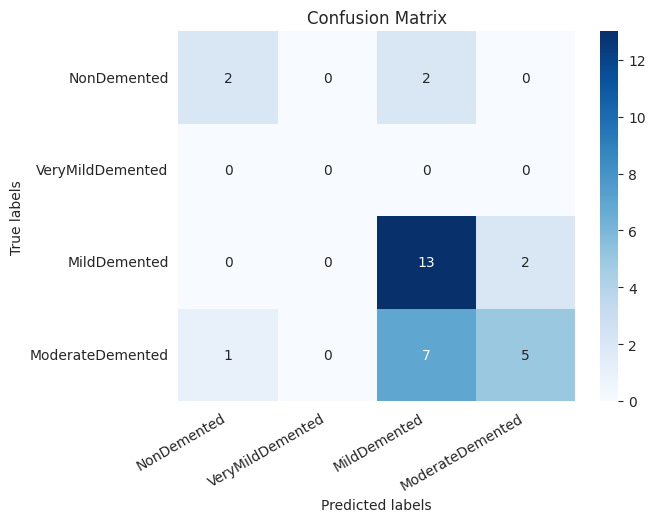

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 5, 6, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 20,026,436
Trainable params: 20,026,436
Non-trainable params: 0
_______________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.16130, saving model to alzheimer_vgg19_unfrozen.h5
956/956 - 382s - loss: 0.2988 - accuracy: 0.7200 - auc: 0.9130 - precision: 0.7325 - recall: 0.6408 - val_loss: 0.1613 - val_accuracy: 0.8902 - val_auc: 0.9867 - val_precision: 0.9011 - val_recall: 0.8770 - 382s/epoch - 399ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.16130 to 0.07204, saving model to alzheimer_vgg19_unfrozen.h5
956/956 - 377s - loss: 0.1412 - accuracy: 0.8962 - auc: 0.9858 - precision: 0.9040 - recall: 0.8884 - val_loss: 0.0720 - val_accuracy: 0.9520 - val_auc: 0.9959 - val_precision: 0.9531 - val_recall: 0.9517 - 377s/epoch - 394ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.07204 to 0.02948, saving model to alzheimer_vgg19_unfrozen.h5
956/956 - 377s - loss: 0.0589 - accuracy: 0.9663 - auc: 0.9973 - precision: 0.9677 - recall: 0.9649 - val_loss: 0.0295 - val_accuracy: 0.9847 - val_auc: 0.9988 - val_precision: 0.9853 - val_recall: 0.9838 - 377s/epoch - 394ms/ste

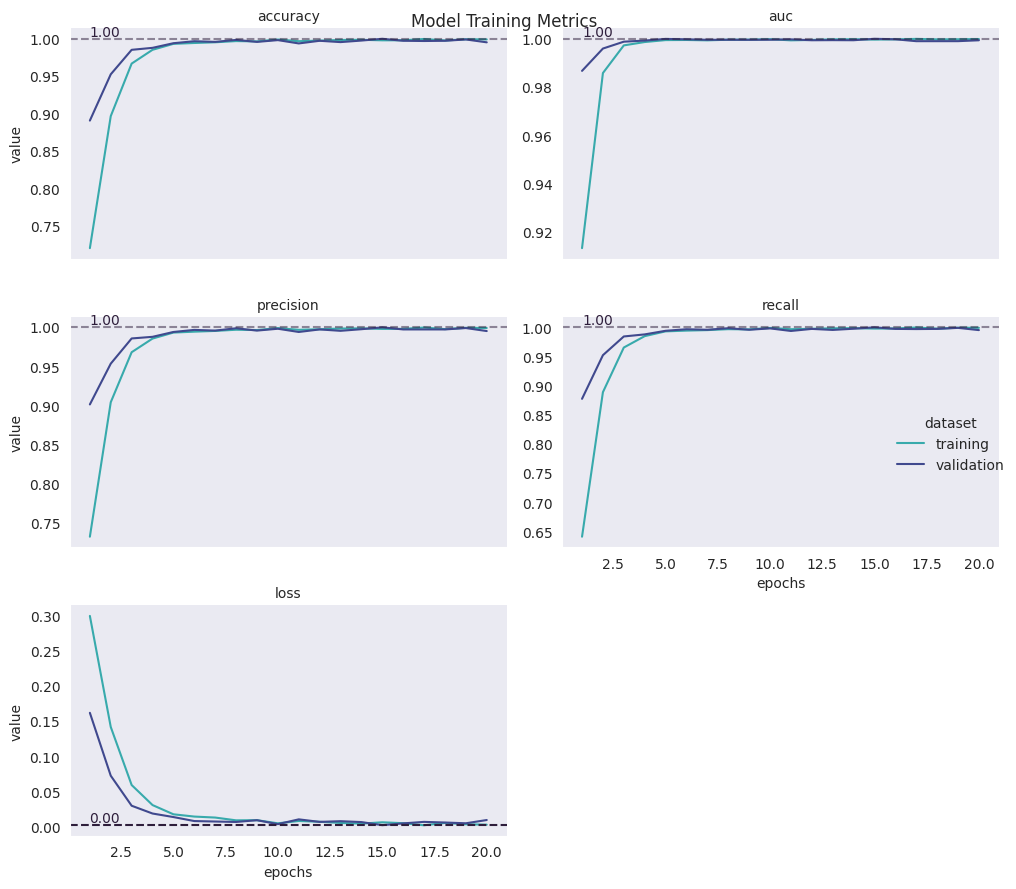

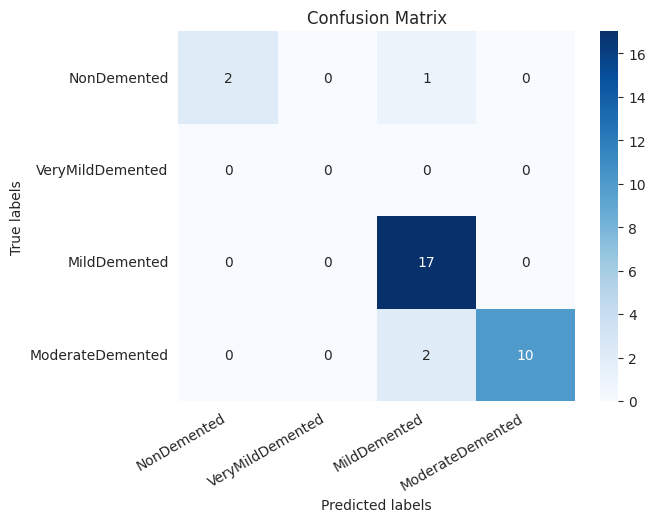

In [ ]:
trained_model, model_history = run_training_pipeline(VGG19, alzheimer_train_path, alzheimer_test_path, classes=alzheimer_classes, model_name="alzheimer_vgg19", frozen_epochs=150, unfrozen_epochs=50, validation_split=0.1, augment_training_data=False, plot_results=True, patience=5, image_shape=(176, 208))

In [ ]:
evaluate_model(trained_model, alzheimer_test_data)

200/200 [==============================] - 27s 134ms/step - loss: 0.3526 - accuracy: 0.8842 - auc: 0.9465 - precision: 0.8846 - recall: 0.8839
Test loss: 0.35256481170654297
Test accuracy: 0.8842187523841858
Test AUC: 0.9465396404266357


200/200 [==============================] - 24s 122ms/step


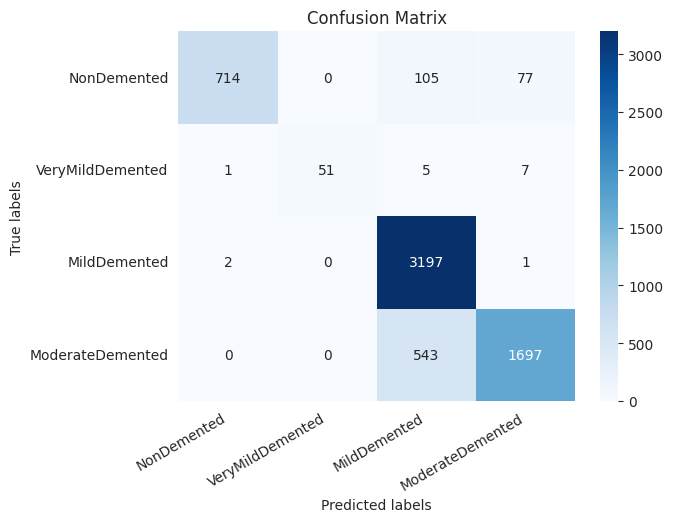

In [ ]:
y_true, y_pred = get_predictions(trained_model, alzheimer_test_data, False)
plot_confusion_matrix(y_true, y_pred, alzheimer_classes)

# Stroke

In [ ]:
stroke_dir = join(root_dir, "stroke", "Brain_Data_Organised")
stroke_train_path = join(stroke_dir, 'train')
stroke_test_path = join(stroke_dir, 'test')
stroke_classes = ['Normal', 'Stroke']

split_train_test_data(images_dir=stroke_dir, classes=stroke_classes, test_ratio=0.05)

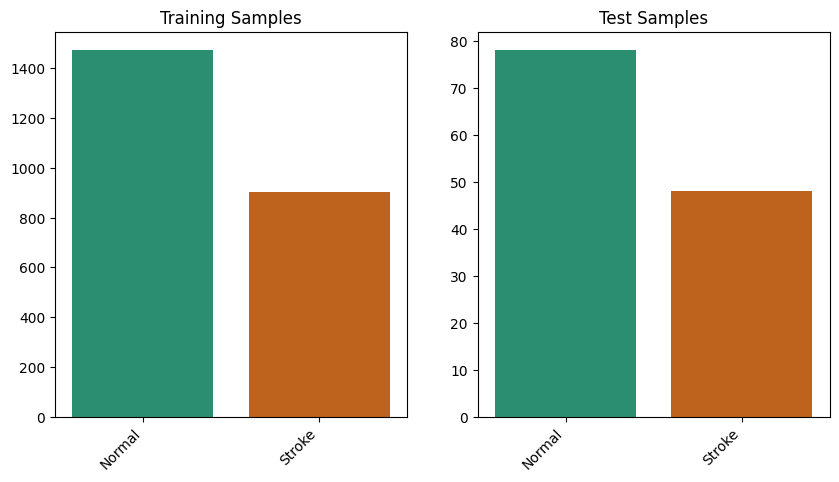

In [ ]:
plot_dataset_balance(stroke_train_path, stroke_test_path, stroke_classes)

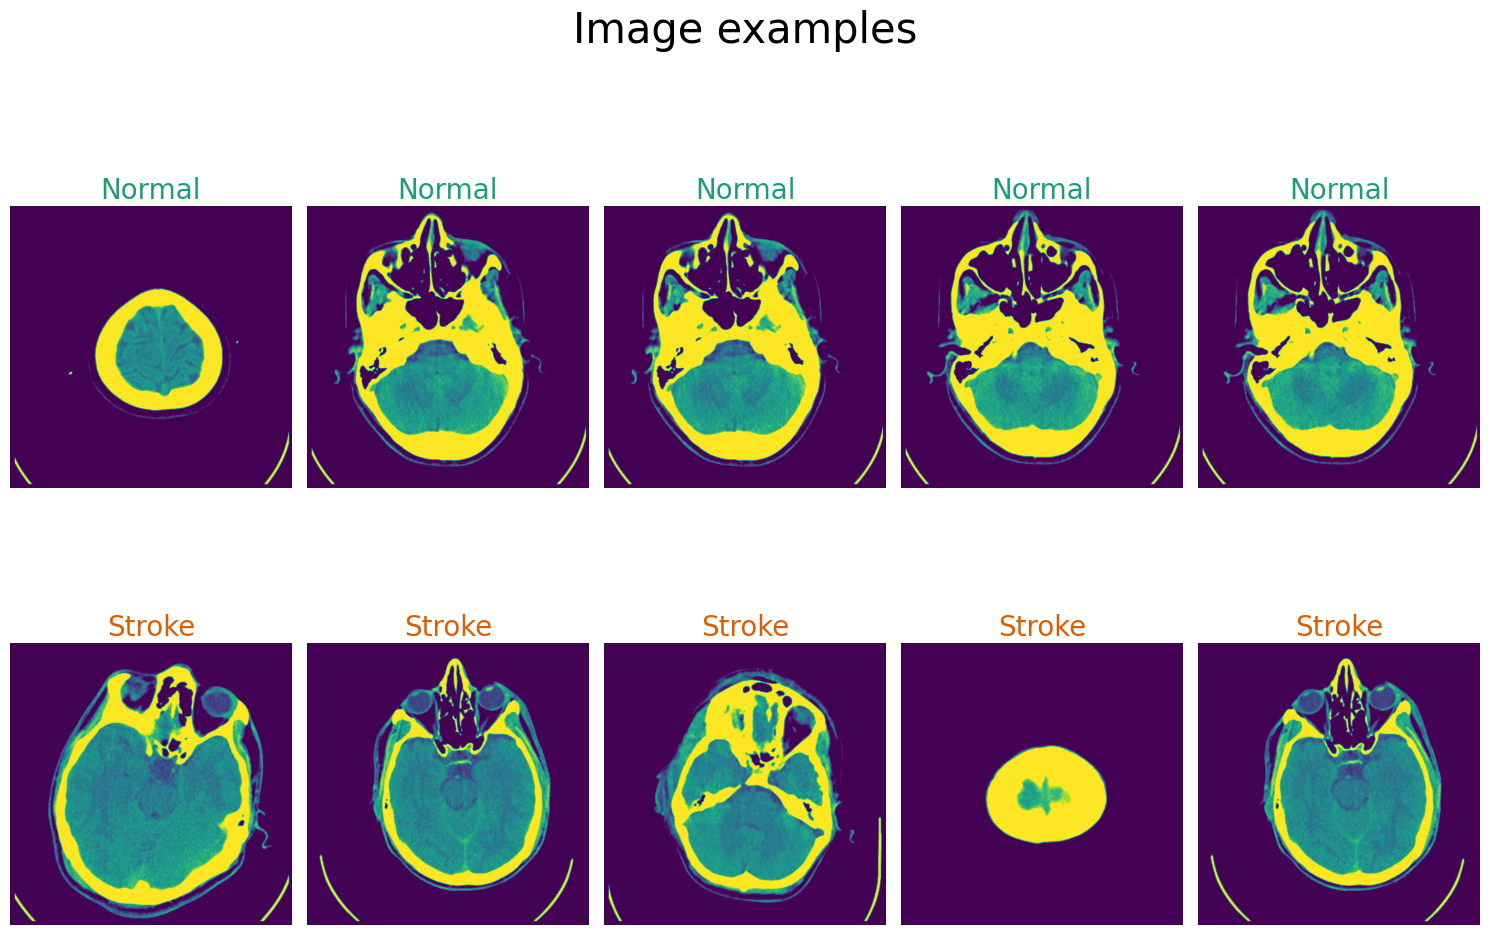

In [ ]:
show_example_grid(stroke_train_path, stroke_classes)

In [ ]:
stroke_train_data, stroke_val_data, stroke_test_data = get_generators(stroke_train_path, stroke_test_path, vgg19.preprocess_input, validation_split=0.25, augment_training_data=False)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [ ]:
model = get_binary_transfer_model(VGG19)

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 513
Non-trainable p

In [ ]:
model_history = train_model(model, stroke_train_data, stroke_val_data, filepath='stroke_vgg19.h5', epochs=50)

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50

Epoch 1: val_loss improved from inf to 1.20358, saving model to stroke_vgg19.h5
56/56 - 42s - loss: 2.8351 - accuracy: 0.5208 - auc: 0.4940 - precision: 0.3779 - recall: 0.4047 - val_loss: 1.2036 - val_accuracy: 0.6374 - val_auc: 0.5778 - val_precision: 0.5417 - val_recall: 0.2889 - 42s/epoch - 745ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.20358 to 1.04934, saving model to stroke_vgg19.h5
56/56 - 13s - loss: 2.1905 - accuracy: 0.5393 - auc: 0.5210 - precision: 0.3899 - recall: 0.3767 - val_loss: 1.0493 - val_accuracy: 0.6155 - val_auc: 0.5769 - val_precision: 0.4854 - val_recall: 0.2222 - 13s/epoch - 234ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.04934 to 0.96861, saving model to stroke_vgg19.h5
56/56 - 12s - loss: 1.7846 - accuracy: 0.5690 - auc: 0.5448 - precision: 0.4330 - recall: 0.4343 - val_loss: 0.9686 - val_accuracy: 0.6290 - val_auc: 0.5765 - val_precision: 0.5269 - val_recall: 0.2178 - 12s/epoch - 212ms/step
Epoch 4/50

Epoch 4: val_loss impro

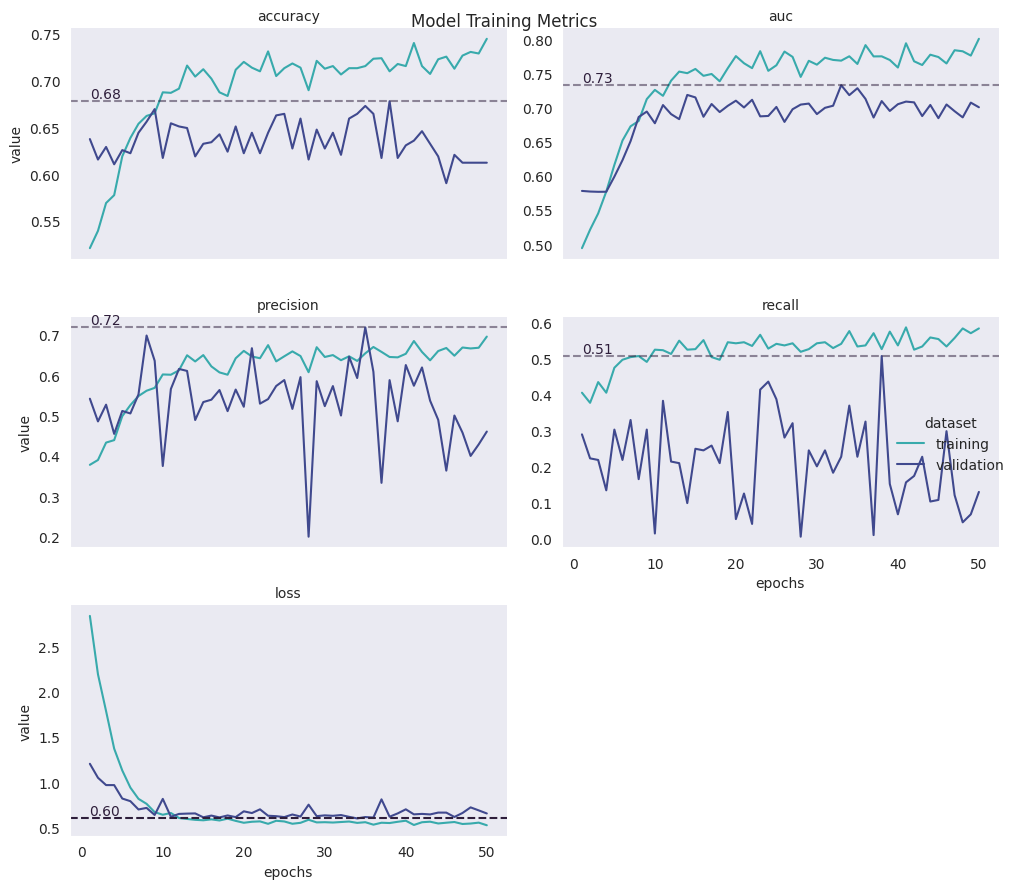

In [ ]:
save_model_history(model_history, 'stroke_vgg19.csv')
plot_metrics_lines(model_history)

1/1 [==============================] - 18s 18s/step


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

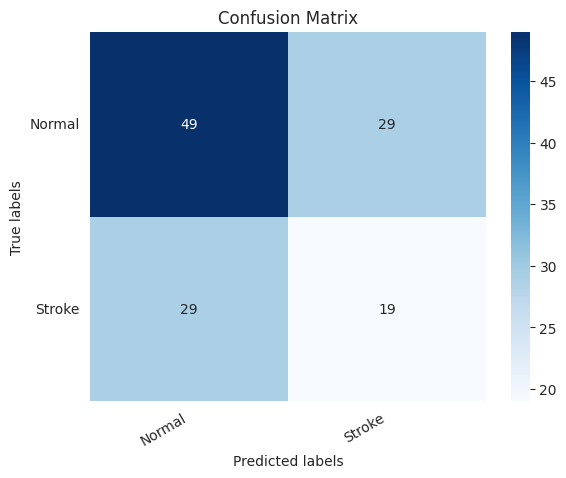

In [ ]:
y_true, y_pred = get_predictions(model, stroke_test_data, binary=True)
plot_confusion_matrix(y_true, y_pred, stroke_classes)

In [ ]:
run_experiment_pipeline(ResNet50, stroke_train_path, stroke_test_path, epochs=1)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
___________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.66162, saving model to stroke_restnet.h5
56/56 - 16s - loss: 0.6944 - accuracy: 0.6094 - auc: 0.5949 - precision: 0.5118 - recall: 0.2882 - val_loss: 0.6616 - val_accuracy: 0.6374 - val_auc: 0.6030 - val_precision: 0.5338 - val_recall: 0.3511 - 16s/epoch - 282ms/step
Training completed in time:  0:00:24.769521


In [ ]:
trained_models, results = compare_models(stroke_train_path, stroke_test_path, epochs=10)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params:

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 38s - loss: 0.6765 - accuracy: 0.6145 - auc: 0.5799 - precision: 0.4869 - recall: 0.2747 - val_loss: 0.6821 - val_accuracy: 0.6155 - val_auc: 0.5667 - val_precision: 0.4571 - val_recall: 0.0711 - 38s/epoch - 671ms/step
Epoch 2/10
56/56 - 12s - loss: 0.6022 - accuracy: 0.6633 - auc: 0.7008 - precision: 0.5881 - recall: 0.3796 - val_loss: 0.6590 - val_accuracy: 0.6358 - val_auc: 0.6055 - val_precision: 0.5306 - val_recall: 0.3467 - 12s/epoch - 209ms/step
Epoch 3/10
56/56 - 10s - loss: 0.5704 - accuracy: 0.6987 - auc: 0.7504 - precision: 0.6483 - recall: 0.4520 - val_loss: 0.6891 - val_accuracy: 0.6239 - val_auc: 0.6224 - val_precision: 0.5312 - val_recall: 0.0756 - 10s/epoch - 180ms/step
Epoch 4/10
56/56 - 9s - loss: 0.5301 - accuracy: 0.7329 - auc: 0.8024 - precision: 0.7107 - recall: 0.5007 - val_loss: 0.6720 - val_accuracy: 0.6239 - val_auc: 0.6320 - val_precision: 0.5185 - val_recall: 0.1244 - 9s/epoch - 160ms/step
Epoch 5/10
56/56 - 10s - loss: 0.5040 - accuracy: 0.7604 - au

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 24s - loss: 1.4608 - accuracy: 0.5398 - auc: 0.5234 - precision: 0.4170 - recall: 0.3537 - val_loss: 1.0854 - val_accuracy: 0.5464 - val_auc: 0.5244 - val_precision: 0.3675 - val_recall: 0.2711 - 24s/epoch - 424ms/step
Epoch 2/10
56/56 - 11s - loss: 0.9456 - accuracy: 0.5791 - auc: 0.5602 - precision: 0.4408 - recall: 0.4018 - val_loss: 0.9452 - val_accuracy: 0.5750 - val_auc: 0.5629 - val_precision: 0.4056 - val_recall: 0.2578 - 11s/epoch - 191ms/step
Epoch 3/10
56/56 - 10s - loss: 0.8141 - accuracy: 0.6156 - auc: 0.6167 - precision: 0.4934 - recall: 0.4402 - val_loss: 0.8706 - val_accuracy: 0.5987 - val_auc: 0.5891 - val_precision: 0.4539 - val_recall: 0.2844 - 10s/epoch - 181ms/step
Epoch 4/10
56/56 - 10s - loss: 0.7303 - accuracy: 0.6369 - auc: 0.6646 - precision: 0.5245 - recall: 0.4742 - val_loss: 0.8529 - val_accuracy: 0.6324 - val_auc: 0.6151 - val_precision: 0.5294 - val_recall: 0.2800 - 10s/epoch - 186ms/step
Epoch 5/10
56/56 - 10s - loss: 0.6672 - accuracy: 0.6566 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 14s - loss: 1.1619 - accuracy: 0.5438 - auc: 0.5382 - precision: 0.4175 - recall: 0.3703 - val_loss: 1.0308 - val_accuracy: 0.5363 - val_auc: 0.5020 - val_precision: 0.3904 - val_recall: 0.3956 - 14s/epoch - 246ms/step
Epoch 2/10
56/56 - 12s - loss: 0.8589 - accuracy: 0.6027 - auc: 0.5896 - precision: 0.4736 - recall: 0.4106 - val_loss: 0.8914 - val_accuracy: 0.5868 - val_auc: 0.5532 - val_precision: 0.4533 - val_recall: 0.4311 - 12s/epoch - 218ms/step
Epoch 3/10
56/56 - 12s - loss: 0.7403 - accuracy: 0.6414 - auc: 0.6536 - precision: 0.5316 - recall: 0.4727 - val_loss: 0.8610 - val_accuracy: 0.6172 - val_auc: 0.5867 - val_precision: 0.4915 - val_recall: 0.2578 - 12s/epoch - 221ms/step
Epoch 4/10
56/56 - 12s - loss: 0.6665 - accuracy: 0.6700 - auc: 0.6984 - precision: 0.5769 - recall: 0.4934 - val_loss: 0.7764 - val_accuracy: 0.6239 - val_auc: 0.6237 - val_precision: 0.5052 - val_recall: 0.4311 - 12s/epoch - 217ms/step
Epoch 5/10
56/56 - 12s - loss: 0.6065 - accuracy: 0.7009 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 20s - loss: 1.0509 - accuracy: 0.5814 - auc: 0.5841 - precision: 0.4699 - recall: 0.3891 - val_loss: 1.3013 - val_accuracy: 0.4722 - val_auc: 0.4463 - val_precision: 0.3053 - val_recall: 0.3067 - 20s/epoch - 358ms/step
Epoch 2/10
56/56 - 11s - loss: 0.7333 - accuracy: 0.6481 - auc: 0.6628 - precision: 0.5421 - recall: 0.4756 - val_loss: 0.8827 - val_accuracy: 0.6088 - val_auc: 0.5854 - val_precision: 0.4667 - val_recall: 0.2178 - 11s/epoch - 203ms/step
Epoch 3/10
56/56 - 11s - loss: 0.6521 - accuracy: 0.6835 - auc: 0.7241 - precision: 0.5898 - recall: 0.5480 - val_loss: 0.8413 - val_accuracy: 0.5919 - val_auc: 0.5960 - val_precision: 0.4619 - val_recall: 0.4578 - 11s/epoch - 197ms/step
Epoch 4/10
56/56 - 11s - loss: 0.5499 - accuracy: 0.7222 - auc: 0.7855 - precision: 0.6487 - recall: 0.5864 - val_loss: 0.7650 - val_accuracy: 0.6003 - val_auc: 0.6327 - val_precision: 0.4717 - val_recall: 0.4444 - 11s/epoch - 195ms/step
Epoch 5/10
56/56 - 13s - loss: 0.4791 - accuracy: 0.7654 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
56/56 - 20s - loss: 2.1463 - accuracy: 0.5539 - auc: 0.5442 - precision: 0.4384 - recall: 0.4257 - val_loss: 1.5229 - val_accuracy: 0.5379 - val_auc: 0.6212 - val_precision: 0.4294 - val_recall: 0.6622 - 20s/epoch - 358ms/step
Epoch 2/10
56/56 - 9s - loss: 1.3992 - accuracy: 0.5909 - auc: 0.5908 - precision: 0.4605 - recall: 0.4476 - val_loss: 1.4050 - val_accuracy: 0.5970 - val_auc: 0.5792 - val_precision: 0.4615 - val_recall: 0.3733 - 9s/epoch - 152ms/step
Epoch 3/10
56/56 - 9s - loss: 1.3212 - accuracy: 0.6122 - auc: 0.6322 - precision: 0.4891 - recall: 0.4638 - val_loss: 1.2698 - val_accuracy: 0.5885 - val_auc: 0.6234 - val_precision: 0.4664 - val_recall: 0.5867 - 9s/epoch - 153ms/step
Epoch 4/10
56/56 - 8s - loss: 1.1100 - accuracy: 0.6414 - auc: 0.6711 - precision: 0.5288 - recall: 0.5155 - val_loss: 1.3752 - val_accuracy: 0.5717 - val_auc: 0.6359 - val_precision: 0.4540 - val_recall: 0.6356 - 8s/epoch - 139ms/step
Epoch 5/10
56/56 - 9s - loss: 1.0419 - accuracy: 0.662

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 32s - loss: 16.5266 - accuracy: 0.5202 - auc: 0.5023 - precision: 0.3895 - recall: 0.3714 - val_loss: 7.9271 - val_accuracy: 0.6223 - val_auc: 0.5128 - val_precision: 0.5556 - val_recall: 0.0222 - 32s/epoch - 563ms/step
Epoch 2/10
56/56 - 13s - loss: 3.8477 - accuracy: 0.5348 - auc: 0.4964 - precision: 0.3824 - recall: 0.3648 - val_loss: 5.2802 - val_accuracy: 0.3457 - val_auc: 0.3890 - val_precision: 0.3558 - val_recall: 0.8933 - 13s/epoch - 230ms/step
Epoch 3/10
56/56 - 13s - loss: 11.3929 - accuracy: 0.5505 - auc: 0.5289 - precision: 0.4119 - recall: 0.4284 - val_loss: 14.5526 - val_accuracy: 0.6206 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 13s/epoch - 232ms/step
Epoch 4/10
56/56 - 13s - loss: 7.2426 - accuracy: 0.5359 - auc: 0.5070 - precision: 0.3900 - recall: 0.3929 - val_loss: 10.5751 - val_accuracy: 0.6206 - val_auc: 0.5022 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 13s/epoch - 230ms/step
Epoch 5/10
56/56 - 13s - loss: 8.2341 -

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 12s - loss: 0.6620 - accuracy: 0.6021 - auc: 0.5325 - precision: 0.4310 - recall: 0.1696 - val_loss: 0.6667 - val_accuracy: 0.6358 - val_auc: 0.6465 - val_precision: 0.8462 - val_recall: 0.0489 - 12s/epoch - 207ms/step
Epoch 2/10
56/56 - 7s - loss: 0.6072 - accuracy: 0.6554 - auc: 0.6896 - precision: 0.5963 - recall: 0.2880 - val_loss: 0.6462 - val_accuracy: 0.6509 - val_auc: 0.6208 - val_precision: 0.6552 - val_recall: 0.1689 - 7s/epoch - 125ms/step
Epoch 3/10
56/56 - 8s - loss: 0.5665 - accuracy: 0.6992 - auc: 0.7747 - precision: 0.6870 - recall: 0.3826 - val_loss: 0.6733 - val_accuracy: 0.6644 - val_auc: 0.6191 - val_precision: 0.8250 - val_recall: 0.1467 - 8s/epoch - 139ms/step
Epoch 4/10
56/56 - 8s - loss: 0.5478 - accuracy: 0.7177 - auc: 0.7958 - precision: 0.7231 - recall: 0.4165 - val_loss: 0.6245 - val_accuracy: 0.6644 - val_auc: 0.6513 - val_precision: 0.6300 - val_recall: 0.2800 - 8s/epoch - 141ms/step
Epoch 5/10
56/56 - 7s - loss: 0.5238 - accuracy: 0.7480 - auc: 0.

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
56/56 - 26s - loss: 2.1155 - accuracy: 0.5045 - auc: 0.5000 - precision: 0.3806 - recall: 0.3215 - val_loss: 1.1753 - val_accuracy: 0.5194 - val_auc: 0.3941 - val_precision: 0.2619 - val_recall: 0.1467 - 26s/epoch - 459ms/step
Epoch 2/10
56/56 - 8s - loss: 0.8723 - accuracy: 0.5584 - auc: 0.5358 - precision: 0.4032 - recall: 0.3383 - val_loss: 1.0701 - val_accuracy: 0.5497 - val_auc: 0.4342 - val_precision: 0.2981 - val_recall: 0.1378 - 8s/epoch - 152ms/step
Epoch 3/10
56/56 - 11s - loss: 0.7666 - accuracy: 0.5909 - auc: 0.5900 - precision: 0.4549 - recall: 0.3870 - val_loss: 1.0003 - val_accuracy: 0.5261 - val_auc: 0.4342 - val_precision: 0.3586 - val_recall: 0.3156 - 11s/epoch - 192ms/step
Epoch 4/10
56/56 - 9s - loss: 0.7180 - accuracy: 0.6279 - auc: 0.6305 - precision: 0.5124 - recall: 0.4269 - val_loss: 0.9681 - val_accuracy: 0.5565 - val_auc: 0.4521 - val_precision: 0.3643 - val_recall: 0.2267 - 9s/epoch - 164ms/step
Epoch 5/10
56/56 - 9s - loss: 0.6772 - accuracy: 0.6

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 25s - loss: 1.4717 - accuracy: 0.5180 - auc: 0.4712 - precision: 0.3523 - recall: 0.3426 - val_loss: 0.6771 - val_accuracy: 0.6695 - val_auc: 0.6796 - val_precision: 0.5848 - val_recall: 0.4444 - 25s/epoch - 443ms/step
Epoch 2/10
56/56 - 10s - loss: 0.7882 - accuracy: 0.6061 - auc: 0.5990 - precision: 0.4787 - recall: 0.4151 - val_loss: 0.7499 - val_accuracy: 0.6408 - val_auc: 0.6243 - val_precision: 0.5652 - val_recall: 0.2311 - 10s/epoch - 174ms/step
Epoch 3/10
56/56 - 10s - loss: 0.6806 - accuracy: 0.6504 - auc: 0.6805 - precision: 0.5453 - recall: 0.4801 - val_loss: 1.1661 - val_accuracy: 0.6290 - val_auc: 0.6085 - val_precision: 0.7778 - val_recall: 0.0311 - 10s/epoch - 178ms/step
Epoch 4/10
56/56 - 10s - loss: 0.6011 - accuracy: 0.6942 - auc: 0.7423 - precision: 0.6154 - recall: 0.5199 - val_loss: 0.7644 - val_accuracy: 0.6391 - val_auc: 0.5852 - val_precision: 0.5447 - val_recall: 0.2978 - 10s/epoch - 173ms/step
Epoch 5/10
56/56 - 12s - loss: 0.5224 - accuracy: 0.7357 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 31s - loss: 0.9460 - accuracy: 0.5421 - auc: 0.5319 - precision: 0.3975 - recall: 0.3592 - val_loss: 1.0418 - val_accuracy: 0.4890 - val_auc: 0.5503 - val_precision: 0.4141 - val_recall: 0.8356 - 31s/epoch - 553ms/step
Epoch 2/10
56/56 - 12s - loss: 0.7931 - accuracy: 0.5937 - auc: 0.5793 - precision: 0.4613 - recall: 0.4136 - val_loss: 0.7420 - val_accuracy: 0.5784 - val_auc: 0.6148 - val_precision: 0.4138 - val_recall: 0.2667 - 12s/epoch - 210ms/step
Epoch 3/10
56/56 - 12s - loss: 0.6787 - accuracy: 0.6420 - auc: 0.6429 - precision: 0.5369 - recall: 0.4195 - val_loss: 0.6969 - val_accuracy: 0.6239 - val_auc: 0.6395 - val_precision: 0.5053 - val_recall: 0.4267 - 12s/epoch - 206ms/step
Epoch 4/10
56/56 - 12s - loss: 0.6264 - accuracy: 0.6762 - auc: 0.6993 - precision: 0.5865 - recall: 0.5007 - val_loss: 0.6795 - val_accuracy: 0.6256 - val_auc: 0.6589 - val_precision: 0.5099 - val_recall: 0.3422 - 12s/epoch - 207ms/step
Epoch 5/10
56/56 - 12s - loss: 0.6279 - accuracy: 0.6745 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
56/56 - 29s - loss: 0.7821 - accuracy: 0.5460 - auc: 0.5467 - precision: 0.4159 - recall: 0.2960 - val_loss: 0.6500 - val_accuracy: 0.6121 - val_auc: 0.6317 - val_precision: 0.4855 - val_recall: 0.3733 - 29s/epoch - 526ms/step
Epoch 2/10
56/56 - 10s - loss: 0.6779 - accuracy: 0.6010 - auc: 0.5693 - precision: 0.4614 - recall: 0.2999 - val_loss: 0.6312 - val_accuracy: 0.6374 - val_auc: 0.6472 - val_precision: 0.5806 - val_recall: 0.1600 - 10s/epoch - 173ms/step
Epoch 3/10
56/56 - 9s - loss: 0.6470 - accuracy: 0.6274 - auc: 0.6090 - precision: 0.5206 - recall: 0.2422 - val_loss: 0.6508 - val_accuracy: 0.6459 - val_auc: 0.5986 - val_precision: 0.5926 - val_recall: 0.2133 - 9s/epoch - 155ms/step
Epoch 4/10
56/56 - 8s - loss: 0.6277 - accuracy: 0.6470 - auc: 0.6512 - precision: 0.5667 - recall: 0.3013 - val_loss: 0.6671 - val_accuracy: 0.5835 - val_auc: 0.5769 - val_precision: 0.4329 - val_recall: 0.3156 - 8s/epoch - 139ms/step
Epoch 5/10
56/56 - 8s - loss: 0.6146 - accuracy: 0.6

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 58s - loss: 0.7418 - accuracy: 0.5707 - auc: 0.5283 - precision: 0.3961 - recall: 0.2051 - val_loss: 0.7724 - val_accuracy: 0.6189 - val_auc: 0.5585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 58s/epoch - 1s/step
Epoch 2/10
56/56 - 28s - loss: 0.6418 - accuracy: 0.6380 - auc: 0.6465 - precision: 0.5381 - recall: 0.3338 - val_loss: 0.7086 - val_accuracy: 0.5953 - val_auc: 0.5413 - val_precision: 0.3333 - val_recall: 0.0667 - 28s/epoch - 505ms/step
Epoch 3/10
56/56 - 28s - loss: 0.5956 - accuracy: 0.6807 - auc: 0.7079 - precision: 0.6324 - recall: 0.3811 - val_loss: 0.7325 - val_accuracy: 0.5363 - val_auc: 0.5410 - val_precision: 0.4132 - val_recall: 0.5289 - 28s/epoch - 509ms/step
Epoch 4/10
56/56 - 29s - loss: 0.5693 - accuracy: 0.7009 - auc: 0.7539 - precision: 0.6629 - recall: 0.4328 - val_loss: 0.7364 - val_accuracy: 0.5514 - val_auc: 0.5217 - val_precision: 0.3727 - val_recall: 0.2667 - 29s/epoch - 512ms/step
Epoch 5/10
56/56 - 28s - loss: 0.5469 - accuracy: 0.73

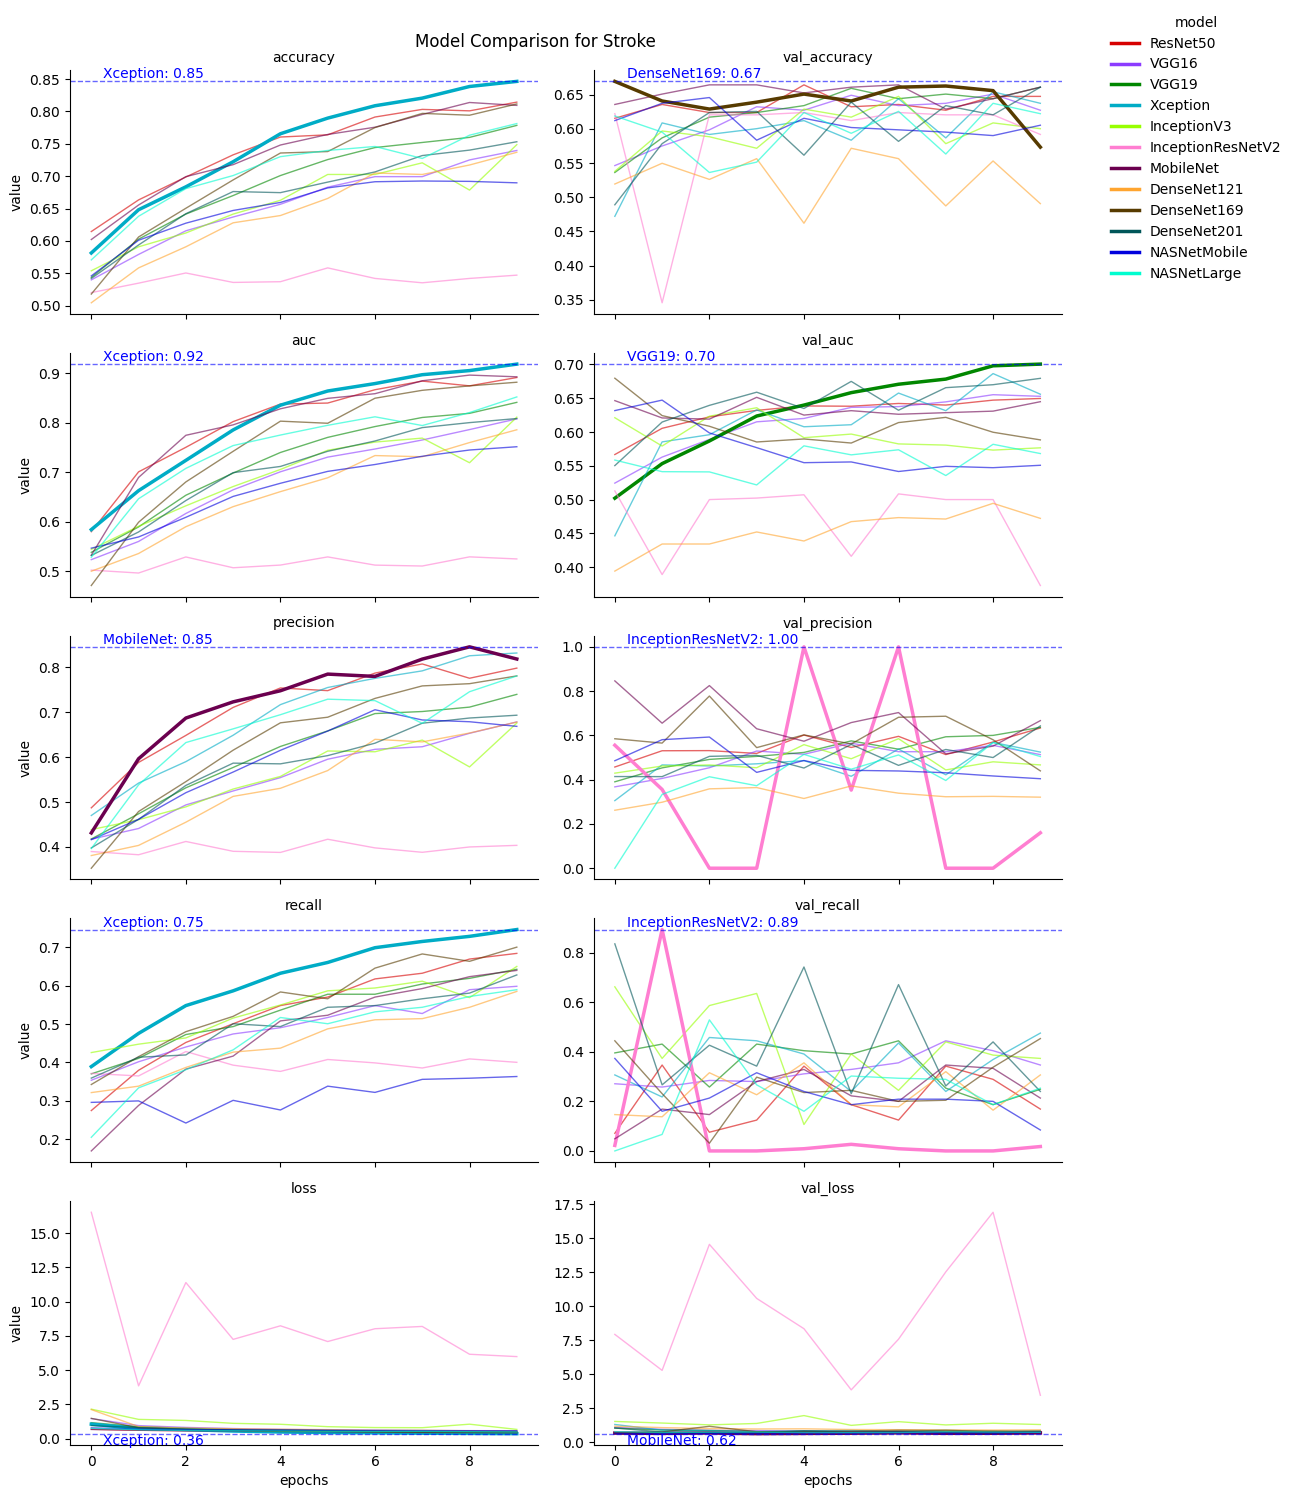

In [ ]:
plot_models_comparison(results, 'Stroke')

In [ ]:
results.to_csv('stroke_model_comparison.csv')

In [ ]:
trained_models, results = compare_models(stroke_train_path, stroke_test_path, models=[DenseNet169, VGG19, InceptionResNetV2], epochs=20)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_12  (None, 1664)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
__________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
56/56 - 26s - loss: 1.4455 - accuracy: 0.5477 - auc: 0.5262 - precision: 0.4130 - recall: 0.3370 - val_loss: 0.7574 - val_accuracy: 0.6189 - val_auc: 0.6254 - val_precision: 0.4973 - val_recall: 0.4133 - 26s/epoch - 471ms/step
Epoch 2/20
56/56 - 11s - loss: 0.7758 - accuracy: 0.6061 - auc: 0.6291 - precision: 0.4799 - recall: 0.4417 - val_loss: 0.9049 - val_accuracy: 0.6341 - val_auc: 0.6328 - val_precision: 0.6176 - val_recall: 0.0933 - 11s/epoch - 201ms/step
Epoch 3/20
56/56 - 10s - loss: 0.6909 - accuracy: 0.6425 - auc: 0.6884 - precision: 0.5355 - recall: 0.4461 - val_loss: 0.7459 - val_accuracy: 0.6172 - val_auc: 0.6280 - val_precision: 0.4922 - val_recall: 0.2800 - 10s/epoch - 176ms/step
Epoch 4/20
56/56 - 9s - loss: 0.5854 - accuracy: 0.7015 - auc: 0.7553 - precision: 0.6198 - recall: 0.5539 - val_loss: 0.7349 - val_accuracy: 0.6391 - val_auc: 0.6574 - val_precision: 0.5534 - val_recall: 0.2533 - 9s/epoch - 164ms/step
Epoch 5/20
56/56 - 10s - loss: 0.5628 - accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 14s - loss: 1.3247 - accuracy: 0.5533 - auc: 0.5522 - precision: 0.4515 - recall: 0.3869 - val_loss: 1.1340 - val_accuracy: 0.5835 - val_auc: 0.5103 - val_precision: 0.4247 - val_recall: 0.2756 - 14s/epoch - 248ms/step
Epoch 2/20
56/56 - 12s - loss: 0.9734 - accuracy: 0.5831 - auc: 0.5710 - precision: 0.4464 - recall: 0.4062 - val_loss: 1.0160 - val_accuracy: 0.5750 - val_auc: 0.5221 - val_precision: 0.4301 - val_recall: 0.3689 - 12s/epoch - 219ms/step
Epoch 3/20
56/56 - 12s - loss: 0.8201 - accuracy: 0.6162 - auc: 0.6229 - precision: 0.4941 - recall: 0.4328 - val_loss: 0.9576 - val_accuracy: 0.5919 - val_auc: 0.5633 - val_precision: 0.4298 - val_recall: 0.2311 - 12s/epoch - 219ms/step
Epoch 4/20
56/56 - 12s - loss: 0.7203 - accuracy: 0.6364 - auc: 0.6687 - precision: 0.5241 - recall: 0.4653 - val_loss: 0.8555 - val_accuracy: 0.5953 - val_auc: 0.5915 - val_precision: 0.4566 - val_recall: 0.3511 - 12s/epoch - 213ms/step
Epoch 5/20
56/56 - 12s - loss: 0.6744 - accuracy: 0.6633 - 

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 29s - loss: 22.0000 - accuracy: 0.5393 - auc: 0.5270 - precision: 0.4359 - recall: 0.4224 - val_loss: 8.6240 - val_accuracy: 0.6155 - val_auc: 0.5200 - val_precision: 0.2857 - val_recall: 0.0089 - 29s/epoch - 511ms/step
Epoch 2/20
56/56 - 13s - loss: 7.0870 - accuracy: 0.5432 - auc: 0.5126 - precision: 0.3967 - recall: 0.3885 - val_loss: 17.7636 - val_accuracy: 0.6206 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 13s/epoch - 232ms/step
Epoch 3/20
56/56 - 13s - loss: 11.9428 - accuracy: 0.5253 - auc: 0.4993 - precision: 0.3729 - recall: 0.3663 - val_loss: 36.6546 - val_accuracy: 0.3794 - val_auc: 0.5000 - val_precision: 0.3794 - val_recall: 1.0000 - 13s/epoch - 232ms/step
Epoch 4/20
56/56 - 15s - loss: 14.0145 - accuracy: 0.5281 - auc: 0.4939 - precision: 0.3742 - recall: 0.3604 - val_loss: 7.7088 - val_accuracy: 0.3794 - val_auc: 0.4572 - val_precision: 0.3794 - val_recall: 1.0000 - 15s/epoch - 265ms/step
Epoch 5/20
56/56 - 13s - loss: 4.5982 - accura

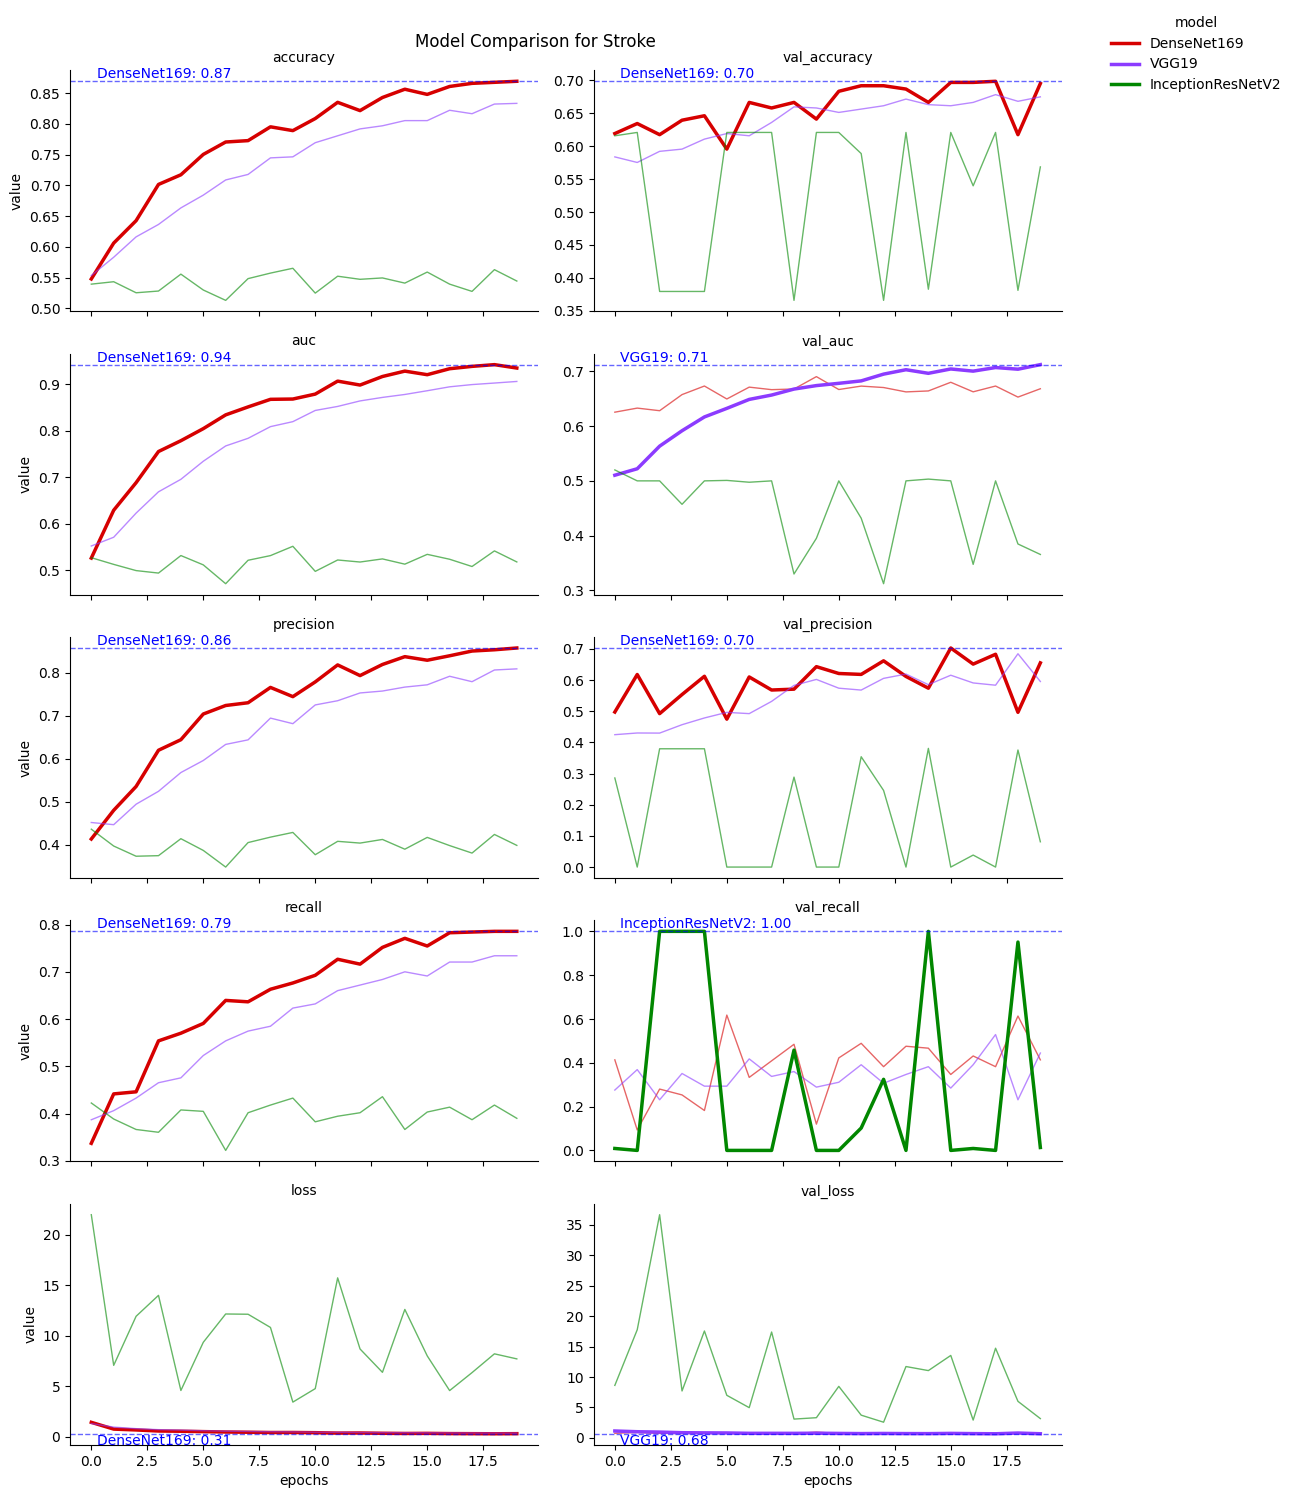

In [ ]:
plot_models_comparison(results, 'Stroke')

In [ ]:
trained_models, results = compare_models(stroke_train_path, stroke_test_path, models=[DenseNet169, VGG19], epochs=50)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_18  (None, 1664)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
__________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50
56/56 - 28s - loss: 1.4197 - accuracy: 0.5600 - auc: 0.5551 - precision: 0.4490 - recall: 0.3614 - val_loss: 0.8505 - val_accuracy: 0.5312 - val_auc: 0.5330 - val_precision: 0.3568 - val_recall: 0.2933 - 28s/epoch - 507ms/step
Epoch 2/50
56/56 - 10s - loss: 0.7188 - accuracy: 0.6184 - auc: 0.6377 - precision: 0.4973 - recall: 0.4121 - val_loss: 0.7939 - val_accuracy: 0.5683 - val_auc: 0.5899 - val_precision: 0.4351 - val_recall: 0.4622 - 10s/epoch - 170ms/step
Epoch 3/50
56/56 - 11s - loss: 0.6088 - accuracy: 0.6818 - auc: 0.7249 - precision: 0.5993 - recall: 0.4904 - val_loss: 0.8153 - val_accuracy: 0.6425 - val_auc: 0.6376 - val_precision: 0.5765 - val_recall: 0.2178 - 11s/epoch - 198ms/step
Epoch 4/50
56/56 - 10s - loss: 0.5775 - accuracy: 0.7048 - auc: 0.7557 - precision: 0.6318 - recall: 0.5347 - val_loss: 0.7618 - val_accuracy: 0.6273 - val_auc: 0.6210 - val_precision: 0.5132 - val_recall: 0.3467 - 10s/epoch - 175ms/step
Epoch 5/50
56/56 - 10s - loss: 0.5157 - accuracy

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


56/56 - 14s - loss: 1.3727 - accuracy: 0.5426 - auc: 0.5370 - precision: 0.4254 - recall: 0.3858 - val_loss: 1.0109 - val_accuracy: 0.6239 - val_auc: 0.6060 - val_precision: 0.5063 - val_recall: 0.3600 - 14s/epoch - 251ms/step
Epoch 2/50
56/56 - 12s - loss: 0.9198 - accuracy: 0.5915 - auc: 0.5831 - precision: 0.4558 - recall: 0.3885 - val_loss: 0.8484 - val_accuracy: 0.6324 - val_auc: 0.6359 - val_precision: 0.5179 - val_recall: 0.4489 - 12s/epoch - 211ms/step
Epoch 3/50
56/56 - 14s - loss: 0.7679 - accuracy: 0.6274 - auc: 0.6586 - precision: 0.5109 - recall: 0.4520 - val_loss: 0.8632 - val_accuracy: 0.6577 - val_auc: 0.6620 - val_precision: 0.5873 - val_recall: 0.3289 - 14s/epoch - 248ms/step
Epoch 4/50
56/56 - 12s - loss: 0.6770 - accuracy: 0.6582 - auc: 0.7027 - precision: 0.5570 - recall: 0.4904 - val_loss: 0.7814 - val_accuracy: 0.6610 - val_auc: 0.6895 - val_precision: 0.5882 - val_recall: 0.3556 - 12s/epoch - 212ms/step
Epoch 5/50
56/56 - 12s - loss: 0.6234 - accuracy: 0.6874 - 

NameError: ignored

In [ ]:
plot_models_comparison(results, 'Stroke')

In [ ]:
trained_models

In [ ]:
trained_model, model_history = run_experiment_pipeline(VGG19, stroke_train_path, stroke_test_path, epochs=20)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_21  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
____________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
56/56 - 16s - loss: 1.4033 - accuracy: 0.5325 - auc: 0.5146 - precision: 0.4005 - recall: 0.3845 - val_loss: 1.0950 - val_accuracy: 0.5818 - val_auc: 0.5186 - val_precision: 0.4350 - val_recall: 0.3422 - 16s/epoch - 288ms/step
Epoch 2/20
56/56 - 12s - loss: 0.9482 - accuracy: 0.5802 - auc: 0.5703 - precision: 0.4393 - recall: 0.3796 - val_loss: 0.9954 - val_accuracy: 0.5548 - val_auc: 0.5253 - val_precision: 0.4118 - val_recall: 0.4044 - 12s/epoch - 222ms/step
Epoch 3/20
56/56 - 12s - loss: 0.8044 - accuracy: 0.6077 - auc: 0.6319 - precision: 0.4826 - recall: 0.4520 - val_loss: 0.9049 - val_accuracy: 0.5936 - val_auc: 0.5684 - val_precision: 0.4579 - val_recall: 0.3867 - 12s/epoch - 221ms/step
Epoch 4/20
56/56 - 14s - loss: 0.7213 - accuracy: 0.6448 - auc: 0.6737 - precision: 0.5387 - recall: 0.4520 - val_loss: 0.8617 - val_accuracy: 0.6223 - val_auc: 0.6021 - val_precision: 0.5035 - val_recall: 0.3200 - 14s/epoch - 257ms/step
Epoch 5/20
56/56 - 12s - loss: 0.6609 - accuracy

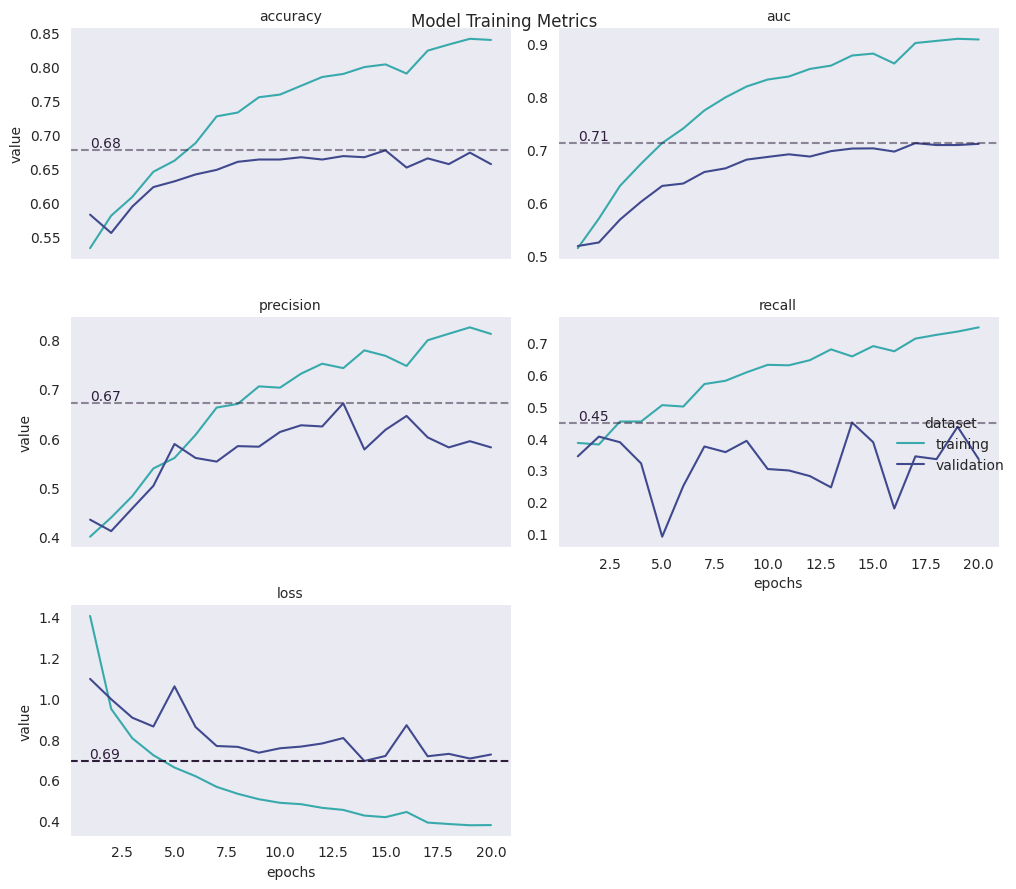

In [ ]:
plot_metrics_lines(model_history)

1/1 [==============================] - 17s 17s/step


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

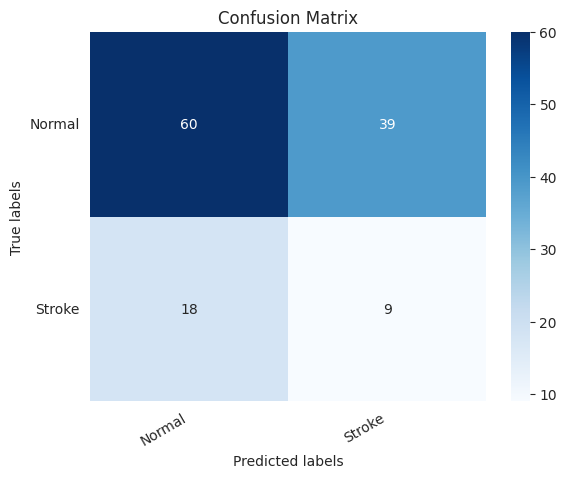

In [ ]:
y_true, y_pred = get_predictions(trained_model, stroke_test_data, binary=True)
plot_confusion_matrix(y_true, y_pred, stroke_classes)

In [ ]:
trained_model.layers[1].trainable = True
trained_model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_21  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 20,024,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stroke_train_data, stroke_val_data, stroke_test_data = get_generators(stroke_train_path, stroke_test_path, vgg19.preprocess_input, validation_split=0.25, augment_training_data=True)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [ ]:
adam = optimizers.Adam(1e-5)
trained_model = compile_model(trained_model, optimizer=adam)
model_history = train_model(trained_model, stroke_train_data, stroke_test_data, filepath='stroke_vgg19.h5', epochs=20)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.52242, saving model to stroke_vgg19.h5
56/56 - 41s - loss: 0.9120 - accuracy: 0.6134 - auc: 0.8395 - precision: 0.6930 - recall: 0.6500 - val_loss: 0.5224 - val_accuracy: 0.7698 - val_auc: 0.8226 - val_precision: 0.6863 - val_recall: 0.7292 - 41s/epoch - 724ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.52242 to 0.46812, saving model to stroke_vgg19.h5
56/56 - 41s - loss: 0.5965 - accuracy: 0.6813 - auc: 0.7171 - precision: 0.6157 - recall: 0.4284 - val_loss: 0.4681 - val_accuracy: 0.7619 - val_auc: 0.8614 - val_precision: 0.8462 - val_recall: 0.4583 - 41s/epoch - 736ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.46812 to 0.44615, saving model to stroke_vgg19.h5
56/56 - 42s - loss: 0.5658 - accuracy: 0.6998 - auc: 0.7525 - precision: 0.6392 - recall: 0.4815 - val_loss: 0.4462 - val_accuracy: 0.7698 - val_auc: 0.8860 - val_precision: 0.6939 - val_recall: 0.7083 - 42s/epoch - 750ms/step
Epoch 4/20

Epoch 4: val_loss did n

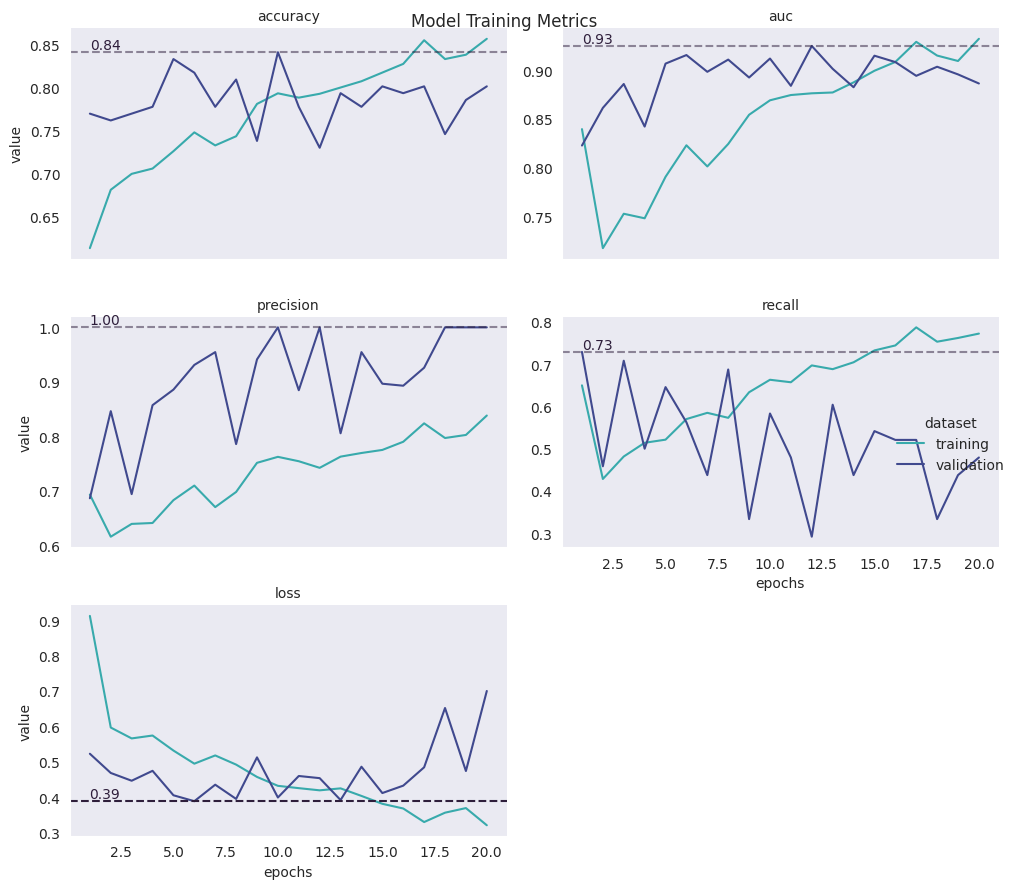

In [ ]:
plot_metrics_lines(model_history)

In [ ]:
model_history = train_model(model, stroke_train_data, stroke_val_data, filepath='stroke_vgg19.h5', epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.21645, saving model to stroke_vgg19.h5
56/56 - 38s - loss: 2.4896 - accuracy: 0.5359 - auc: 0.5032 - precision: 0.3850 - recall: 0.3708 - val_loss: 1.2165 - val_accuracy: 0.6358 - val_auc: 0.6001 - val_precision: 0.6047 - val_recall: 0.1156 - 38s/epoch - 671ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.21645 to 0.88774, saving model to stroke_vgg19.h5
56/56 - 11s - loss: 1.8044 - accuracy: 0.5724 - auc: 0.5682 - precision: 0.4339 - recall: 0.4121 - val_loss: 0.8877 - val_accuracy: 0.6071 - val_auc: 0.5940 - val_precision: 0.4655 - val_recall: 0.2400 - 11s/epoch - 198ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.88774 to 0.81924, saving model to stroke_vgg19.h5
56/56 - 11s - loss: 1.5554 - accuracy: 0.5741 - auc: 0.5687 - precision: 0.4377 - recall: 0.4254 - val_loss: 0.8192 - val_accuracy: 0.6239 - val_auc: 0.6149 - val_precision: 0.5096 - val_recall: 0.2356 - 11s/epoch - 197ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.

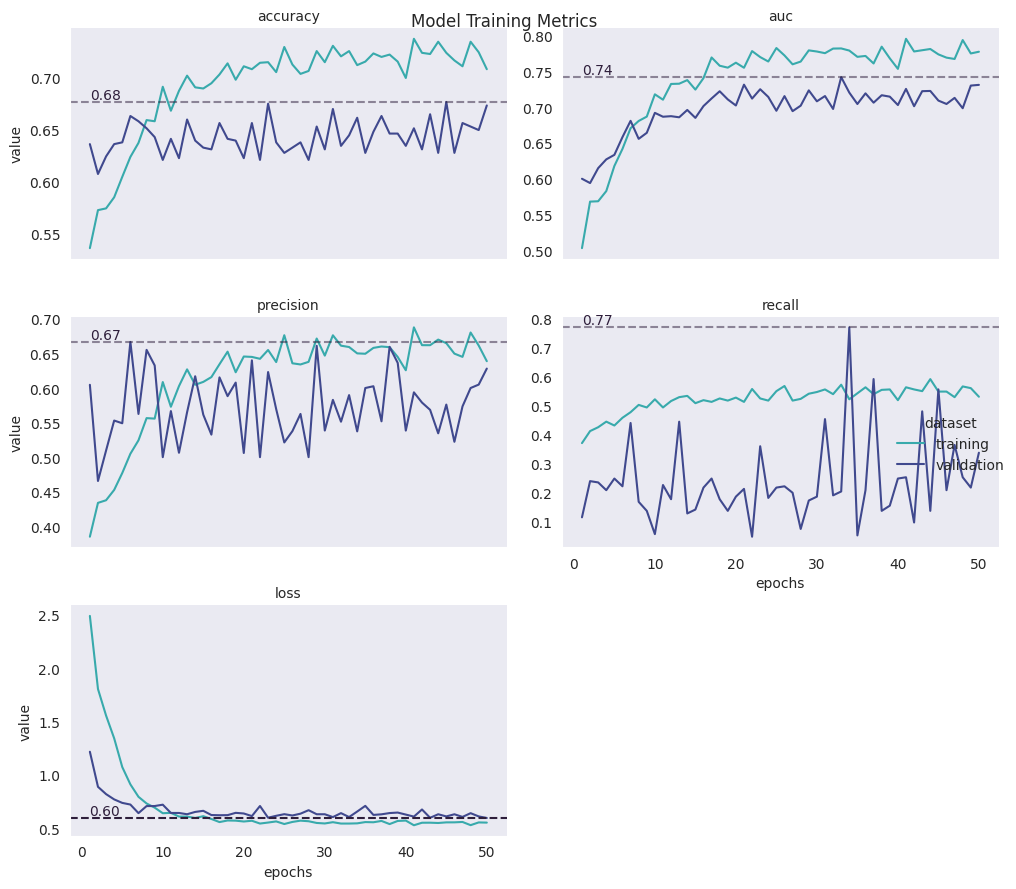

In [ ]:
plot_metrics_lines(model_history)

In [ ]:
model.layers[1].trainable = True
model.summary()
adam = optimizers.Adam(1e-5)
model = compile_model(model, optimizer=adam)
model_history = train_model(model, stroke_train_data, stroke_test_data, filepath='stroke_vgg19.h5', epochs=20)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 20,024,897
Non-trainable params: 0
_________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.47483, saving model to stroke_vgg19.h5
56/56 - 58s - loss: 0.5306 - accuracy: 0.7379 - auc: 0.7781 - precision: 0.6764 - recall: 0.5122 - val_loss: 0.4748 - val_accuracy: 0.7937 - val_auc: 0.8902 - val_precision: 0.7200 - val_recall: 0.7500 - 58s/epoch - 1s/step
Epoch 2/20

Epoch 2: val_loss improved from 0.47483 to 0.45241, saving model to stroke_vgg19.h5
56/56 - 33s - loss: 0.3641 - accuracy: 0.8316 - auc: 0.9131 - precision: 0.8095 - recall: 0.7282 - val_loss: 0.4524 - val_accuracy: 0.7698 - val_auc: 0.8729 - val_precision: 0.8519 - val_recall: 0.4792 - 33s/epoch - 584ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.45241 to 0.35975, saving model to stroke_vgg19.h5
56/56 - 29s - loss: 0.2390 - accuracy: 0.9035 - auc: 0.9645 - precision: 0.8867 - recall: 0.8552 - val_loss: 0.3597 - val_accuracy: 0.8413 - val_auc: 0.9298 - val_precision: 0.7593 - val_recall: 0.8542 - 29s/epoch - 527ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.359

In [ ]:
evaluate_model(model, stroke_test_data)

1/1 [==============================] - 1s 1s/step - loss: 0.2372 - accuracy: 0.9048 - auc: 0.9654 - precision: 0.8462 - recall: 0.9167
Test loss: 0.23720476031303406
Test accuracy: 0.9047619104385376


Found 2138 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
VGG19
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_36 (Dropout)        (None, 512)               0         
                                                                 
 dense_63 (Dense)            (None, 1)                 513       
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 - 44s - loss: 0.6915 - accuracy: 0.5893 - auc: 0.5148 - precision: 0.4583 - recall: 0.2111 - val_loss: 0.6649 - val_accuracy: 0.6203 - val_auc: 0.5049 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 44s/epoch - 650ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.66492 to 0.66248, saving model to stroke_vgg19.h5
67/67 - 36s - loss: 0.6818 - accuracy: 0.5968 - auc: 0.4966 - precision: 0.3913 - recall: 0.1108 - val_loss: 0.6625 - val_accuracy: 0.6203 - val_auc: 0.5563 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 36s/epoch - 532ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from 0.66248
67/67 - 36s - loss: 0.6687 - accuracy: 0.6155 - auc: 0.5306 - precision: 0.4500 - recall: 0.0554 - val_loss: 0.6625 - val_accuracy: 0.6203 - val_auc: 0.5849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 36s/epoch - 540ms/step
Epoch 4/10

Epoch 4: val_loss improved from 0.66248 to 0.65614, saving model to stroke_vgg19.h5
67/67 - 37s - loss: 0.6737 - accuracy: 0.611

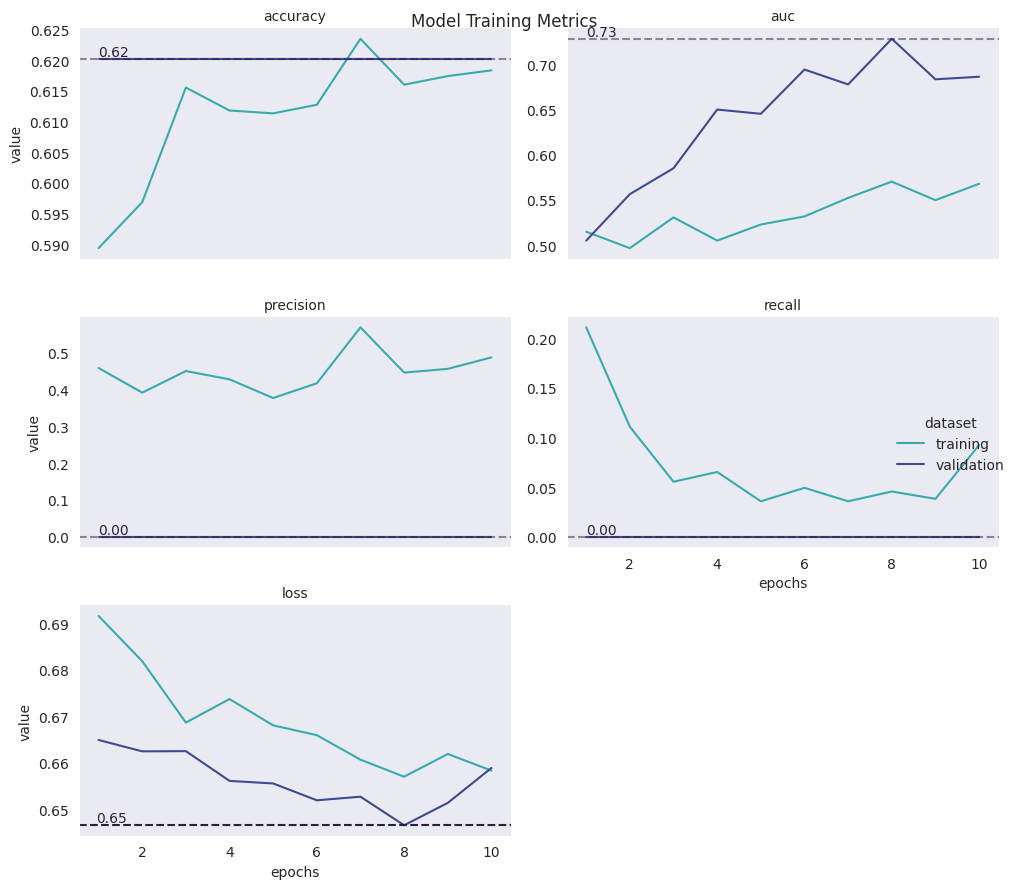

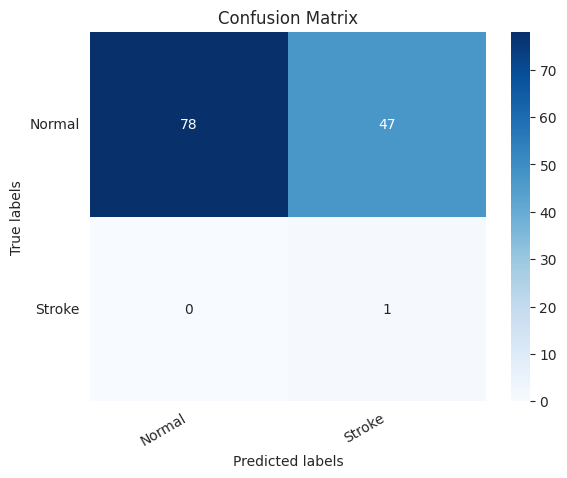

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_36 (Dropout)        (None, 512)               0         
                                                                 
 dense_63 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 - 70s - loss: 0.6584 - accuracy: 0.6099 - auc: 0.5644 - precision: 0.3793 - recall: 0.0384 - val_loss: 0.6277 - val_accuracy: 0.6203 - val_auc: 0.7532 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 70s/epoch - 1s/step
Epoch 2/150

Epoch 2: val_loss improved from 0.62767 to 0.59707, saving model to stroke_vgg19_unfrozen.h5
67/67 - 48s - loss: 0.6272 - accuracy: 0.6427 - auc: 0.6555 - precision: 0.5764 - recall: 0.2229 - val_loss: 0.5971 - val_accuracy: 0.6203 - val_auc: 0.8117 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 48s/epoch - 721ms/step
Epoch 3/150

Epoch 3: val_loss improved from 0.59707 to 0.57266, saving model to stroke_vgg19_unfrozen.h5
67/67 - 53s - loss: 0.5894 - accuracy: 0.6745 - auc: 0.7190 - precision: 0.6255 - recall: 0.3559 - val_loss: 0.5727 - val_accuracy: 0.6835 - val_auc: 0.8028 - val_precision: 0.7778 - val_recall: 0.2333 - 53s/epoch - 793ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.57266 to 0.56395, saving model to stroke_vgg19_

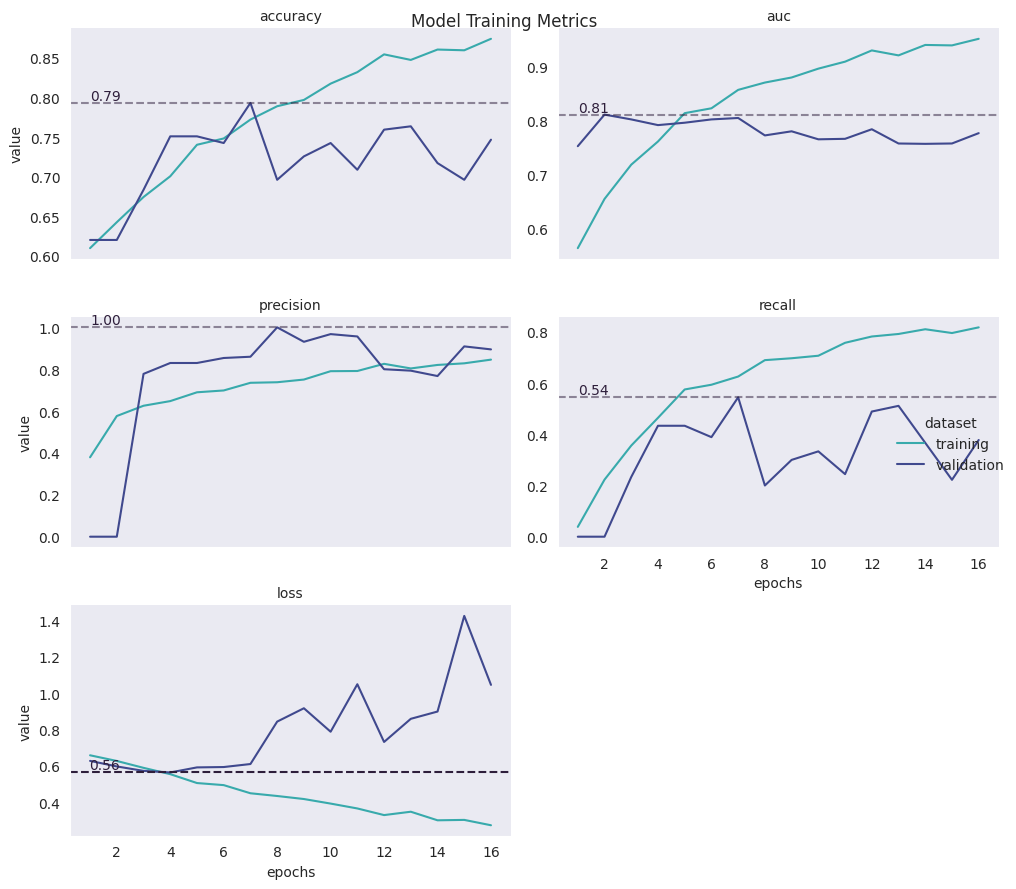

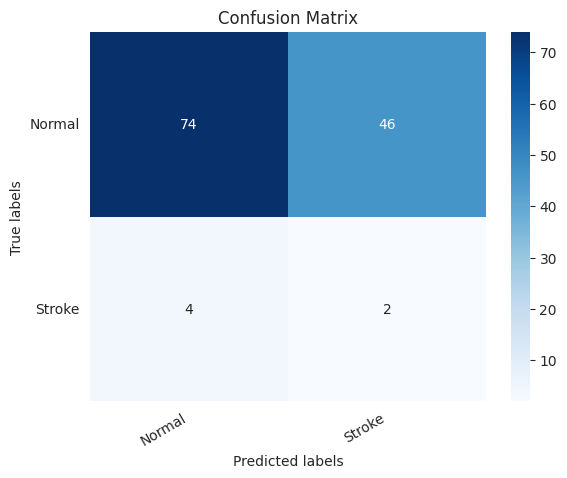

In [ ]:
trained_model, model_history = run_training_pipeline(VGG19, stroke_train_path, stroke_test_path, classes=stroke_classes, model_name="stroke_vgg19", frozen_epochs=10, unfrozen_epochs=150, validation_split=0.1, augment_training_data=True, plot_results=True, patience=10)

Found 1782 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
ResNet50
94765736/94765736 [==============================] - 1s 0us/step
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 1)                 2049

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 - 44s - loss: 0.8267 - accuracy: 0.5657 - auc: 0.5565 - precision: 0.4310 - recall: 0.3448 - val_loss: 0.6665 - val_accuracy: 0.6290 - val_auc: 0.6148 - val_precision: 0.5610 - val_recall: 0.1022 - 44s/epoch - 791ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.66653 to 0.65265, saving model to stroke_DenseNet169.h5
56/56 - 34s - loss: 0.7660 - accuracy: 0.5853 - auc: 0.5700 - precision: 0.4446 - recall: 0.3678 - val_loss: 0.6527 - val_accuracy: 0.6341 - val_auc: 0.6433 - val_precision: 0.5179 - val_recall: 0.5156 - 34s/epoch - 600ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.65265
56/56 - 37s - loss: 0.7132 - accuracy: 0.6190 - auc: 0.6077 - precision: 0.4982 - recall: 0.4092 - val_loss: 0.6680 - val_accuracy: 0.6071 - val_auc: 0.6157 - val_precision: 0.4310 - val_recall: 0.1111 - 37s/epoch - 656ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 0.65265
56/56 - 35s - loss: 0.6997 - accuracy: 0.6184 - auc: 0.6175 - precision: 0.4969 - recall: 0.3560 - 

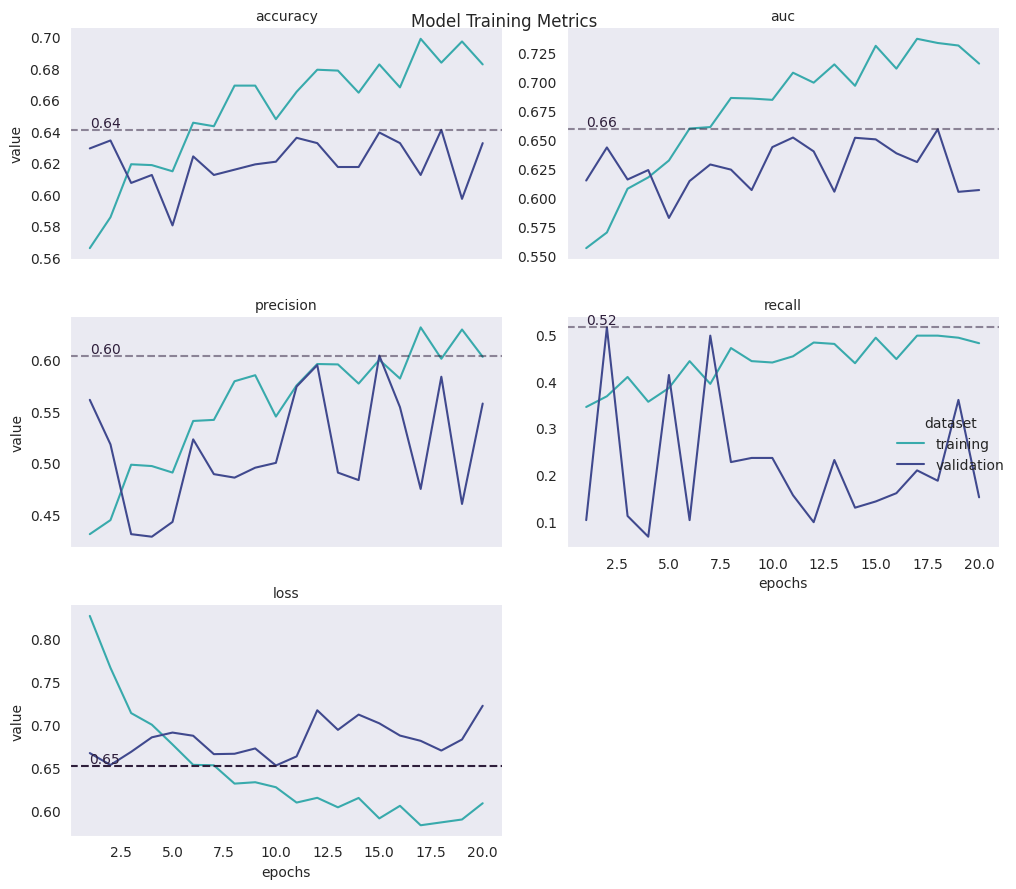

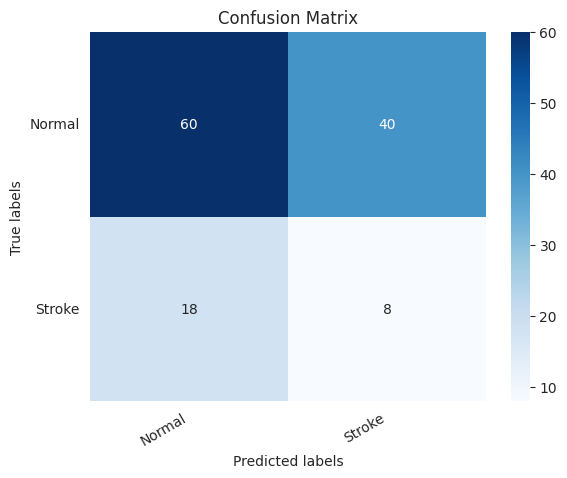

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_____________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 - 86s - loss: 0.6177 - accuracy: 0.6549 - auc: 0.6924 - precision: 0.5738 - recall: 0.3862 - val_loss: 0.6454 - val_accuracy: 0.6172 - val_auc: 0.6369 - val_precision: 0.4936 - val_recall: 0.3422 - 86s/epoch - 2s/step
Epoch 2/150

Epoch 2: val_loss did not improve from 0.64538
56/56 - 40s - loss: 0.5606 - accuracy: 0.7104 - auc: 0.7587 - precision: 0.6588 - recall: 0.4934 - val_loss: 0.6974 - val_accuracy: 0.6256 - val_auc: 0.6375 - val_precision: 0.5217 - val_recall: 0.1600 - 40s/epoch - 722ms/step
Epoch 3/150

Epoch 3: val_loss did not improve from 0.64538
56/56 - 41s - loss: 0.5345 - accuracy: 0.7217 - auc: 0.7854 - precision: 0.6596 - recall: 0.5524 - val_loss: 0.7025 - val_accuracy: 0.6627 - val_auc: 0.6767 - val_precision: 0.6582 - val_recall: 0.2311 - 41s/epoch - 739ms/step
Epoch 4/150

Epoch 4: val_loss did not improve from 0.64538
56/56 - 41s - loss: 0.5235 - accuracy: 0.7464 - auc: 0.8000 - precision: 0.7020 - recall: 0.5775 - val_loss: 0.6982 - val_accuracy: 0.6408 - v

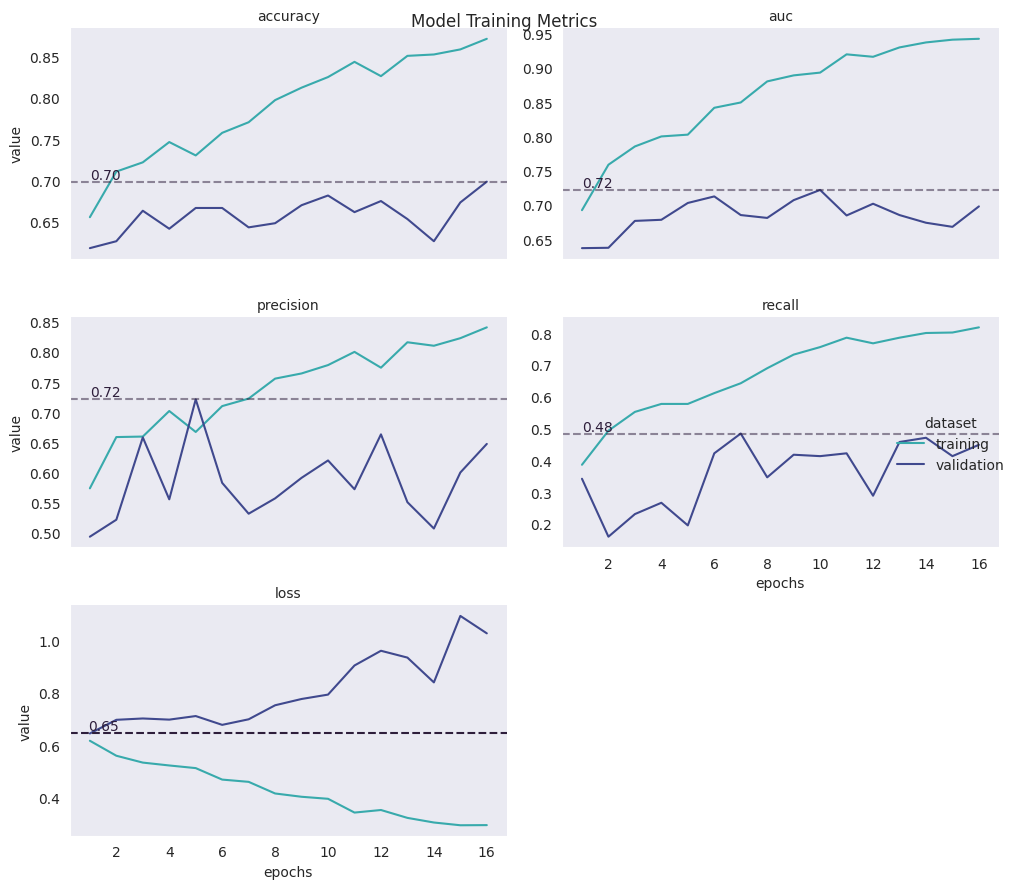

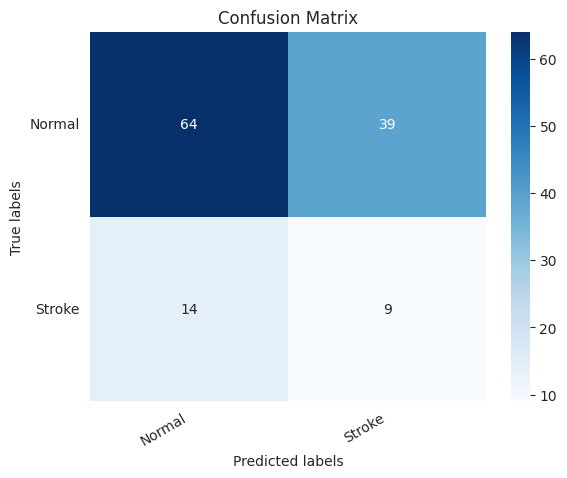

In [ ]:
trained_model, model_history = run_training_pipeline(ResNet50, stroke_train_path, stroke_test_path, classes=stroke_classes, model_name="stroke_DenseNet169", frozen_epochs=10, unfrozen_epochs=150, validation_split=0.25, augment_training_data=True, plot_results=True, patience=10)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout

input_shape = (227, 227, 3)
n_classes = 2

# Create a Sequential model
model = Sequential(
    [
        Conv2D(filters=64, kernel_size=(5,5), strides=1, padding="valid", input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(13,13), strides=1, padding="valid", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=256, kernel_size=(7,7), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(1, 1), strides=2, padding='valid'),

        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')

     ]
)

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
compile_model(trained_model, optimizer=adam)


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 223, 223, 64)      4864      
                                                                 
 max_pooling2d_117 (MaxPool  (None, 111, 111, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_121 (Conv2D)         (None, 111, 111, 128)     73856     
                                                                 
 max_pooling2d_118 (MaxPool  (None, 55, 55, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_122 (Conv2D)         (None, 43, 43, 128)       2769024   
                                                                 
 max_pooling2d_119 (MaxPool  (None, 21, 21, 128)     

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout

input_shape = (227, 227, 3)
n_classes = 2

# Create a Sequential model
model = Sequential(
    [
        Conv2D(filters=64, kernel_size=(5,5), strides=1, padding="valid", input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(13,13), strides=1, padding="valid", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=256, kernel_size=(7,7), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(1, 1), strides=2, padding='valid'),

        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')

     ]
)

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
compile_model(trained_model, optimizer=adam)


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 223, 223, 64)      4864      
                                                                 
 max_pooling2d_117 (MaxPool  (None, 111, 111, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_121 (Conv2D)         (None, 111, 111, 128)     73856     
                                                                 
 max_pooling2d_118 (MaxPool  (None, 55, 55, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_122 (Conv2D)         (None, 43, 43, 128)       2769024   
                                                                 
 max_pooling2d_119 (MaxPool  (None, 21, 21, 128)     

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout

input_shape = (227, 227, 3)
n_classes = 2

# Create a Sequential model
model = Sequential(
    [
        Conv2D(filters=64, kernel_size=(5,5), strides=1, padding="valid", input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(13,13), strides=1, padding="valid", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=256, kernel_size=(7,7), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation='relu'),
        MaxPooling2D(pool_size=(1, 1), strides=2, padding='valid'),

        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')

     ]
)

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=list(metrics.values()))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 128)       2769024   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 21, 21, 128)       0

In [ ]:
stroke_train_data, stroke_val_data, stroke_test_data = get_generators(stroke_train_path, stroke_test_path, lambda x: x, validation_split=0.1, augment_training_data=True, image_shape=(227,227), class_mode='categorical')
train_model(model, stroke_train_data, stroke_val_data)

Found 2243 images belonging to 2 classes.
Found 248 images belonging to 2 classes.
Found 242 images belonging to 2 classes.


In [ ]:
from keras.models import Model

feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dropout').output)
features = feature_extractor(stroke_train_data)



TypeError: ignored

In [ ]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', C=1.0, probability=True)

svm_classifier.fit(features,
                   stroke_train_data.classes,
                   #epochs=10, # number of epochs to train for
              #validation_data=stroke_val_data
                   )

SVC(kernel='linear', probability=True)

In [ ]:
accuracy = svm_classifier.score(stroke_test_data, stroke_test_data.classes)
print("SVM Accuracy:", accuracy)

Found 2138 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Epoch 1/10

Epoch 1: val_loss improved from inf to 0.66552, saving model to stroke_OzNet.h5
67/67 - 38s - loss: 0.6779 - accuracy: 0.6151 - auc: 0.6045 - precision: 0.6151 - recall: 0.6151 - val_loss: 0.6655 - val_accuracy: 0.6203 - val_auc: 0.6542 - val_precision: 0.6203 - val_recall: 0.6203 - 38s/epoch - 571ms/step
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.66552 to 0.66411, saving model to stroke_OzNet.h5
67/67 - 36s - loss: 0.6645 - accuracy: 0.6202 - auc: 0.6165 - precision: 0.6202 - recall: 0.6202 - val_loss: 0.6641 - val_accuracy: 0.6203 - val_auc: 0.6203 - val_precision: 0.6203 - val_recall: 0.6203 - 36s/epoch - 539ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from 0.66411
67/67 - 35s - loss: 0.6647 - accuracy: 0.6202 - auc: 0.6167 - precision: 0.6202 - recall: 0.6202 - val_loss: 0.6652 - val_accuracy: 0.6203 - val_auc: 0.6203 - val_precision: 0.6203 - val_recall: 0.6203 - 35s/epoch - 521ms/step
Epoch 4/10

Epoch 4: val_loss improved from 0.66411 to 0.66396, saving model to stroke_OzNet.h5
67/67 - 39s - loss: 0.6661 - accuracy: 0.6202 - auc: 0.6171 - precision: 0.6202 - recall: 0.6202 - val_loss: 0.6640 - val_accuracy: 0.6203 - val_auc: 0.6203 - val_precision: 0.6203 - val_recall: 0.6203 - 39s/epoch - 582ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.66396
67/67 - 33s - loss: 

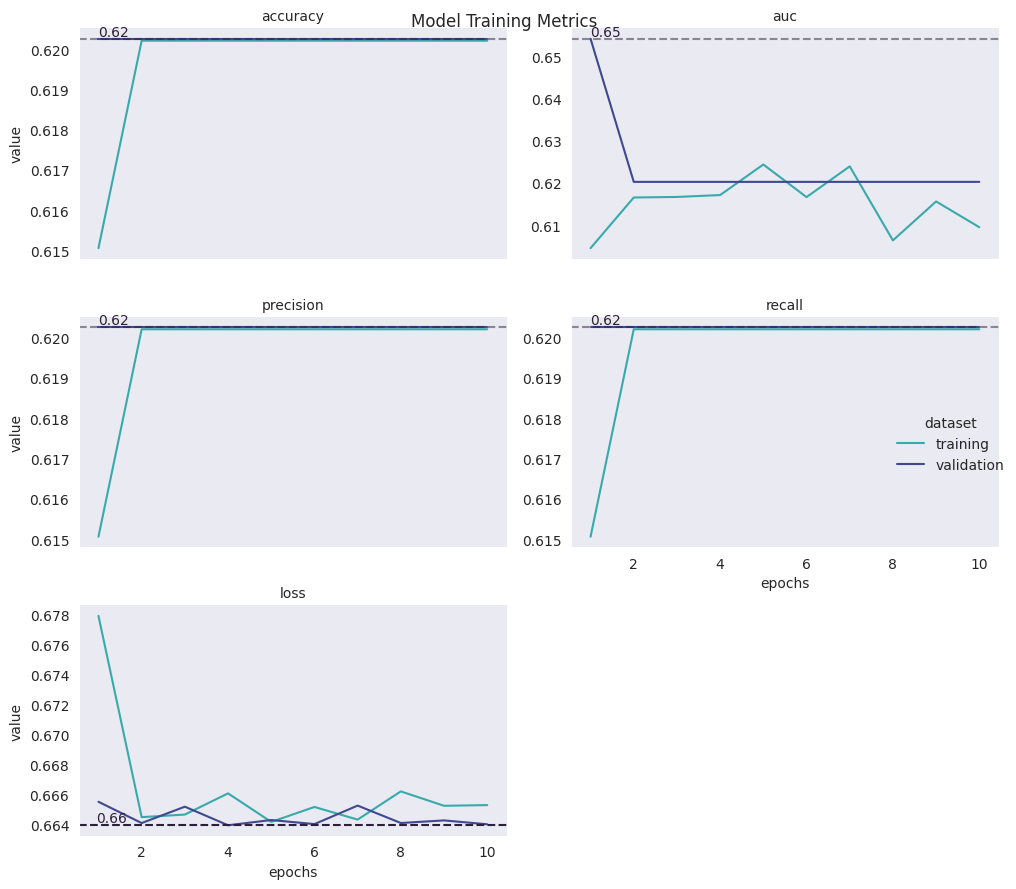

ValueError: ignored

In [ ]:
trained_model, model_history = run_training_pipeline(None, stroke_train_path, stroke_test_path, classes=stroke_classes, model=model, model_name="stroke_OzNet", frozen_epochs=10, unfrozen_epochs=150, validation_split=0.1, augment_training_data=True, plot_results=True, patience=10)

In [ ]:
import os
import shutil
from os.path import join
import keras
import numpy as np


root_dir = "data"
stroke_dir = join(root_dir, "stroke", "Brain_Data_Organised")
stroke_train_path = join(stroke_dir, "train")
stroke_test_path = join(stroke_dir, "test")
stroke_classes = ["Normal", "Stroke"]

In [ ]:
def split_train_test_data(images_dir: str, classes, test_ratio: float = 0.1):
    for i in classes:
        train_dir = join(images_dir, "train", i)
        test_dir = join(images_dir, "test", i)
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        source = join(images_dir, i)

        allFileNames = os.listdir(source)

        np.random.shuffle(allFileNames)

        test_ratio = test_ratio

        train_FileNames, test_FileNames = np.split(
            np.array(allFileNames), [int(len(allFileNames) * (1 - test_ratio))]
        )

        train_FileNames = [source + "/" + name for name in train_FileNames.tolist()]
        test_FileNames = [source + "/" + name for name in test_FileNames.tolist()]

        for name in train_FileNames:
            shutil.copy(name, train_dir)

        for name in test_FileNames:
            shutil.copy(name, test_dir)


split_train_test_data(images_dir=stroke_dir, classes=stroke_classes, test_ratio=0.001)

In [ ]:
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.metrics import AUC, Accuracy, CategoricalAccuracy, Precision, Recall
from keras import Input, Sequential

input_shape = (227, 227, 3)
n_classes = len(stroke_classes)

metrics = {
    "accuracy": "accuracy",
    "auc": AUC(name="auc"),
    "precision": Precision(name="precision"),
    "recall": Recall(name="recall"),
}

model = Sequential(
    [
        Input(shape=input_shape),
        Conv2D(
            filters=64,
            kernel_size=(5, 5),
            strides=1,
            padding="valid",
            activation="relu",
        ),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
        ),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
        Conv2D(
            filters=128,
            kernel_size=(13, 13),
            strides=1,
            padding="valid",
            activation="relu",
        ),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
        Conv2D(
            filters=256,
            kernel_size=(7, 7),
            strides=1,
            padding="same",
            activation="relu",
        ),
        MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
        ),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
        ),
        MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
        ),
        MaxPooling2D(pool_size=(1, 1), strides=2, padding="valid"),
        Flatten(),
        Dense(4096, activation="relu"),
        Dropout(0.5),
        Dense(n_classes, activation="softmax"),
    ]
)

model.summary()
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=list(metrics.values())
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 128)       2769024   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 21, 21, 128)       0

In [ ]:
# Define the image size
IMAGE_SIZE = 224

# Define the batch size
BATCH_SIZE = 32

INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

def get_generators(train_path: str, test_path: str, preprocessing_function, batch_size: int=BATCH_SIZE, image_shape=(IMAGE_SIZE, IMAGE_SIZE), class_mode: str='binary', validation_split: float=0.1, augment_training_data: bool=False):

  if augment_training_data:
    # Define the data generator for training data
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        rotation_range=20, # randomly rotate images by 20 degrees
        width_shift_range=0.2, # randomly shift images horizontally by 20%
        height_shift_range=0.2, # randomly shift images vertically by 20%
        shear_range=0.2, # randomly apply shearing transformations
        zoom_range=0.2, # randomly zoom in on images
        horizontal_flip=True, # randomly flip images horizontally
        vertical_flip=False, # randomly flip images vertically
        fill_mode='nearest', # fill any empty pixels with the nearest pixel value
        rescale=1. / 255,
        validation_split=validation_split
    )
  else:
    train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function, validation_split=validation_split)


  # Define the data generator for validation data
  test_datagen = keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=preprocessing_function
  )

  # Define the training data generator
  train_generator = train_datagen.flow_from_directory(
      train_path, # path to the training data directory
      target_size=image_shape, # resize images to (IMG_SIZE, IMG_SIZE)
      batch_size=batch_size, # set the batch size
      class_mode=class_mode, # set the class mode to binary classification
      shuffle=True,
      subset='training'
  )

  # Define the validation data generator
  val_generator = train_datagen.flow_from_directory(
      train_path, # path to the validation data directory
      target_size=image_shape, # resize images to (IMG_SIZE, IMG_SIZE)
      batch_size=batch_size, # set the batch size
      class_mode=class_mode, # set the class mode to binary classification
      shuffle=True,
      subset='validation'
  )

  test_generator = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=image_shape,
                                             batch_size=batch_size,
                                             class_mode=class_mode)

  return train_generator, val_generator, test_generator

stroke_train_data, stroke_val_data, stroke_test_data = get_generators(stroke_train_path, stroke_test_path, lambda x: x, validation_split=0.1, augment_training_data=True, image_shape=(227,227), class_mode='categorical')

NameError: ignored

In [ ]:
trained_model, model_history = run_training_pipeline(None, stroke_train_path, stroke_test_path, model=model, classes=stroke_classes, model_name="stroke_oznet", frozen_epochs=10, unfrozen_epochs=20, validation_split=0.1, augment_training_data=True, plot_results=True, patience=10)

Found 5974 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Epoch 1/10


TypeError: ignored

In [ ]:
from keras.models import Model

feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dropout').output)
features = feature_extractor.predict(stroke_train_data)

71/71 [==============================] - 75s 859ms/step


In [ ]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', C=1.0, probability=True)

svm_classifier.fit(features,
                   stroke_train_data.classes,)

SVC(kernel='linear', probability=True)

In [ ]:
test_features = feature_extractor.predict(stroke_test_data)

1/1 [==============================] - 1s 1s/step


In [ ]:

accuracy = svm_classifier.score(test_features, stroke_test_data.classes)
print("SVM Accuracy:", accuracy)

SVM Accuracy: 0.6666666666666666


In [ ]:
import copy
import io
import os
import time
import warnings
from glob import glob

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from tqdm import tqdm
from os.path import join

warnings.simplefilter("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla T4


In [ ]:
stroke_dir = "./data/stroke/"
input_dir = join(stroke_dir, "input")
output_dir = join(stroke_dir, "output")
class_names = os.listdir(input_dir)
class_names

['Normal', 'Stroke']

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == class_names[0]:
            label = 0
        else:
            label = 1
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders


splitfolders.ratio(input_dir, ratio=(0.85, 0.1, 0.05))

Copying files: 2501 files [00:00, 7628.80 files/s]


In [ ]:
datasets = {"train": [], "val": [], "test": []}
for phase in datasets.keys():
    l = []
    for i in glob(f"{output_dir}/{phase}/**/*"):
        l.append(i)
    datasets[phase] = l

In [ ]:
train_transform = A.Compose(
    [

        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=90, p=0.5),
        A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ColorJitter(),
        A.RandomCrop(width=128, height=128, p=0.2),
        A.HorizontalFlip(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
original_transform = A.Compose(
    [
        A.Resize(180, 180),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
alb_dataset = ClassificationDataset(
    images_filepaths=datasets["train"], transform=train_transform
)
original_dataset = ClassificationDataset(
    images_filepaths=datasets["train"], transform=original_transform
)

dataset_sizes = {x: len(datasets[x]) for x in ["train", "val"]}
dataset_sizes

{'train': 2125, 'val': 250}

In [ ]:
import uuid

try:
    os.mkdir(join(stroke_dir, "augmented"))
    os.mkdir(join(stroke_dir, "augmented", class_names[0]))
    os.mkdir(join(stroke_dir, "augmented", class_names[1]))

except:
    print("Nope")

In [ ]:
def OriginalSave(originalDataset, limit):
    s = {i: class_names[i] for i in range(len(class_names))}

    originalDataset.transform = A.Compose(
        [
            t
            for t in originalDataset.transform
            if not isinstance(t, (A.Normalize, ToTensorV2))
        ]
    )

    for idx in range(limit):
        try:
            image, label = originalDataset[idx]
            cv2.imwrite(
                f'{join(stroke_dir, "augmented")}/{s[label]}/{str(uuid.uuid4())}.jpg',
                image,
            )
        except:
            print("Error")


OriginalSave(original_dataset, dataset_sizes['train'])

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Erro

In [ ]:
from random import randint

def AlbSave(albDataset, n_samples, sizes):
    s = {i: class_names[i] for i in range(len(class_names))}

    albDataset.transform = A.Compose(
        [
            t
            for t in albDataset.transform
            if not isinstance(t, (A.Normalize, ToTensorV2))
        ]
    )
    for _ in range(n_samples['Normal']):
        idx = randint(0, sizes['Normal']-1)
        try:
            image, label = albDataset[idx]
            if label == 0:
                cv2.imwrite(
                    f"{join(stroke_dir, 'augmented')}/{s[label]}/{str(uuid.uuid4())}.jpg", image
                )
        except:
            print("Error")

    for _ in range(n_samples['Stroke']):
        idx = sizes['Normal'] + randint(0, sizes['Stroke']-1)
        try:
            image, label = albDataset[idx]
            if label == 1:
                cv2.imwrite(
                    f"{join(stroke_dir, 'augmented')}/{s[label]}/{str(uuid.uuid4())}.jpg", image
                )
        except:
            print("Error")

In [ ]:
n_normal = len(os.listdir(join(output_dir, 'train', 'Normal')))
n_stroke = len(os.listdir(join(output_dir, 'train', 'Stroke')))
sizes = {'Normal': n_normal,
         "Stroke": n_stroke}

n_augmented = 100
n_samples = {'Normal': n_augmented,
            "Stroke": n_augmented + n_normal - n_stroke}
AlbSave(alb_dataset, n_samples, sizes)

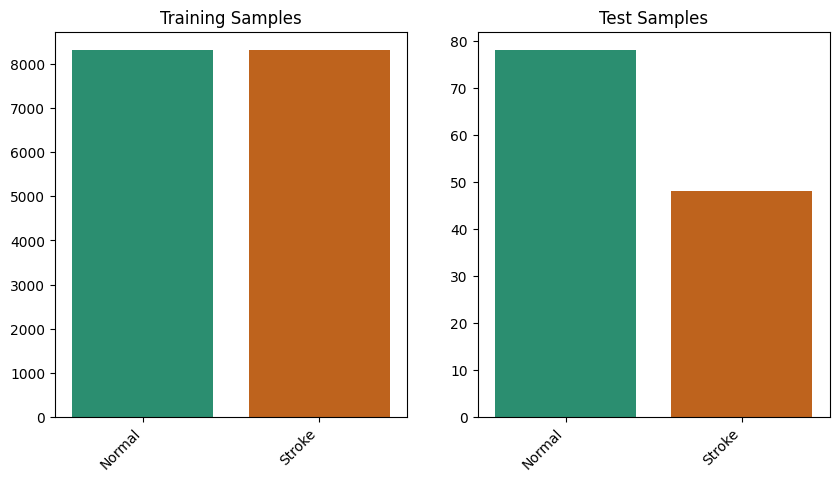

In [ ]:
stroke_dir = join(root_dir, "stroke")
stroke_train_path = join(stroke_dir, 'augmented')
stroke_test_path = join(stroke_dir, 'output', 'test')
stroke_classes = ['Normal', 'Stroke']

#split_train_test_data(images_dir=stroke_dir, classes=stroke_classes, test_ratio=0.05)
plot_dataset_balance(stroke_train_path, stroke_test_path, stroke_classes)

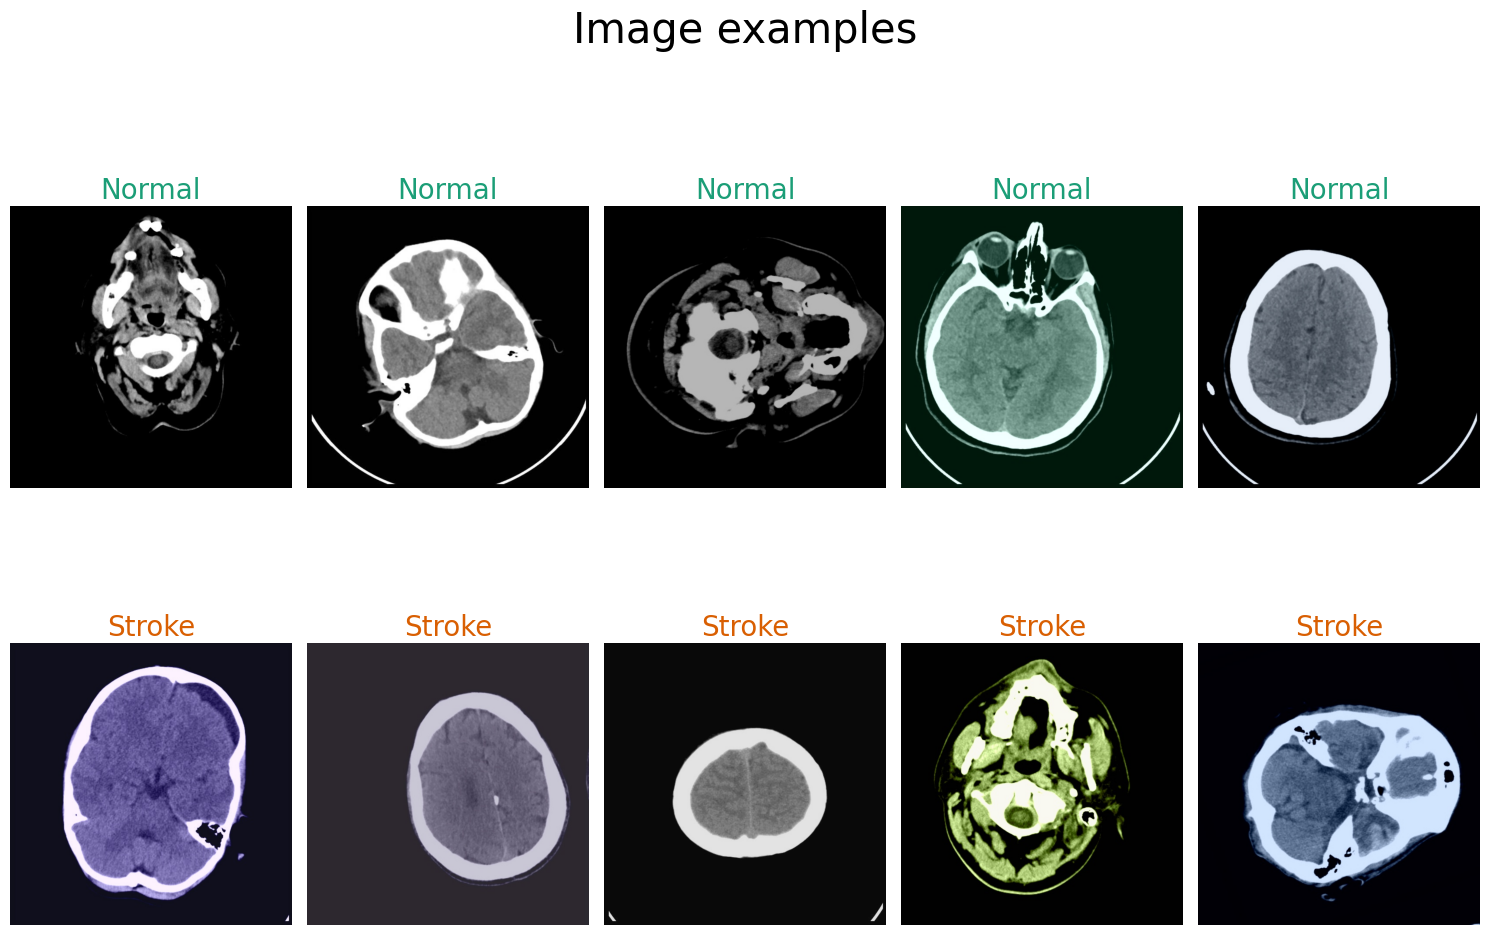

In [ ]:
show_example_grid(stroke_train_path, stroke_classes)

In [ ]:
len(os.listdir(join(stroke_dir, 'augmented', 'Normal'))), len(os.listdir(join(stroke_dir, 'augmented', 'Stroke')))

(8318, 8318)

In [ ]:
difference = len(os.listdir(join(stroke_dir, 'augmented', 'Normal'))) - len(os.listdir(join(stroke_dir, 'augmented', 'Stroke')))
difference

0

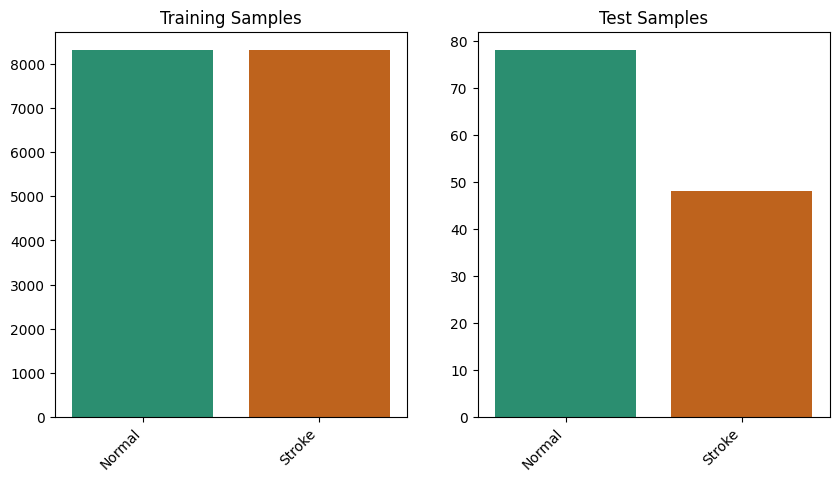

In [ ]:
stroke_dir = join(root_dir, "stroke")
stroke_train_path = join(stroke_dir, 'augmented')
stroke_test_path = join(stroke_dir, 'output', 'test')
stroke_classes = ['Normal', 'Stroke']

#split_train_test_data(images_dir=stroke_dir, classes=stroke_classes, test_ratio=0.05)
plot_dataset_balance(stroke_train_path, stroke_test_path, stroke_classes)

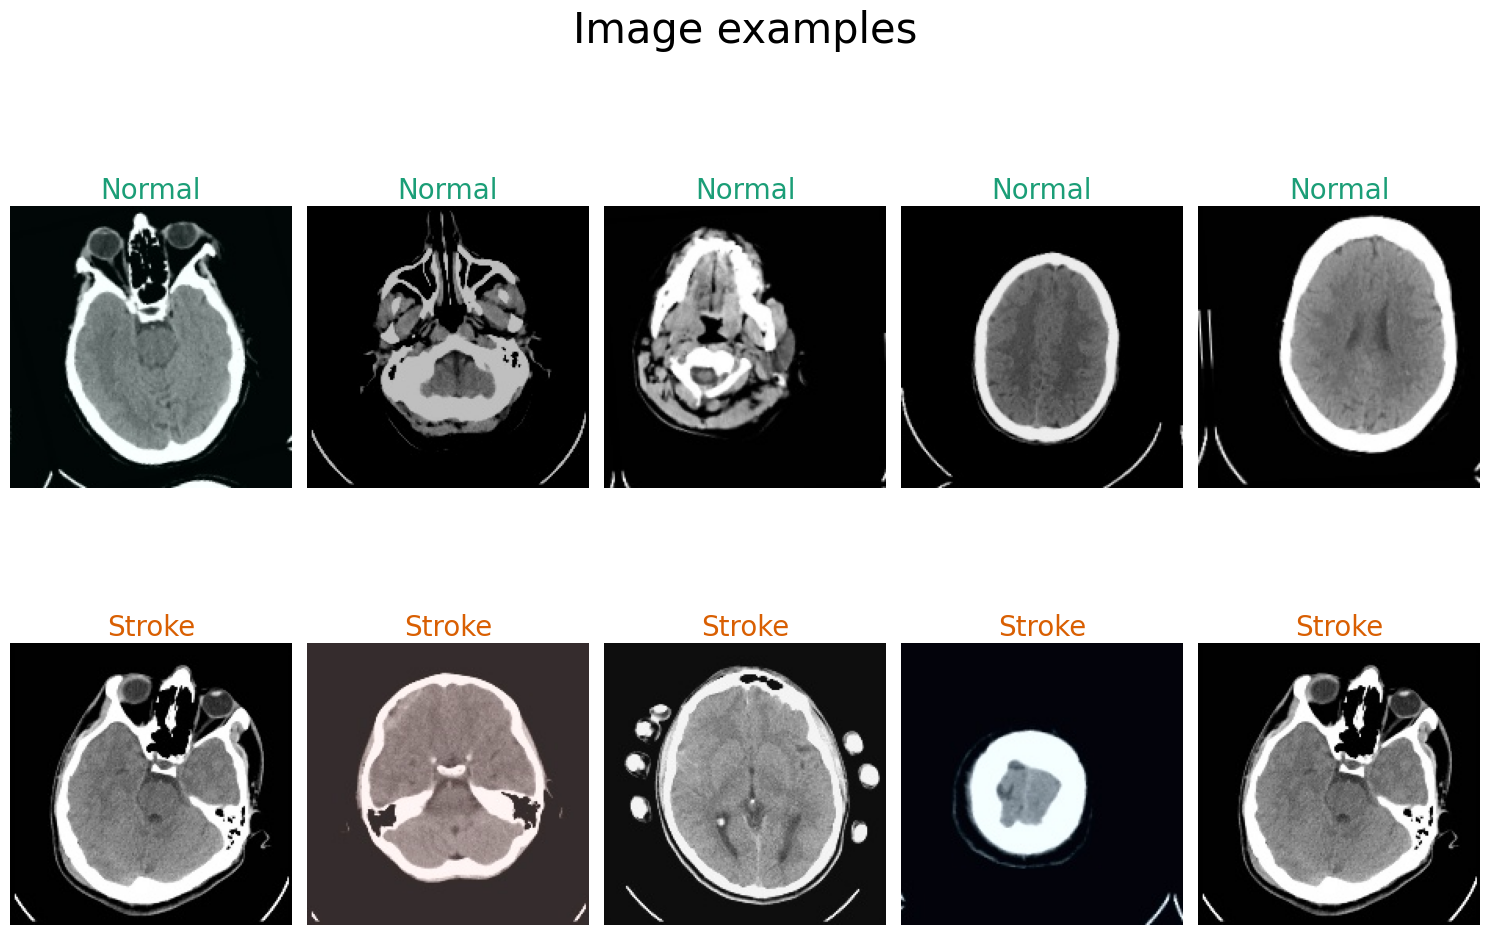

In [ ]:
show_example_grid(stroke_train_path, stroke_classes)

Found 5974 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
VGG19
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                             

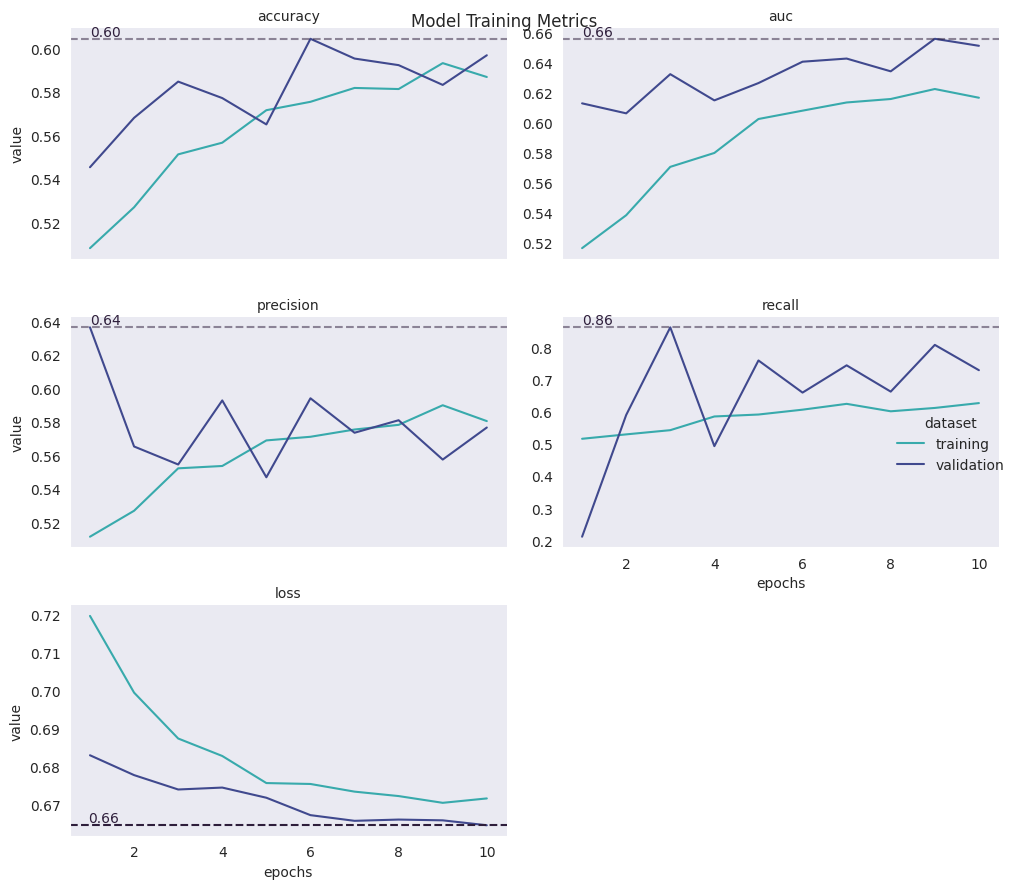

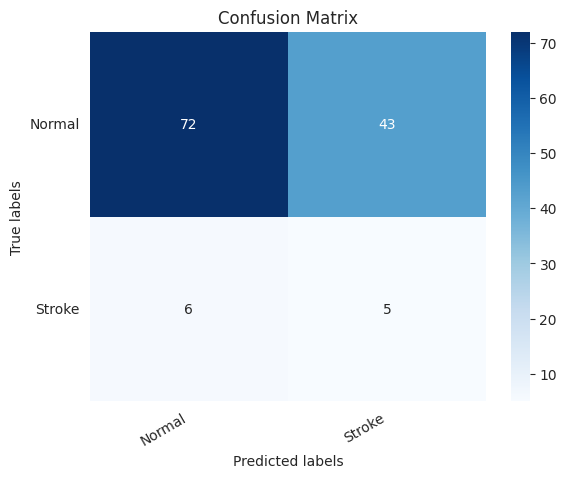

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

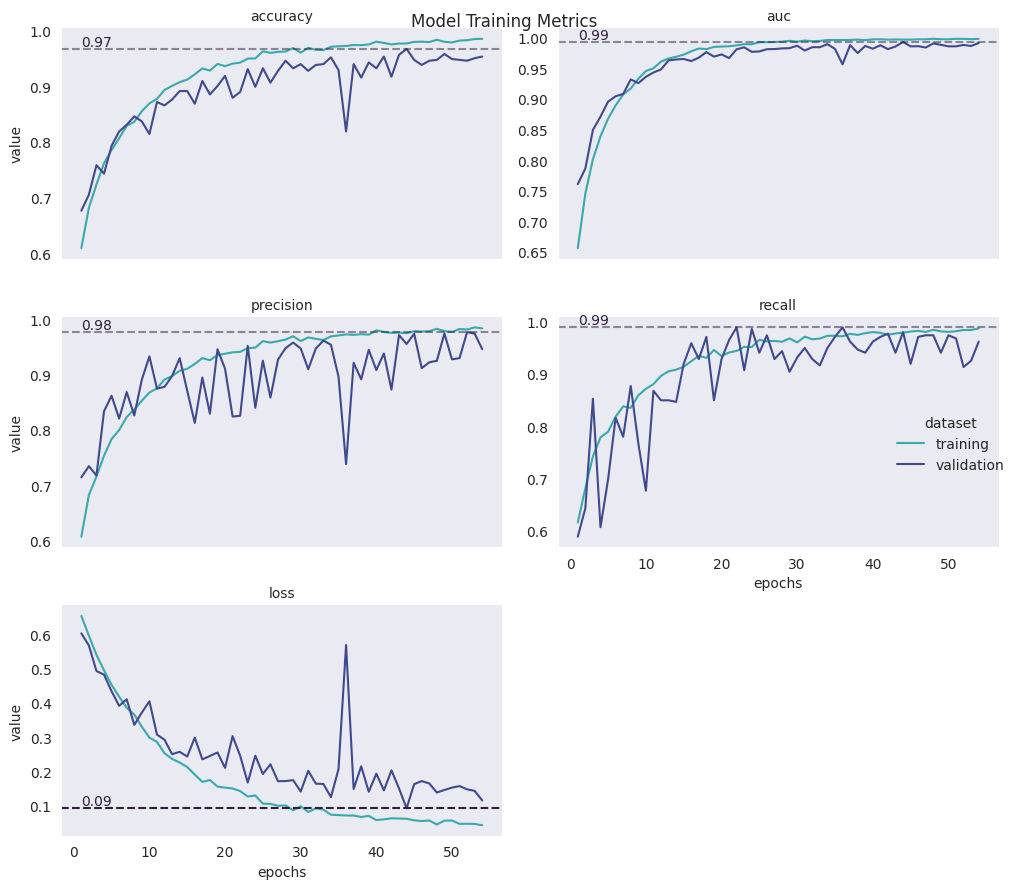

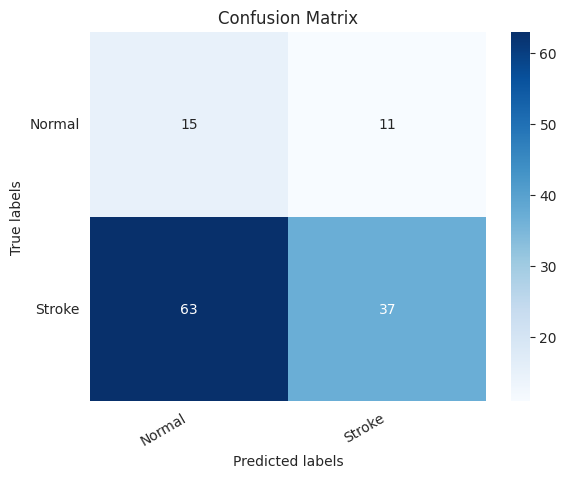

In [ ]:
trained_model, model_history = run_training_pipeline(VGG19, stroke_train_path, stroke_test_path, classes=stroke_classes, model_name="stroke_vgg19", frozen_epochs=10, unfrozen_epochs=150, validation_split=0.1, augment_training_data=True, plot_results=True, patience=10)

In [ ]:
dir_name = 'augmented'

for dir in os.listdir(join(stroke_dir, dir_name)):
  for f in os.listdir(join(stroke_dir, dir_name, dir)):
    try:
      os.remove(join(stroke_dir, dir_name, dir, f))
    except:
      continue
  os.rmdir(join(stroke_dir, dir_name, dir))
os.rmdir(join(stroke_dir, dir_name))

In [ ]:
!zip -r '/content/stroke.zip' '/content/stroke_vgg19_unfrozen.h5'

  adding: content/stroke_vgg19_unfrozen.h5 (deflated 7%)


In [ ]:
trained_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
stroke_train_data, stroke_val_data, stroke_test_data = get_generators(stroke_train_path, stroke_test_path, lambda x: x, validation_split=0.1, augment_training_data=True, image_shape=(227,227), class_mode='binary')

Found 5974 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [ ]:
from keras.models import Model

feature_extractor = Model(inputs=trained_model.input, outputs=trained_model.get_layer('dropout_1').output)
features = feature_extractor.predict(stroke_train_data)

187/187 [==============================] - 80s 411ms/step


In [ ]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', C=1.0, probability=True)

svm_classifier.fit(features,
                   stroke_train_data.classes,)

SVC(kernel='linear', probability=True)

In [ ]:
test_features = feature_extractor.predict(stroke_test_data)
accuracy = svm_classifier.score(test_features, stroke_test_data.classes)
print("SVM Accuracy:", accuracy)

4/4 [==============================] - 3s 864ms/step
SVM Accuracy: 0.5476190476190477


In [ ]:
evaluate_model(trained_model, stroke_train_data)

187/187 [==============================] - 90s 477ms/step - loss: 0.0714 - accuracy: 0.9730 - auc: 0.9972 - precision: 0.9603 - recall: 0.9869
Test loss: 0.07141075283288956
Test accuracy: 0.9730498790740967
Test AUC: 0.9972243905067444


Found 14974 images belonging to 2 classes.
Found 1662 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
DenseNet169
51877672/51877672 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 1)                 1

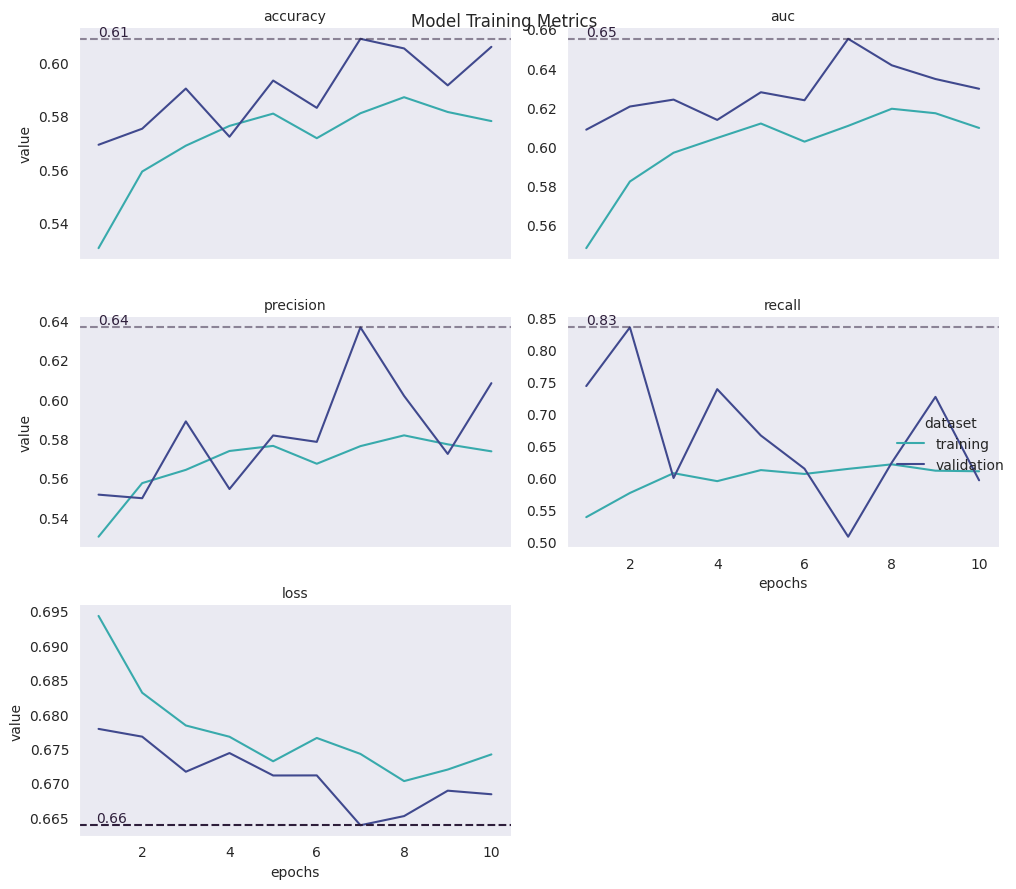

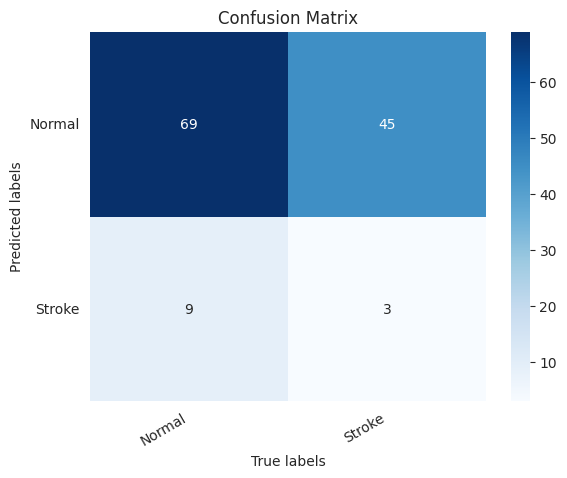

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 1)                 1665      
                                                                 
Total params: 12644545 (48.24 MB)
Trainable params: 12486145 (47.63 MB)
Non-trainable params: 158400 (618.75 KB)
______________

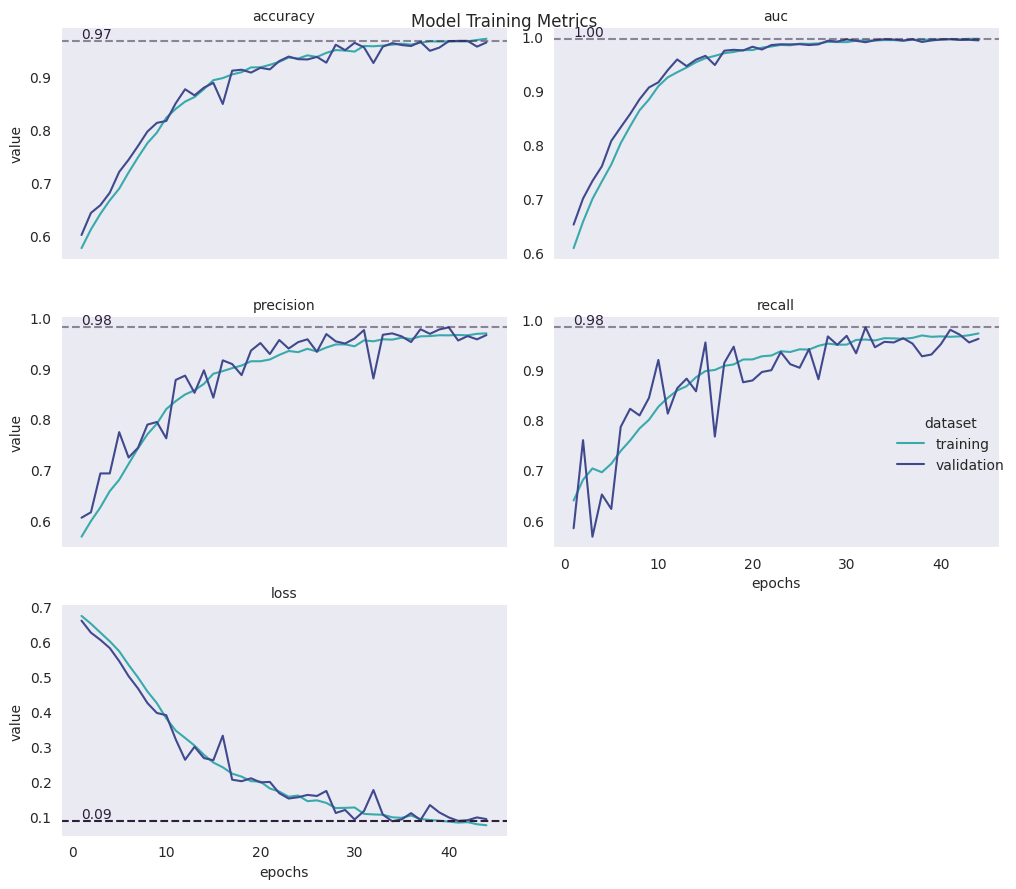

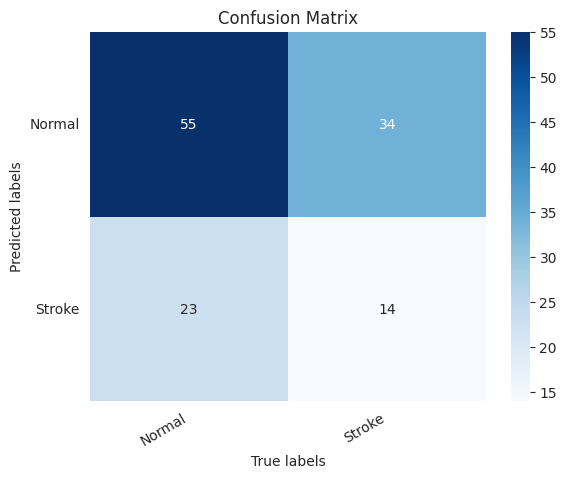

In [ ]:
trained_model, model_history = run_training_pipeline(DenseNet169, stroke_train_path, stroke_test_path, classes=stroke_classes, model_name="stroke_densenet169", frozen_epochs=10, unfrozen_epochs=150, validation_split=0.1, augment_training_data=True, plot_results=True, patience=10)

Found 14974 images belonging to 2 classes.
Found 1662 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
VGG19
80134624/80134624 [==============================] - 2s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513  

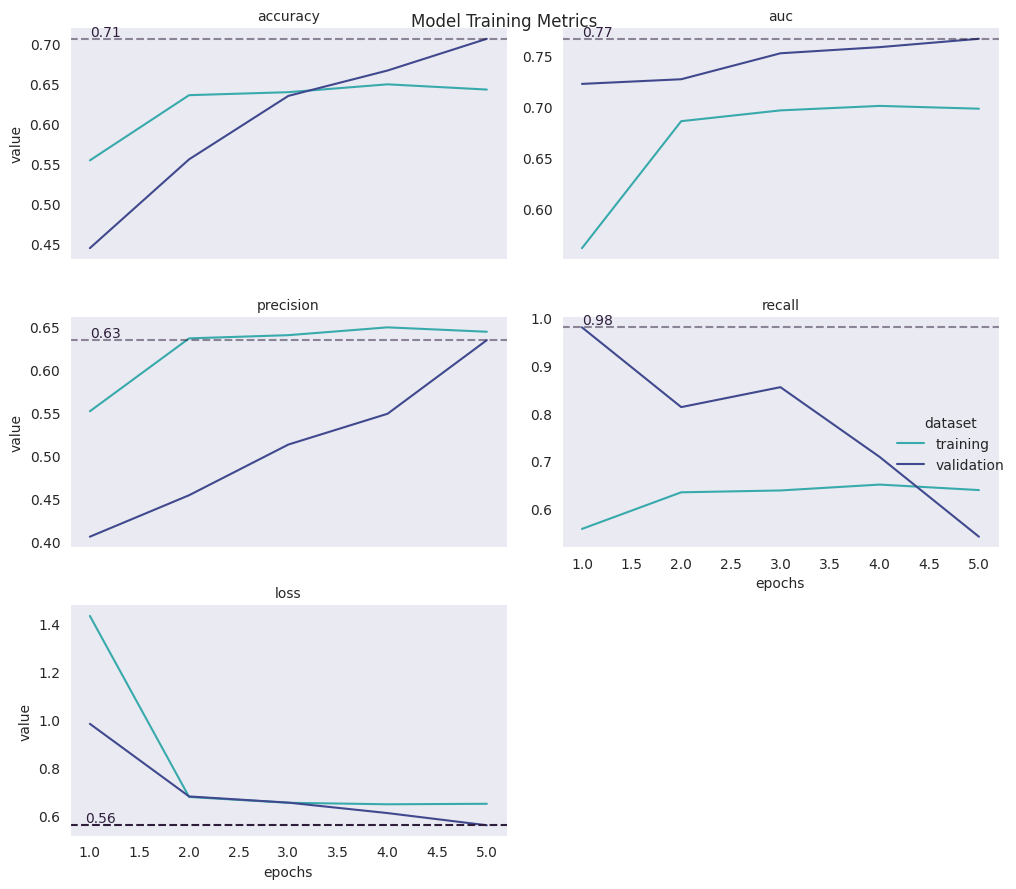

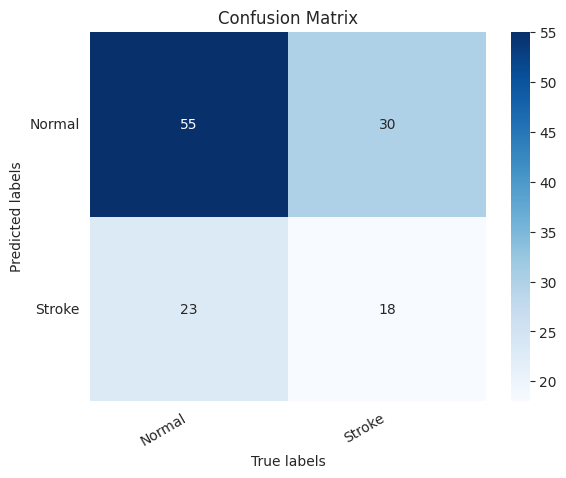

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

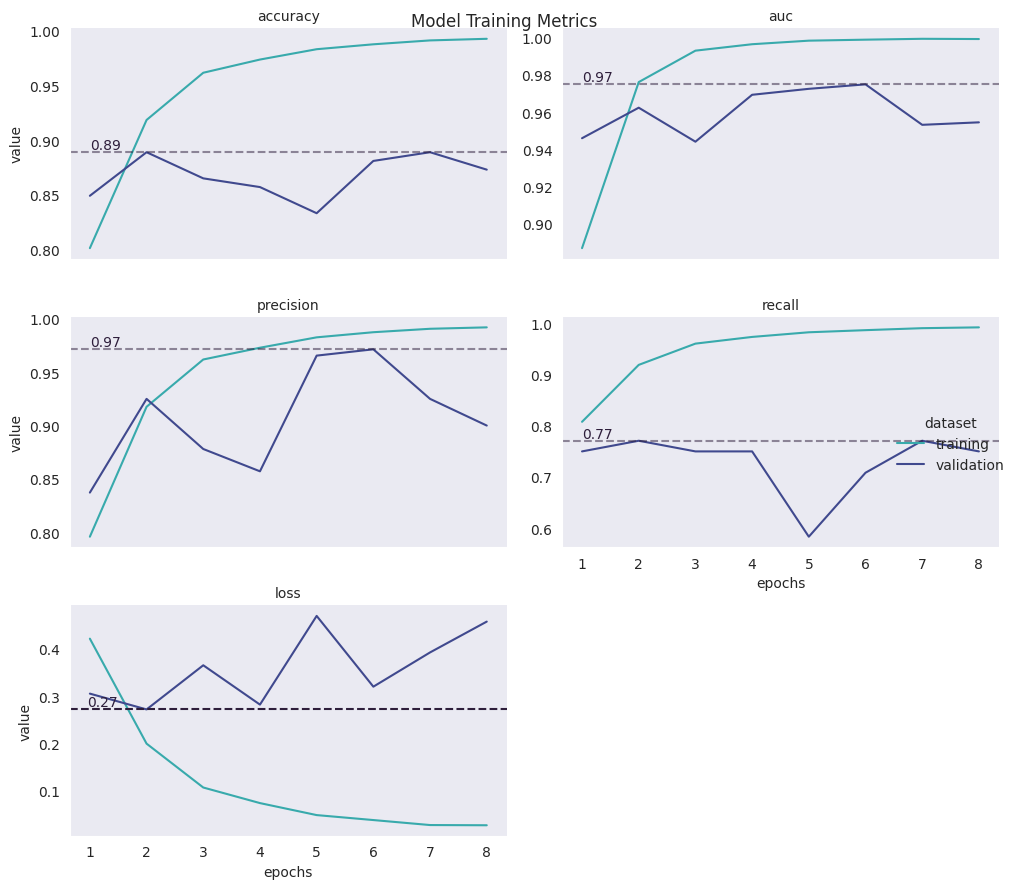

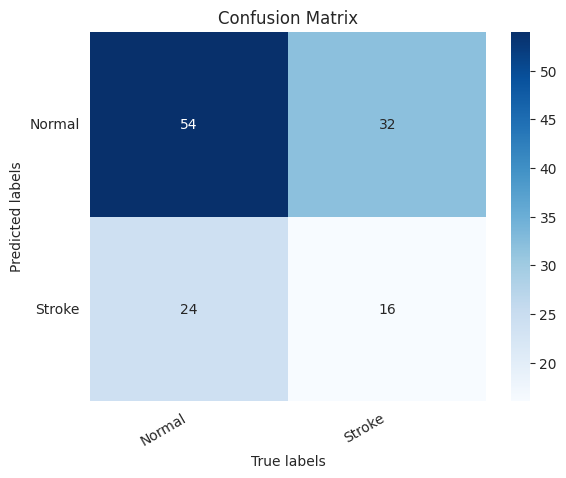

In [ ]:
trained_model, model_history = run_training_pipeline(VGG19, stroke_train_path, stroke_test_path, classes=stroke_classes, model_name="stroke_vgg19", frozen_epochs=5, unfrozen_epochs=8, validation_split=0.1, augment_training_data=False, plot_results=True, patience=10)

In [ ]:
trained_model = load_model("stroke_densenet169_unfrozen.h5")

In [ ]:
stroke_train_data, stroke_val_data, stroke_test_data = get_generators(stroke_train_path, stroke_test_path, lambda x: x, validation_split=0.1, augment_training_data=False, image_shape=(227,227), class_mode='binary')
evaluate_model(trained_model, stroke_test_data)

Found 14974 images belonging to 2 classes.
Found 1662 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
4/4 [==============================] - 6s 952ms/step - loss: 0.2066 - accuracy: 0.9286 - auc: 0.9797 - precision: 0.8980 - recall: 0.9167
Test loss: 0.2066289782524109
Test accuracy: 0.9285714030265808
Test AUC: 0.9797008037567139


4/4 [==============================] - 1s 166ms/step


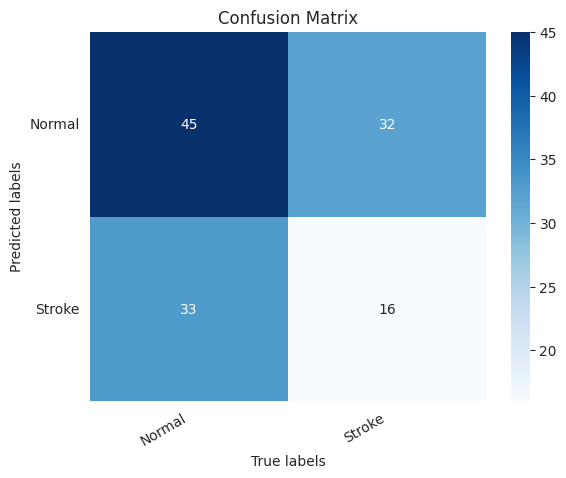

In [ ]:
y_true, y_pred = get_predictions(trained_model, stroke_test_data, binary=True)
plot_confusion_matrix(y_true, y_pred, classes=stroke_classes)

In [ ]:

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.63      0.67        91
           1       0.29      0.40      0.34        35

    accuracy                           0.56       126
   macro avg       0.51      0.51      0.51       126
weighted avg       0.61      0.56      0.58       126



In [ ]:
trained_model = load_model("alzheimer_vgg19_unfrozen.h5")

In [ ]:
alzheimer_dir = join(root_dir, "alzheimer")
alzheimer_train_path = join(alzheimer_dir, 'AugmentedAlzheimerDataset')
alzheimer_test_path = join(alzheimer_dir, 'OriginalDataset')
alzheimer_classes = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

In [ ]:
alzheimer_train_data, alzheimer_val_data, alzheimer_test_data = get_generators(alzheimer_train_path, alzheimer_test_path, vgg19.preprocess_input, class_mode='categorical', augment_training_data=False, image_shape=(176,208))

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [ ]:
y_true, y_pred = get_predictions(trained_model, alzheimer_test_data, binary=False)
y_true = [alzheimer_classes[i] for i in y_true]
y_pred = [alzheimer_classes[i] for i in y_pred]
report = classification_report(y_true, y_pred, labels=alzheimer_classes)
print(report)

1/1 [==============================] - 0s 28ms/step
                  precision    recall  f1-score   support

     NonDemented       0.83      0.83      0.83         6
VeryMildDemented       0.00      0.00      0.00         0
    MildDemented       0.94      0.94      0.94        17
ModerateDemented       1.00      1.00      1.00         9

       micro avg       0.94      0.94      0.94        32
       macro avg       0.69      0.69      0.69        32
    weighted avg       0.94      0.94      0.94        32



1/1 [==============================] - 0s 27ms/step


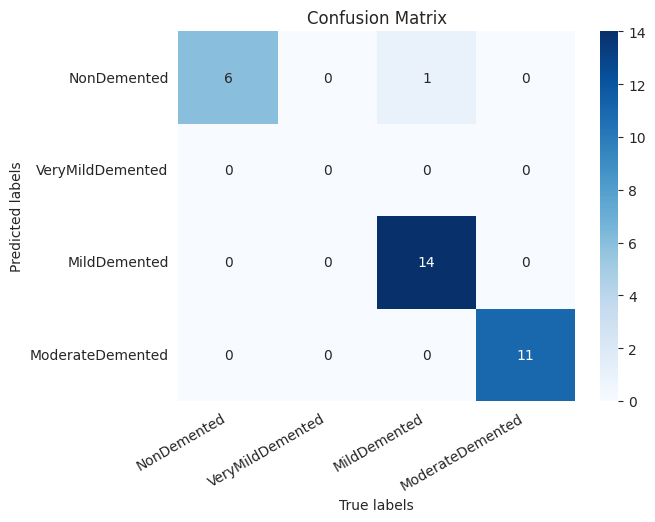

In [ ]:
y_true, y_pred = get_predictions(trained_model, alzheimer_test_data, binary=False)
plot_confusion_matrix(y_true, y_pred, classes=alzheimer_classes)